In [2]:
# import CSS stylesheet
from IPython.display import HTML, display
display(HTML(f"<style>{open('../style.css').read()}</style>"))

<a id="summary"></a>

<p class="summary">Summary</p>

<ol class="sub">
    <li class="sub"><a href="#packages">Packages</a>
    <li class="sub"><a href="#functions">Functions</a></li>
    <li class="sub"><a href="#first-look-at-the-data">First look at the data</a></li>
    <li class="sub"><a href="#creating-the-grids">Creating the grids (HxW)</a>
        <ol class="sub">
            <li class="sub"><a href="#whole-map">Whole map</a></li>
            <li class="sub"><a href="#buffering-the-north-america">Buffering the north_america_nad83_dissolved</a></li>
        </ol>
    </li>
    <li class="sub"><a href="#data-analysis">Data analysis</a>
        <ol class="sub">
            <li class="sub"><a href="#introduction-to-the-analysis">Introduction to the analysis</a></li>
            <li class="sub"><a href="#rank-distribution">Rank distribution</a></li>
            <li class="sub"><a href="#rank-distribution-after-buffering">Rank distribution after buffering (look end of section 4.1)</a></li>
        </ol>
    </li>
    <li class="sub"><a href="#count-the-number-of-species">Count the number of species within each grid</a>
        <ol class="sub">
            <li class="sub"><a href="#grids-50-km">Grids 50km²</a></li>
            <li class="sub"><a href="#grids-100-km">Grids 100km²</a></li>
        </ol>
    </li>
    <li class="sub"><a href="#europe-data">Europe data</a>
        <ol class="sub">
            <li class="sub"><a href="#first-look">First look</a></li>
            <li class="sub"><a href="#count-the-number-of-grids">Count the number of grids</a>
                <ol class="sub">
                    <li class="sub"><a href="#for-the-50-km">For the 50 km²</a></li>
                    <li class="sub"><a href="#for-the-100-km">For the 100 km²</a></li>
                </ol>
            </li>
        </ol>
    </li>
    <li class="sub"><a href="#fixing-shp-files-exported">Fixing shp files exported (DONE)</a>
        <ol class="sub">
            <li class="sub"><a href="#north-america">North America</a>
                <ol class="sub">
                    <li class="sub"><a href="#north-america-50-km">50 km²</a></li>
                    <li class="sub"><a href="#north-america-100-km">100 km²</a></li>
                </ol>
            </li>
            <li class="sub"><a href="#europe">Europe</a>
                <ol class="sub">
                    <li class="sub"><a href="#europe-50-km">50 km²</a></li>
                    <li class="sub"><a href="#europe-100-km">100 km²</a></li>
                </ol>
            </li>
        </ol>
    </li>
    <li class="sub"><a href="#north-america-again">North America (AGAIN)</a></li>
    <li class="sub"><a href="#compare-the-richness-distribution">Compare the richness distribution for different grids</a>
        <ol class="sub">
            <li class="sub"><a href="#compare-the-richness-distribution-europe">Europe</a></li>
            <li class="sub"><a href="#compare-the-richness-distribution-north-america">North America</a></li>
        </ol>
    </li>
</ol>

# Packages
<a id="packages"></a>
<a href="#summary">Summary</a>

In [5]:
# directories, dictionaries, and strings
import glob
from collections import OrderedDict
import string

# data structures
import geopandas as gpd  # work with shp files
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union, polygonize
import gpd_lite_toolbox as glt
# import georasters as grs  # for rasterized maps (tif files)
# import georaster as gr  # for rasterized maps (tif files)

# multiprocessing
from multiprocessing import Pool

# dynamical maps
# import mplleaflet

# figures
from matplotlib.lines import Line2D

# hvr package
from pyhvr import *
loadstd()

# Functions
<a id="functions"></a>
<a href="#summary">Summary</a>

In [6]:
def fishnet(polygon, width, height, save_path=False):

    xmin, ymin, xmax, ymax =  polygon.total_bounds

    rows = int(np.ceil((ymax - ymin) /  height))
    cols = int(np.ceil((xmax - xmin) / width))

    XleftOrigin = xmin
    XrightOrigin = xmin + width

    YtopOrigin = ymax
    YbottomOrigin = ymax - height

    polygons = []

    gridHeight, gridWidth = height, width

    for i in range(cols):

        Ytop    = YtopOrigin
        Ybottom = YbottomOrigin

        for j in range(rows):

            polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)]))

            Ytop    = Ytop - gridHeight
            Ybottom = Ybottom - gridHeight

        XleftOrigin  = XleftOrigin + gridWidth
        XrightOrigin = XrightOrigin + gridWidth
    
    if not save_path:
        return gpd.GeoDataFrame({'geometry':polygons})
    else:
        gpd.GeoDataFrame({'geometry':polygons}).to_file(save_path)

In [7]:
def polygon_border_coords(polygon, xlim=False, ylim=False):
    
    def gdf(polygon):
        # pick the coordinates
        x, y = polygon.exterior.coords.xy
        
        if type(xlim) == list:
            df = pd.DataFrame(OrderedDict({'x': x, 'y': y}))
            df = df[(df['x'] > xlim[0]) & (df['x'] < xlim[1])]
            x, y = np.array(df['x']), np.array(df['y'])
        
        if type(ylim) == list:
            df = pd.DataFrame(OrderedDict({'x': x, 'y': y}))
            df = df[(df['y'] > ylim[0]) & (df['y'] < ylim[1])]
            x, y = np.array(df['x']), np.array(df['y'])
            
        # create the pd.DataFrame
        df = pd.DataFrame({'geometry': list(zip(x, y))})
        # transform all the coordinates into shapely.geometry.Point
        df['geometry'] = df['geometry'].apply(Point)

        # create the gpd.GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry='geometry')
        
        return gdf
    
    if str(type(polygon)) == "<class 'shapely.geometry.polygon.Polygon'>":
        return gdf(polygon)
    
    else:
        return pd.concat([gdf(plg) for plg in polygon])

In [8]:
def fishnet_limits(polygon, width, height, xlim=None, ylim=None, save_path=False):
    if type(xlim) == list and type(ylim) == list:
        xmin, xmax = xlim
        ymin, ymax = ylim
        
    elif xlim == None and ylim == None:
        xmin, ymin, xmax, ymax =  polygon.total_bounds

    rows = int(np.ceil((ymax - ymin) /  height))
    cols = int(np.ceil((xmax - xmin) / width))

    XleftOrigin = xmin
    XrightOrigin = xmin + width

    YtopOrigin = ymax
    YbottomOrigin = ymax - height

    polygons = []

    gridHeight, gridWidth = height, width

    for i in range(cols):

        Ytop    = YtopOrigin
        Ybottom = YbottomOrigin

        for j in range(rows):

            polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)]))

            Ytop    = Ytop - gridHeight
            Ybottom = Ybottom - gridHeight

        XleftOrigin  = XleftOrigin + gridWidth
        XrightOrigin = XrightOrigin + gridWidth
    
    if not save_path:
        return gpd.GeoDataFrame({'geometry':polygons})
    else:
        gpd.GeoDataFrame({'geometry':polygons}).to_file(save_path)

## Section 5

In [ ]:
def count_points(entry):
    c = 0
    try:
        for _ in entry['geometry'].iloc[0]:
            c += 1
        return c
    except:
        return 1

In [1014]:
def count_grids(entry):
    # check to see if it is a Polygon or a Multipolygon
    if str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.multipolygon.MultiPolygon'>":
        return gpd.overlay(entry, grids_5050_within_north_america_dissolved, how='intersection').shape[0]
    
    elif str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.polygon.Polygon'>":
        return gpd.overlay(entry, grids_5050_within_north_america_dissolved, how='intersection').shape[0]
    
    # check to see if it is a Point
    elif str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.point.Point'>":
        return count_points(entry['geometry'])
    
    # check to see if it is a MultiPoint
    elif str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.multipoint.MultiPoint'>":
        return count_points(entry)

# First look at the data
<a id="first-look-at-the-data"></a>
<a href="#summary">Summary</a>

In [9]:
# creating dictionaries for the projections we are going to use
nad83_proj_dict = {'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0}

wgs84_proj_dict = {'init': 'epsg:4326'}

The data consists in shape files for more than 300 species in the North America continent.

In [ ]:
shp_files = glob.glob("../../macrophytes_data/north_america/Shapefilet/*/*shp")
len(shp_files)

In [ ]:
folders = [file.split("/")[-2] for file in shp_files]
files   = [file.split("/")[-1] for file in shp_files]

In [ ]:
path_details_df = pd.DataFrame(
    OrderedDict(
    {'folders': folders,
     'files': files,
     'paths': shp_files}
    )
)

The exact number of species in this data is 

In [177]:
path_details_df['folders'].unique().shape[0]

337

and the number of shape files is

In [178]:
path_details_df['files'].shape[0]

582

The figure below shows the number of files within each folder (specie).

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


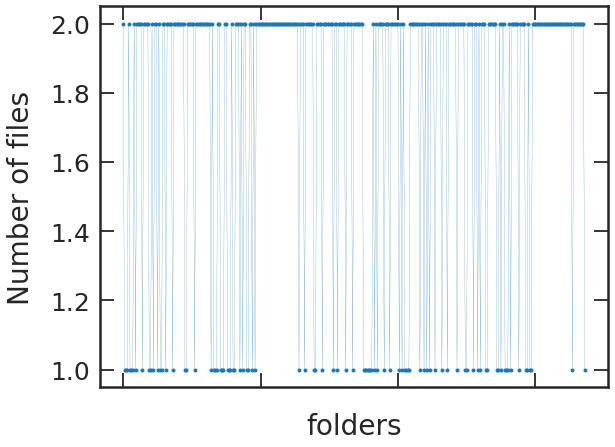

In [179]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize())

path_details_df.groupby(by='folders').count()['files'].plot(marker='o', markersize=3, lw=0.2, ax=ax)
ax.set_ylabel('Number of files');

Note that we have a maximum of two files for some species.

As one can see, we have shape files just with points:



In [180]:
gpd.read_file(shp_files[0])

Id                                       geometry
0   0  POINT (-805688.0079871967 -219440.9858933525)
1   0  POINT (-1321626.539864261 -382160.0613315034)
2   0   POINT (-1979117.438179391 1817854.755364797)

and some of them with several polygons:

In [181]:
gpd.read_file(shp_files[1])

Id                                           geometry
0   0  (POLYGON ((-1933776.583608784 138305.059459850...
1   0  POLYGON ((1217232.010075063 466547.7992786579,...

Observe that for the same species we might have shp files with points and polygons. For instance

In [182]:
path_details_df[path_details_df['folders'] == path_details_df['folders'][0]]

folders                 files  \
0  AlisGram    AlisGram_point.shp   
1  AlisGram  AlisGram_polygon.shp   

                                               paths  
0  ../../macrophytes_data/north_america/Shapefile...  
1  ../../macrophytes_data/north_america/Shapefile...

The details about the projection being used are

In [183]:
gpd.read_file(path_details_df['paths'].iloc[0]).crs

{'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0}

This corresponds to the **North America Lambert Conformal Conic**

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.crs

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


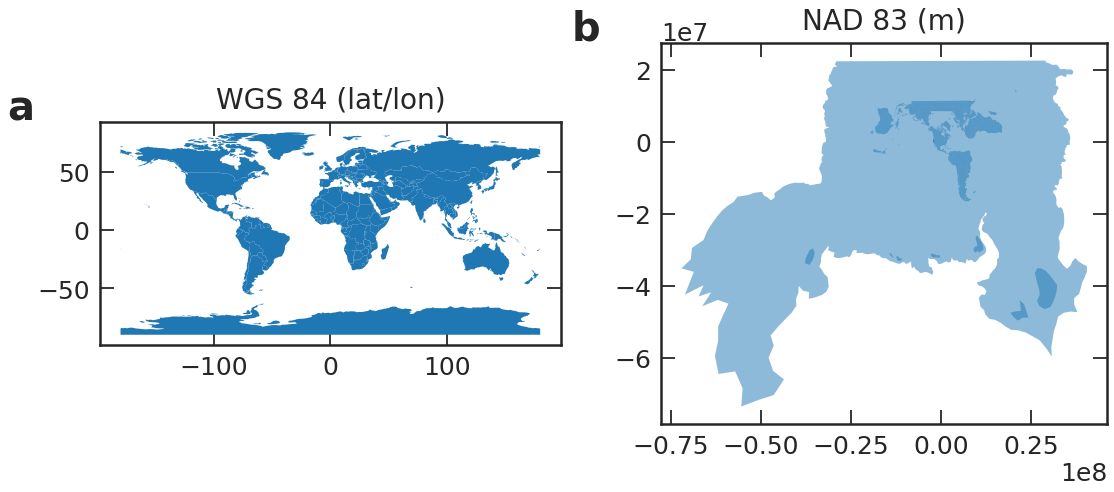

In [184]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(scale=1, nx=2, ny=1))
fs_label = 40;

world.plot(ax=ax[0])
ax[0].set_title("WGS 84 (lat/lon)");

world_nad83 = world.to_crs({'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0})

world_nad83.plot(ax=ax[1], alpha=0.5)
gpd.read_file(path_details_df['paths'].iloc[502]).plot(ax=ax[1], color='red')
ax[1].set_title('NAD 83 (m)');

[ax[c].annotate(string.ascii_lowercase[c], (-0.2, 1.01), xycoords='axes fraction', fontsize=fs_label, weight='bold') for c in range(2)];

In [ ]:
north_america_nad83 = world[world['continent'] == 'North America'].to_crs({'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0})

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


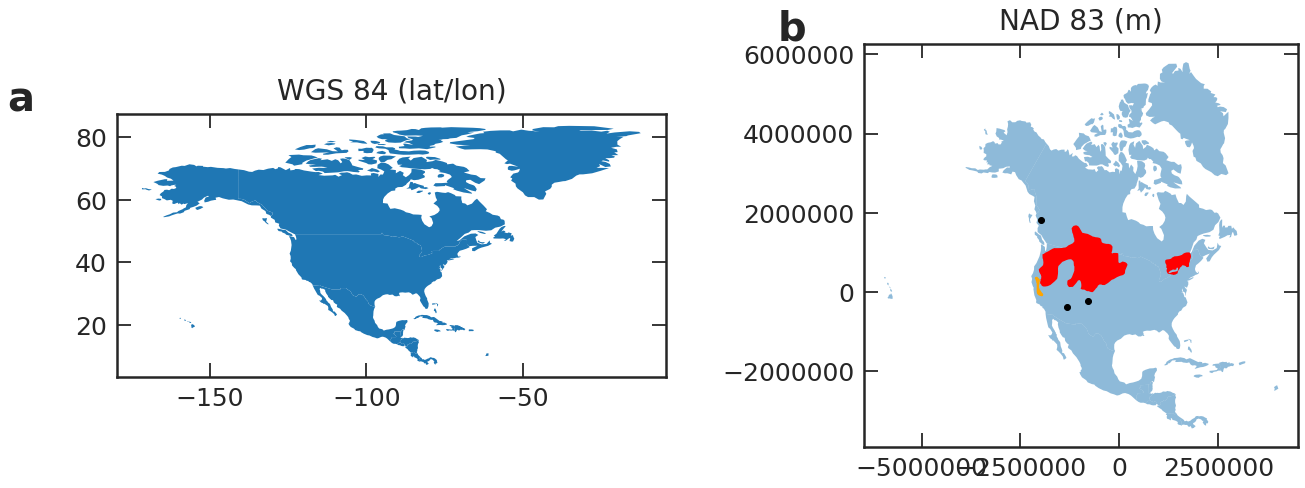

In [185]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(scale=1, nx=2, ny=1))
fs_label = 40;

world[world['continent'] == 'North America'].plot(ax=ax[0])
ax[0].set_title("WGS 84 (lat/lon)");

north_america_nad83 = world[world['continent'] == 'North America'].to_crs({'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0})


north_america_nad83.plot(ax=ax[1], alpha=0.5)
gpd.read_file(path_details_df['paths'].iloc[502]).plot(ax=ax[1], color='orange')
gpd.read_file(path_details_df['paths'].iloc[1]).plot(ax=ax[1], color='red')
gpd.read_file(path_details_df['paths'].iloc[0]).plot(ax=ax[1], color='black')
ax[1].set_title('NAD 83 (m)');

[ax[c].annotate(string.ascii_lowercase[c], (-0.2, 1.01), xycoords='axes fraction', fontsize=fs_label, weight='bold') for c in range(2)];

fig.tight_layout(pad=1.5, h_pad=2.5, w_pad=2.5)

Now we are going to plot all the data available.

First, we create a column with the geometry available for each specie.

In [ ]:
species_geometries = pd.concat([gpd.read_file(path_details_df['paths'].iloc[i]).dissolve('Id') for i in range(path_details_df.shape[0])])['geometry']

In [187]:
type(species_geometries)

geopandas.geoseries.GeoSeries

And now we create the column on the pd.DataFrame that contains the data details.

In [ ]:
path_details_df['geometry'] = gpd.GeoDataFrame(species_geometries).reset_index(drop=True)
path_details_gdf = gpd.GeoDataFrame(path_details_df, geometry='geometry')

We also calculate the area of each polygon. Points have area equal to 0.0.

In [ ]:
path_details_gdf['area'] = path_details_gdf['geometry'].apply(lambda x: x.area)

The pd.DataFrame with the data information looks like this:

In [190]:
path_details_gdf.head()

folders                 files  \
0       AlisGram    AlisGram_point.shp   
1       AlisGram  AlisGram_polygon.shp   
2       AlisLanc          AlisLanc.shp   
3  AlisPlan-aqua     AlisPlan-aqua.shp   
4       AlisSubc          AlisSubc.shp   

                                               paths  \
0  ../../macrophytes_data/north_america/Shapefile...   
1  ../../macrophytes_data/north_america/Shapefile...   
2  ../../macrophytes_data/north_america/Shapefile...   
3  ../../macrophytes_data/north_america/Shapefile...   
4  ../../macrophytes_data/north_america/Shapefile...   

                                            geometry          area  
0  (POINT (-1979117.438179391 1817854.755364797),...  0.000000e+00  
1  (POLYGON ((1217232.010075063 466547.7992786579...  2.144365e+12  
2  (POLYGON ((-2141318.758422129 281993.412289276...  6.421037e+10  
3       POINT (-2442740.545034301 3442876.618396966)  0.000000e+00  
4  POLYGON ((2086831.985638313 812269.6764740683,...  3.125733e+12

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


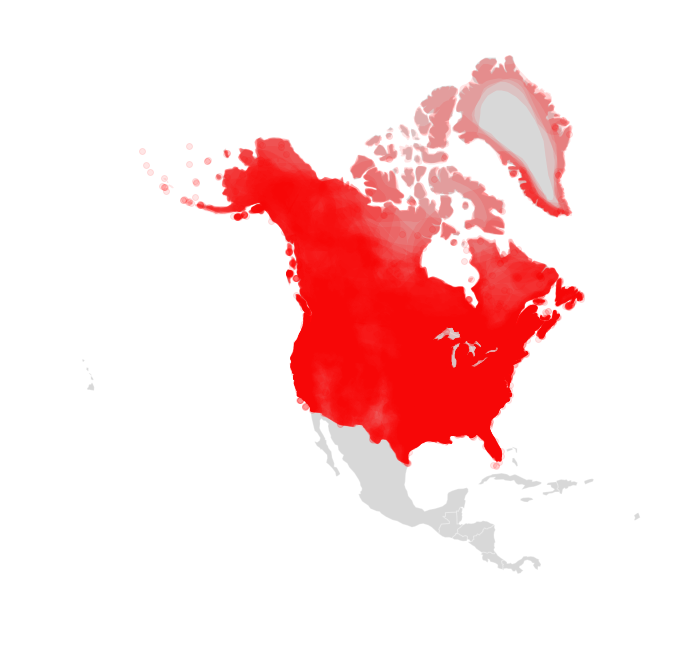

In [191]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=1.5))

north_america_nad83.plot(ax=ax, alpha=0.3, edgecolor='white', color='gray')
path_details_gdf['geometry'].plot(ax=ax, color='red', alpha=0.1)



ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
ax.axis('off')

fig.savefig('../figures/north_america._data.pdf', dpi=200)

From the map above, we can see that there is no data in the Central America (as expected). Thus, we remove the countries from Central America.

In [ ]:
central_america_countries = [
    'Belize',
    'Costa Rica',
    'El Salvador',
    'Guatemala',
    'Honduras',
    'Nicaragua',
    'Panama'
]

In [193]:
north_america_nad83[north_america_nad83['name'].isin(central_america_countries)]

pop_est      continent         name iso_a3  gdp_md_est  \
20     307899.0  North America       Belize    BLZ      2536.0   
36    4253877.0  North America   Costa Rica    CRI     48320.0   
66   13276517.0  North America    Guatemala    GTM     68580.0   
68    7792854.0  North America     Honduras    HND     33720.0   
116   5891199.0  North America    Nicaragua    NIC     16790.0   
123   3360474.0  North America       Panama    PAN     38830.0   
144   7185218.0  North America  El Salvador    SLV     43630.0   

                                              geometry  
20   POLYGON ((735999.6501320277 -2345098.785378906...  
36   POLYGON ((1560991.831799566 -3369957.870030245...  
66   POLYGON ((665266.5307835563 -2814643.926672168...  
68   POLYGON ((986133.4003525225 -2874863.743125738...  
116  POLYGON ((1193607.227838515 -3075105.740505744...  
123  POLYGON ((2187381.083736061 -3380138.729562505...  
144  POLYGON ((927837.2275943856 -2834004.583262121...

# Creating the grids (HxW)
<a id="creating-the-grids"></a>
<a href="#summary">Summary</a>

## Whole map
<a id="whole-map"></a>
<a href="#summary">Summary</a>

The first grid we create is for the whole area of the map.

In [78]:
grid_5050 = fishnet(north_america_nad83, width=50000, height=50000)

Now we create the polygons that countour the continent only. To do this we just apply the convex_hull property of the gpd.GeoDataFrame.

In [288]:
north_america_nad83_hulls = north_america_nad83['geometry'].convex_hull

We can also create a square polygon for each convex_hull:

In [289]:
north_america_nad83_envelope = gpd.GeoSeries(north_america_nad83_hulls.envelope)

We pick the points from the border of the countries within the North America continent. We also filter the coordinates to exclude the 

In [531]:
# pick the border points of the continent
north_america_border_points_nad83 = pd.concat([polygon_border_coords(north_america_nad83['geometry'].iloc[i]) for i in range(north_america_nad83.shape[0])]).reset_index(drop=True)

# pick the border points of the continent considering limits
north_america_border_points_nad83_xlim = pd.concat([polygon_border_coords(north_america_nad83['geometry'].iloc[i], xlim=[-4000000,3500000]) for i in range(north_america_nad83.shape[0])]).reset_index(drop=True)

Then we create a grid using the convex hull function, that draw the grids within a polygon that englobes just the points of the continent.

In [468]:
# pick the border points of the continent
north_america_border_points_nad83_ch = pd.concat([polygon_border_coords(north_america_nad83_hulls.iloc[i]) for i in range(north_america_nad83_hulls.shape[0])]).reset_index(drop=True)

# create a dummy column to be used in the glt.gridfy_data function
north_america_border_points_nad83_ch['num'] = np.arange(229)
grid_5050_ch = glt.gridify_data(north_america_border_points_nad83_ch, 50000, 'num', method=np.min)

In [534]:
# create a dummy column to be used in the glt.gridify_data function
north_america_border_points_nad83_xlim['num'] = np.arange(north_america_border_points_nad83_xlim.shape[0])
grid_5050_xlim = glt.gridify_data(north_america_border_points_nad83_xlim, 50000, 'num', method=np.min)

Now we are going to pick the grids that are within the North America. 

In [684]:
# using the convex_hull grids
grids_5050_within_north_america_ch = gpd.overlay(grid_5050_ch, north_america_nad83, how='intersection')
# using the excluded 'islands'
grids_5050_within_north_america = gpd.overlay(grid_5050_xlim, north_america_nad83, how='intersection')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: None and {'datum': 'NAD83', 'lat_0': 40, 'lat_1': 20, 'lat_2': 60, 'lon_0': -96, 'no_defs': True, 'proj': 'lcc', 'units': 'm', 'x_0': 0, 'y_0': 0}
  other.crs))


One more grid is going to be create. We are going to dissolve all polygons that form the North America and create the grids from it.

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


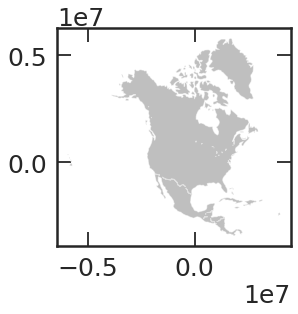

In [983]:
# dissolving
north_america_nad83_dissolved = north_america_nad83.dissolve(by='continent')
# show the final result
north_america_nad83_dissolved.plot(color='gray', edgecolor='white', alpha=0.5);

Now we calculate the grids within this dissolved polygon.

In [984]:
grids_5050_within_north_america_dissolved = gpd.overlay(grid_5050_ch, north_america_nad83_dissolved, how='intersection')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: None and {'datum': 'NAD83', 'lat_0': 40, 'lat_1': 20, 'lat_2': 60, 'lon_0': -96, 'no_defs': True, 'proj': 'lcc', 'units': 'm', 'x_0': 0, 'y_0': 0}
  other.crs))


In [686]:
print("number of grids", "islands:", grids_5050_within_north_america_ch.shape[0], "no islands", grids_5050_within_north_america.shape[0])

number of grids islands: 11560 no islands 11521


/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


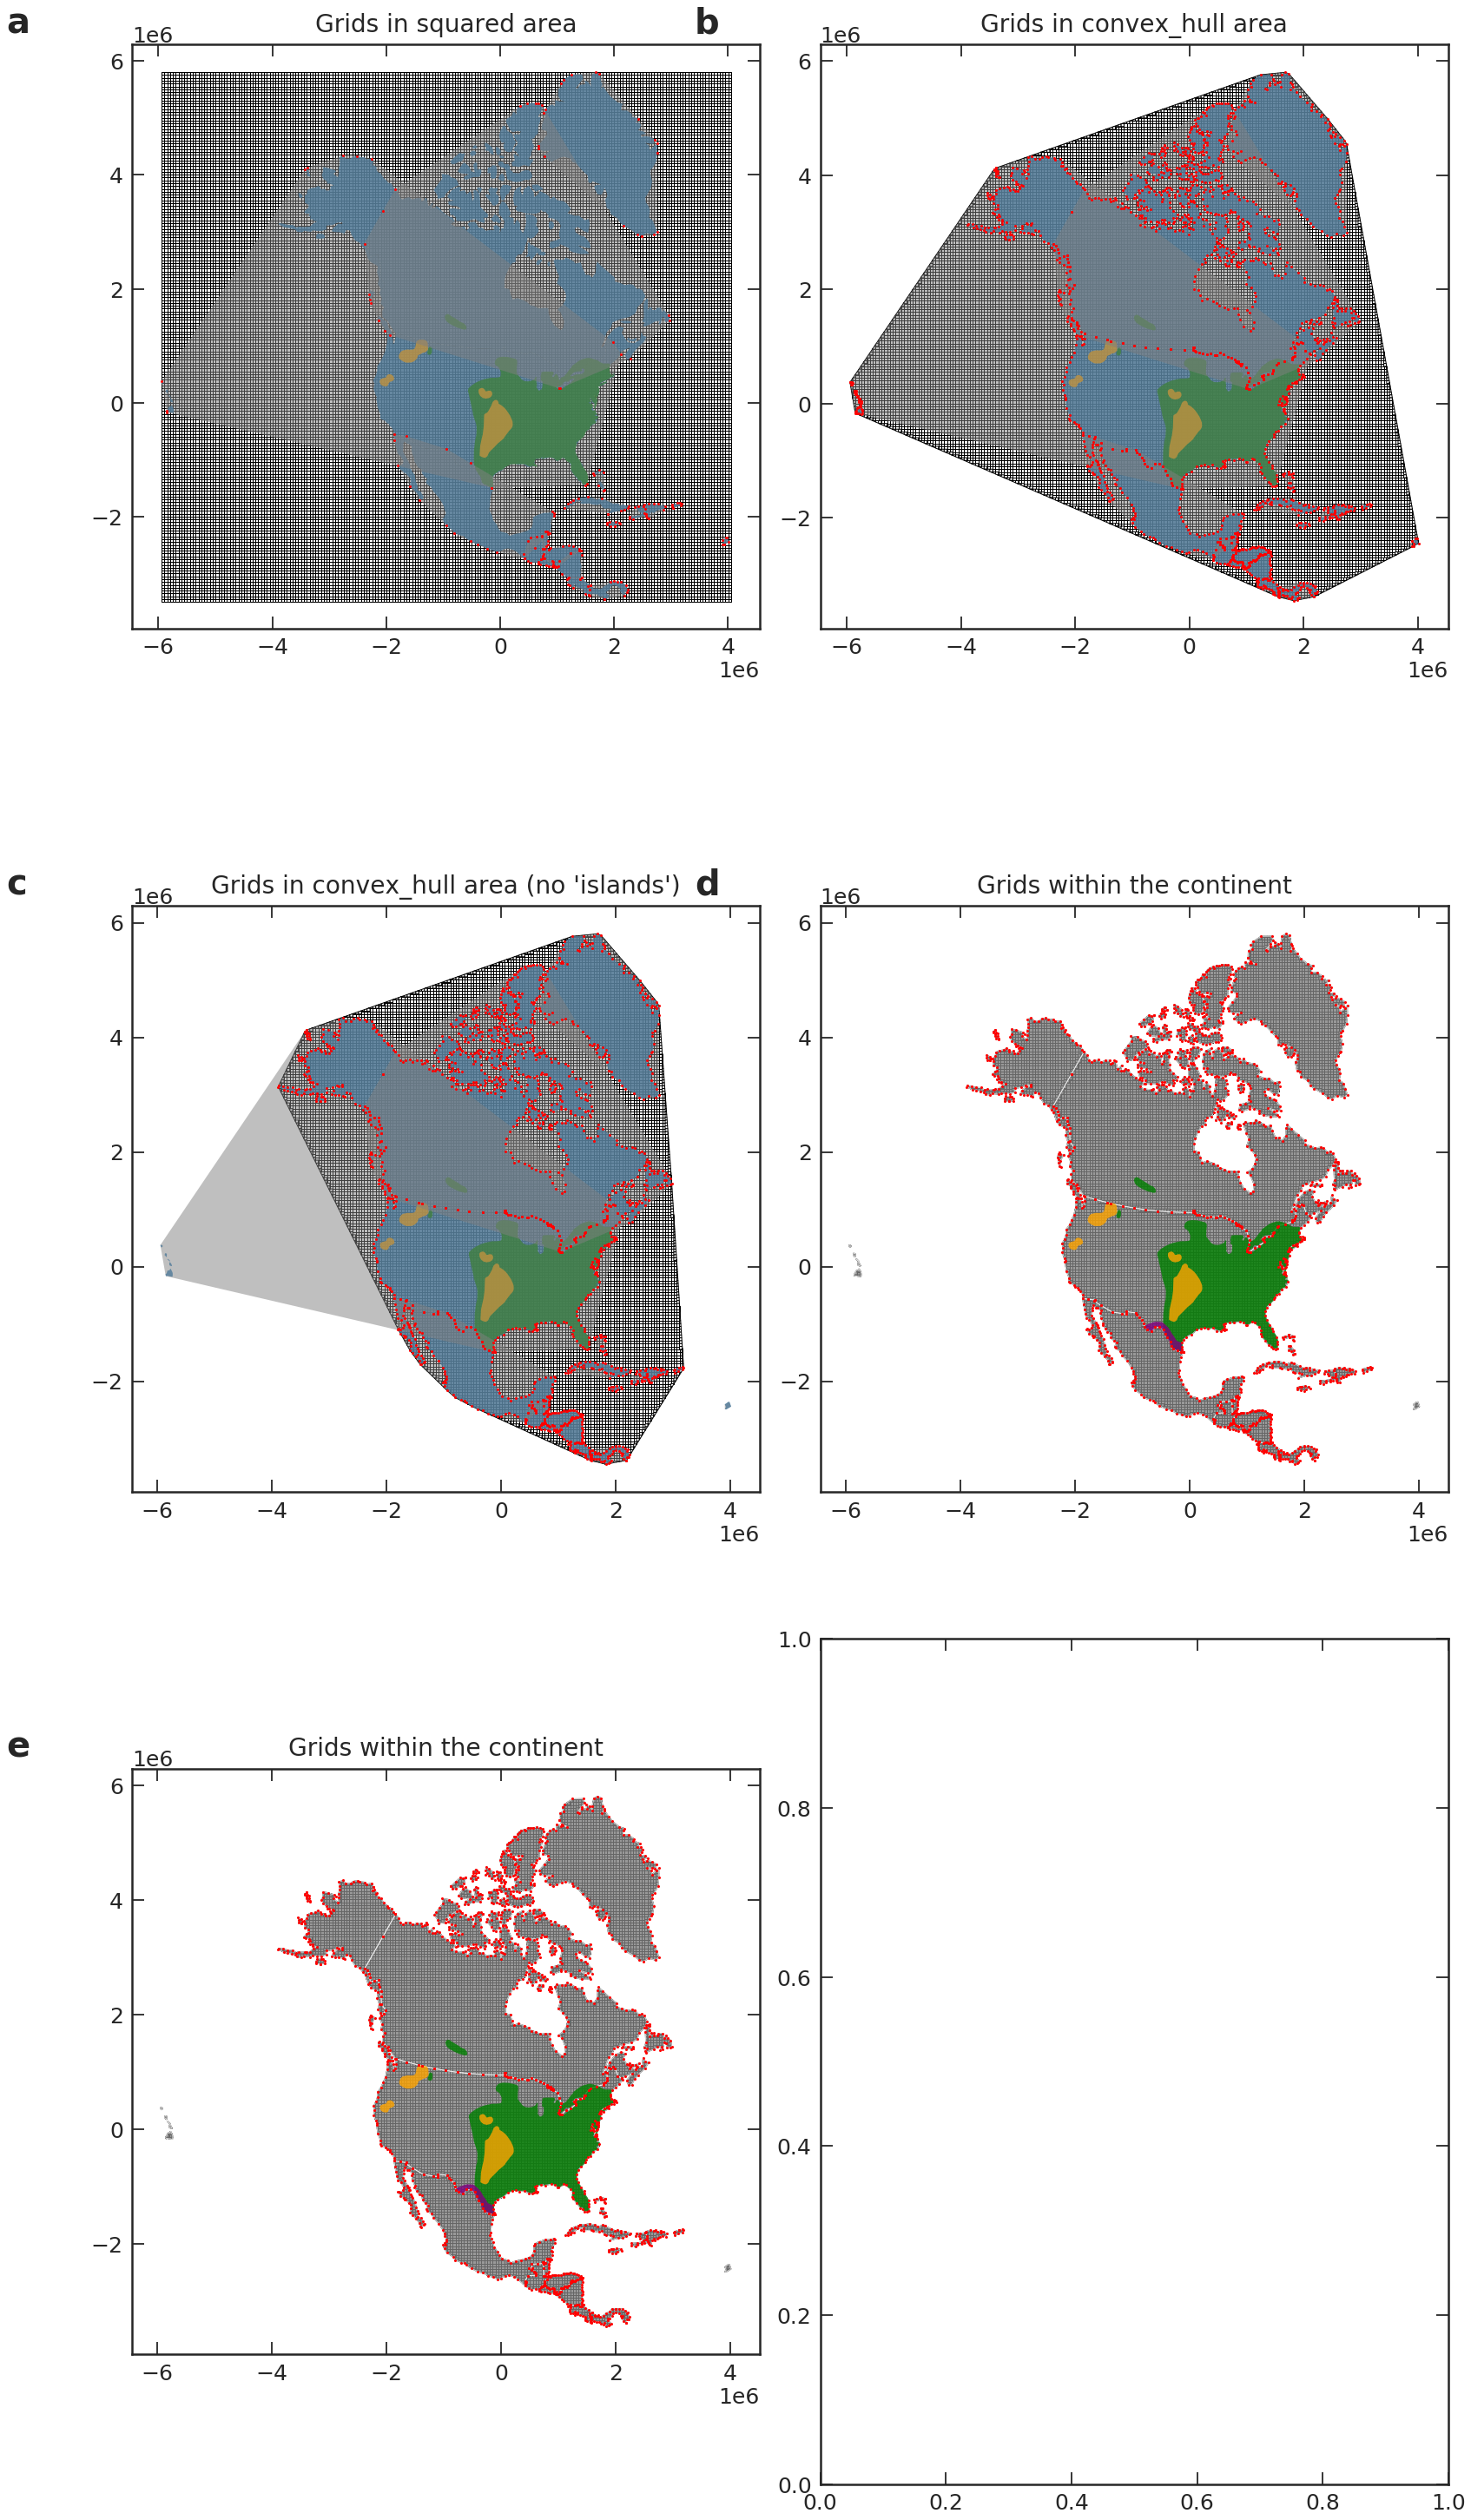

In [991]:
fig, ax = plt.subplots(3, 2, figsize=stdfigsize(scale=2, nx=2, ny=3, ratio=0.8))

fs_label = 40
kwargs = {'markersize': 4, 'color': 'red'}

# BEGIN OF FIGURE A
#------------------

# plot the grid
grid_5050.plot(color='white', edgecolor='black', ax=ax[0,0])

# plot the North America map
north_america_nad83.plot(ax=ax[0,0], alpha=0.8)

# plot some of our data
gpd.read_file(path_details_df['paths'].iloc[502]).plot(ax=ax[0,0], color='green', alpha=0.8)
gpd.read_file(path_details_df['paths'].iloc[1]).plot(ax=ax[0,0], color='orange', alpha=0.8)


# plot the North America convex hulls
north_america_nad83_hulls.plot(ax=ax[0,0], alpha=0.5, color='gray')

# plot the border points of the North America continent
north_america_border_points_nad83_ch.plot(ax=ax[0,0], **kwargs)#color='red', markersize=s_point)

# title
ax[0,0].set_title("Grids in squared area");

#----------------
# END OF FIGURE A

# BEGIN OF FIGURE B
#------------------

# plot the grid
grid_5050_ch.plot(color='white', edgecolor='black', ax=ax[0,1])

# plot the North America map
north_america_nad83.plot(ax=ax[0,1], alpha=0.8)

# plot some of our data
gpd.read_file(path_details_df['paths'].iloc[502]).plot(ax=ax[0,1], color='green', alpha=0.8)
gpd.read_file(path_details_df['paths'].iloc[1]).plot(ax=ax[0,1], color='orange', alpha=0.8)


# plot the North America envelope
north_america_nad83_hulls.plot(ax=ax[0,1], alpha=0.5, color='gray')

# plot the border points of the North America continent
north_america_border_points_nad83.plot(ax=ax[0,1], **kwargs)#color='red', markersize=s_point)

# title
ax[0,1].set_title("Grids in convex_hull area");

#----------------
# END OF FIGURE B

# BEGIN OF FIGURE C
#------------------

# plot the grid
grid_5050_xlim.plot(color='white', edgecolor='black', ax=ax[1,0])

# plot the North America map
north_america_nad83.plot(ax=ax[1,0], alpha=0.8)

# plot some of our data
gpd.read_file(path_details_df['paths'].iloc[502]).plot(ax=ax[1,0], color='green', alpha=0.8)
gpd.read_file(path_details_df['paths'].iloc[1]).plot(ax=ax[1,0], color='orange', alpha=0.8)


# plot the North America envelope
north_america_nad83_hulls.plot(ax=ax[1,0], alpha=0.5, color='gray')

# plot the border points of the North America continent
north_america_border_points_nad83_xlim.plot(ax=ax[1,0], **kwargs)#color='red', markersize=s_point)

# title
ax[1,0].set_title("Grids in convex_hull area (no 'islands')");

#----------------
# END OF FIGURE C

# BEGIN OF FIGURE D
#------------------

# plot the grid
grids_5050_within_north_america_ch.plot(color='white', edgecolor='black', ax=ax[1,1])

# plot the North America map
north_america_nad83.plot(ax=ax[1,1], alpha=0.8, color='grey', edgecolor='white')

# plot some of our data
gpd.read_file(path_details_df['paths'].iloc[502]).plot(ax=ax[1,1], color='green', alpha=0.8)
gpd.read_file(path_details_df['paths'].iloc[1]).plot(ax=ax[1,1], color='orange', alpha=0.8)
gpd.read_file(path_details_df['paths'].iloc[-1]).plot(ax=ax[1,1], color='purple', alpha=0.8)

# plot the border points of the North America continent
north_america_border_points_nad83_xlim.plot(ax=ax[1,1], **kwargs)#color='red', markersize=s_point)

# title
ax[1,1].set_title("Grids within the continent");

#----------------
# END OF FIGURE D

# BEGIN OF FIGURE D
#------------------

# plot the grid
grids_5050_within_north_america_dissolved.plot(color='white', edgecolor='black', ax=ax[2,0])

# plot the North America map
north_america_nad83.plot(ax=ax[2,0], alpha=0.8, color='grey', edgecolor='white')

# plot some of our data
gpd.read_file(path_details_df['paths'].iloc[502]).plot(ax=ax[2,0], color='green', alpha=0.8)
gpd.read_file(path_details_df['paths'].iloc[1]).plot(ax=ax[2,0], color='orange', alpha=0.8)
gpd.read_file(path_details_df['paths'].iloc[-1]).plot(ax=ax[2,0], color='purple', alpha=0.8)

# plot the border points of the North America continent
north_america_border_points_nad83_xlim.plot(ax=ax[2,0], **kwargs)#color='red', markersize=s_point)

# title
ax[2,0].set_title("Grids within the continent");

#----------------
# END OF FIGURE D

x, y, c = 0, 0, 0
for _ in range(5):
    if x == 2:
        x = 0
        y += 1
    # change the ticklabels to scientific notation
    ax[y,x].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    # put the label letters
    ax[y,x].annotate(string.ascii_lowercase[c], (-0.2, 1.02), xycoords='axes fraction', fontsize=fs_label, weight='bold')
    
    x += 1
    c += 1

fig.tight_layout(pad=1.5, h_pad=2, w_pad=2)

Lets compare the grids within the continent obtained for the countries separated and dissolved.

In [999]:
north_america_countries = grids_5050_within_north_america_ch['name'].unique()

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


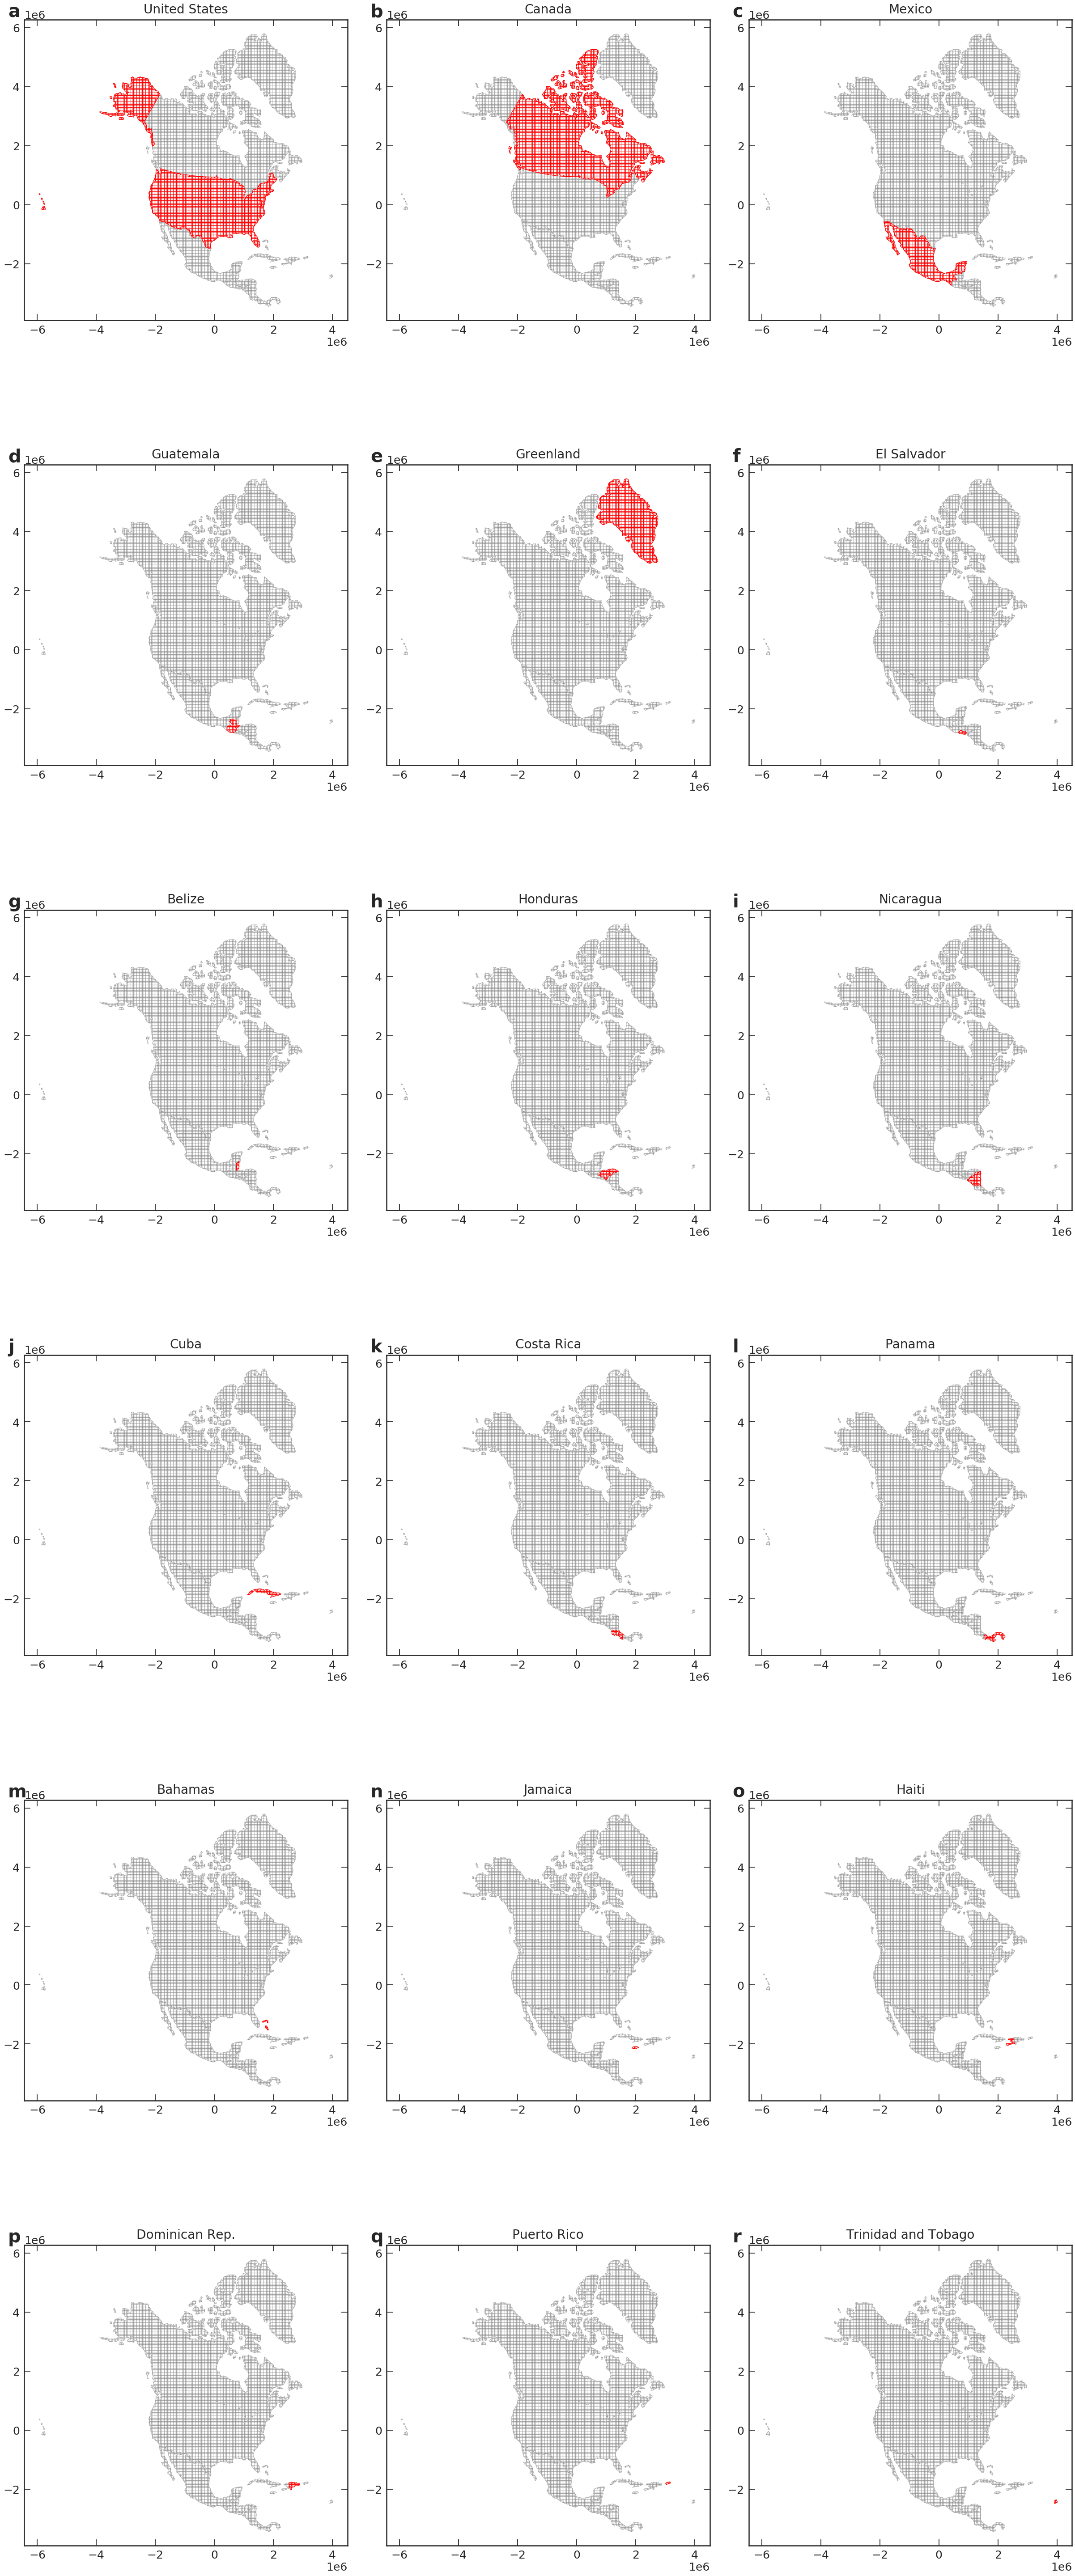

In [1006]:
ny, nx = 6, 3
fig, ax = plt.subplots(6, 3, figsize=stdfigsize(scale=2, ny=ny, nx=nx, ratio=0.8))

fs_label = 40
x, y, c = 0, 0, 0

kwargs = {'color': 'white', 'edgecolor': 'grey', 'alpha': 0.5}
for country in north_america_countries:
    if x == nx:
        x = 0 
        y += 1
    
    # plot the grids
    grids_5050_within_north_america_dissolved.plot(ax=ax[y,x], **kwargs)
    grids_5050_within_north_america_ch[grids_5050_within_north_america_ch['name'] == country].plot(ax=ax[y,x], color='white', edgecolor='red')
    
    # transform the label ticks into scientific notation
    ax[y,x].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    
    # label the graphics
    ax[y,x].annotate(string.ascii_lowercase[c], (-0.05, 1.01), xycoords='axes fraction', fontsize=fs_label, weight='bold')
    
    # put the name of the country as the title
    ax[y,x].set_title(country)
    
    x += 1
    c += 1

fig.tight_layout(pad=1.5, h_pad=-0.5, w_pad=4)

Lets compare the grids of the dissolved countries against the grids for the countries United States, Canada, and Mexico.

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


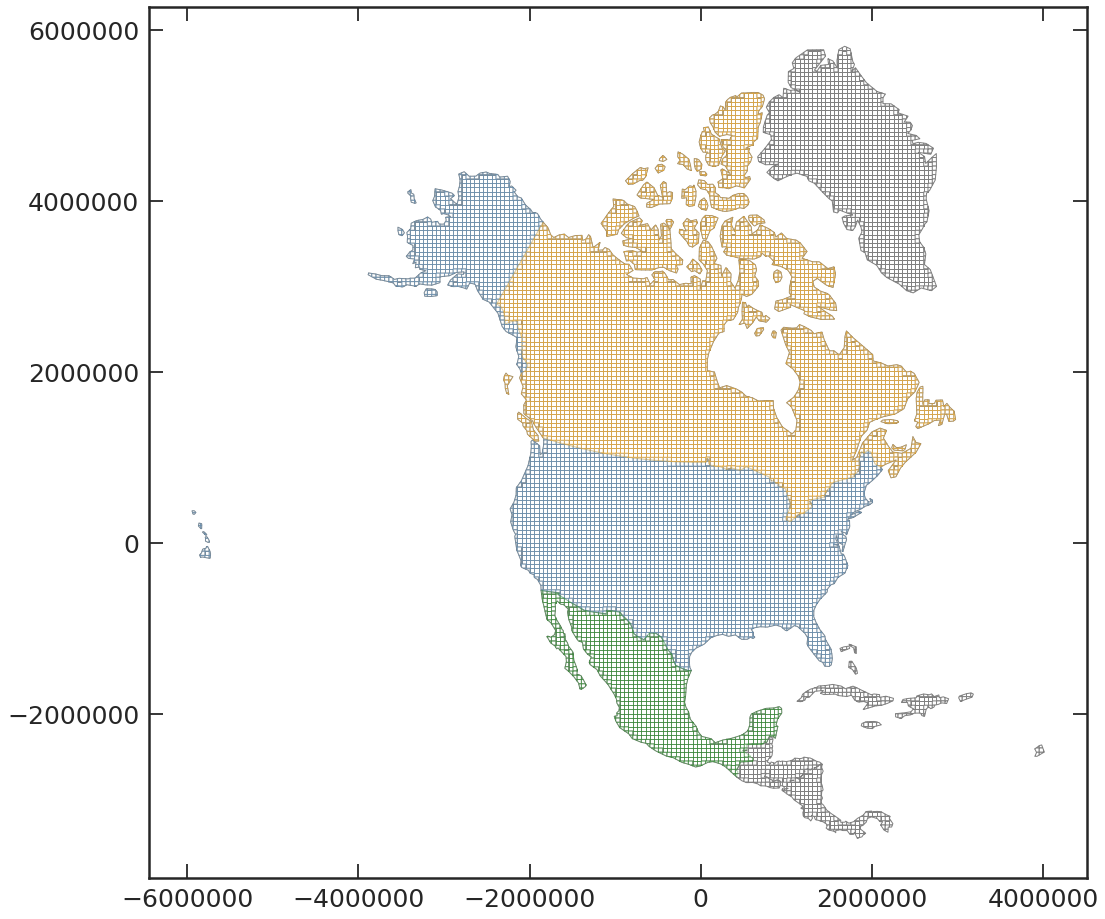

In [1010]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3, ratio=0.8))

kwargs = {'color': 'white', 'edgecolor': 'grey', 'alpha': 1}

# plot the grids
grids_5050_within_north_america_dissolved.plot(ax=ax, **kwargs)
grids_5050_within_north_america_ch[grids_5050_within_north_america_ch['name'] == 'United States'].plot(ax=ax, color='white', edgecolor='SteelBlue', alpha=0.3)
grids_5050_within_north_america_ch[grids_5050_within_north_america_ch['name'] == 'Canada'].plot(ax=ax, color='white', edgecolor='Orange', alpha=0.3)
grids_5050_within_north_america_ch[grids_5050_within_north_america_ch['name'] == 'Mexico'].plot(ax=ax, color='white', edgecolor='Green', alpha=0.3)

Observe that on the borders some grids are divided, increasing the total number. Thus, we should use the grids create from the **north_america_nad83_dissolved**.

In [1011]:
grids_5050_within_north_america_dissolved

num   pop_est     name iso_a3  gdp_md_est  \
1      218  309156.0  Bahamas    BHS      9093.0   
2       -1  309156.0  Bahamas    BHS      9093.0   
14      -1  309156.0  Bahamas    BHS      9093.0   
15      -1  309156.0  Bahamas    BHS      9093.0   
21     217  309156.0  Bahamas    BHS      9093.0   
...    ...       ...      ...    ...         ...   
23876  211  309156.0  Bahamas    BHS      9093.0   
23877   -1  309156.0  Bahamas    BHS      9093.0   
23878   -1  309156.0  Bahamas    BHS      9093.0   
23880  213  309156.0  Bahamas    BHS      9093.0   
23881   -1  309156.0  Bahamas    BHS      9093.0   

                                                geometry  
1      POLYGON ((-5902810.274196914 354657.8422120046...  
2      POLYGON ((-5938246.402936838 354657.8422120046...  
14     POLYGON ((-5844766.341318235 228448.7245230743...  
15     POLYGON ((-5869312.580437312 204657.8422120046...  
21     POLYGON ((-5844766.341318235 -127186.590458815...  
...                                                  ...  
23876  POLYGON ((3996734.126173585 -2395342.157787995...  
23877  POLYGON ((3955233.658681765 -2395342.157787995...  
23878  POLYGON ((3955233.658681765 -2445342.157787995...  
23880  POLYGON ((4014148.046796396 -2443160.161786687...  
23881  POLYGON ((4005233.658681765 -2445342.157787995...  

[11237 rows x 6 columns]

## Buffering the north_america_nad83_dissolved
<a id="buffering-the-north-america"></a>
<a href="#summary">Summary</a>

As analyzed in section 6, the number of we can have more grids occupied than the total area of the specie. This occurs because polygons of certain species extends outside the continent land. Thus, we are going to buffer the North America continent and recalcuted the grids within it.

In [1209]:
# buffer the continent in 50km distance
north_america_nad83_buffered = gpd.GeoDataFrame([north_america_nad83_dissolved['geometry'][0].buffer(50000)])
# transpose the gpd.GeoDataFrame
north_america_nad83_buffered = north_america_nad83_buffered.T
# the way I have found to transform again into a gpd.GeoDataFrame
north_america_nad83_buffered = gpd.GeoDataFrame(pd.DataFrame({'geometry': pd.Series(north_america_nad83_buffered[0])}), geometry='geometry')

We are also going to create a grid based on the countries that have the data. For instance, Central America together with Mexico does not have occurrences, thus are going to cut them off.

In [1253]:
north_america_nad83_cut_dissolved = north_america_nad83[~north_america_nad83['name'].isin(central_america_countries + ['Mexico'])].dissolve(by='continent')

And now we buffer them.

In [1263]:
# buffer the continent in 50km distance
north_america_nad83_cut_buffered = gpd.GeoDataFrame([north_america_nad83_cut_dissolved['geometry'][0].buffer(100000,resolution=50)])
# transpose the gpd.GeoDataFrame
north_america_nad83_cut_buffered = north_america_nad83_cut_buffered.T
# the way I have found to transform again into a gpd.GeoDataFrame
north_america_nad83_cut_buffered = gpd.GeoDataFrame(pd.DataFrame({'geometry': pd.Series(north_america_nad83_cut_buffered[0])}), geometry='geometry')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


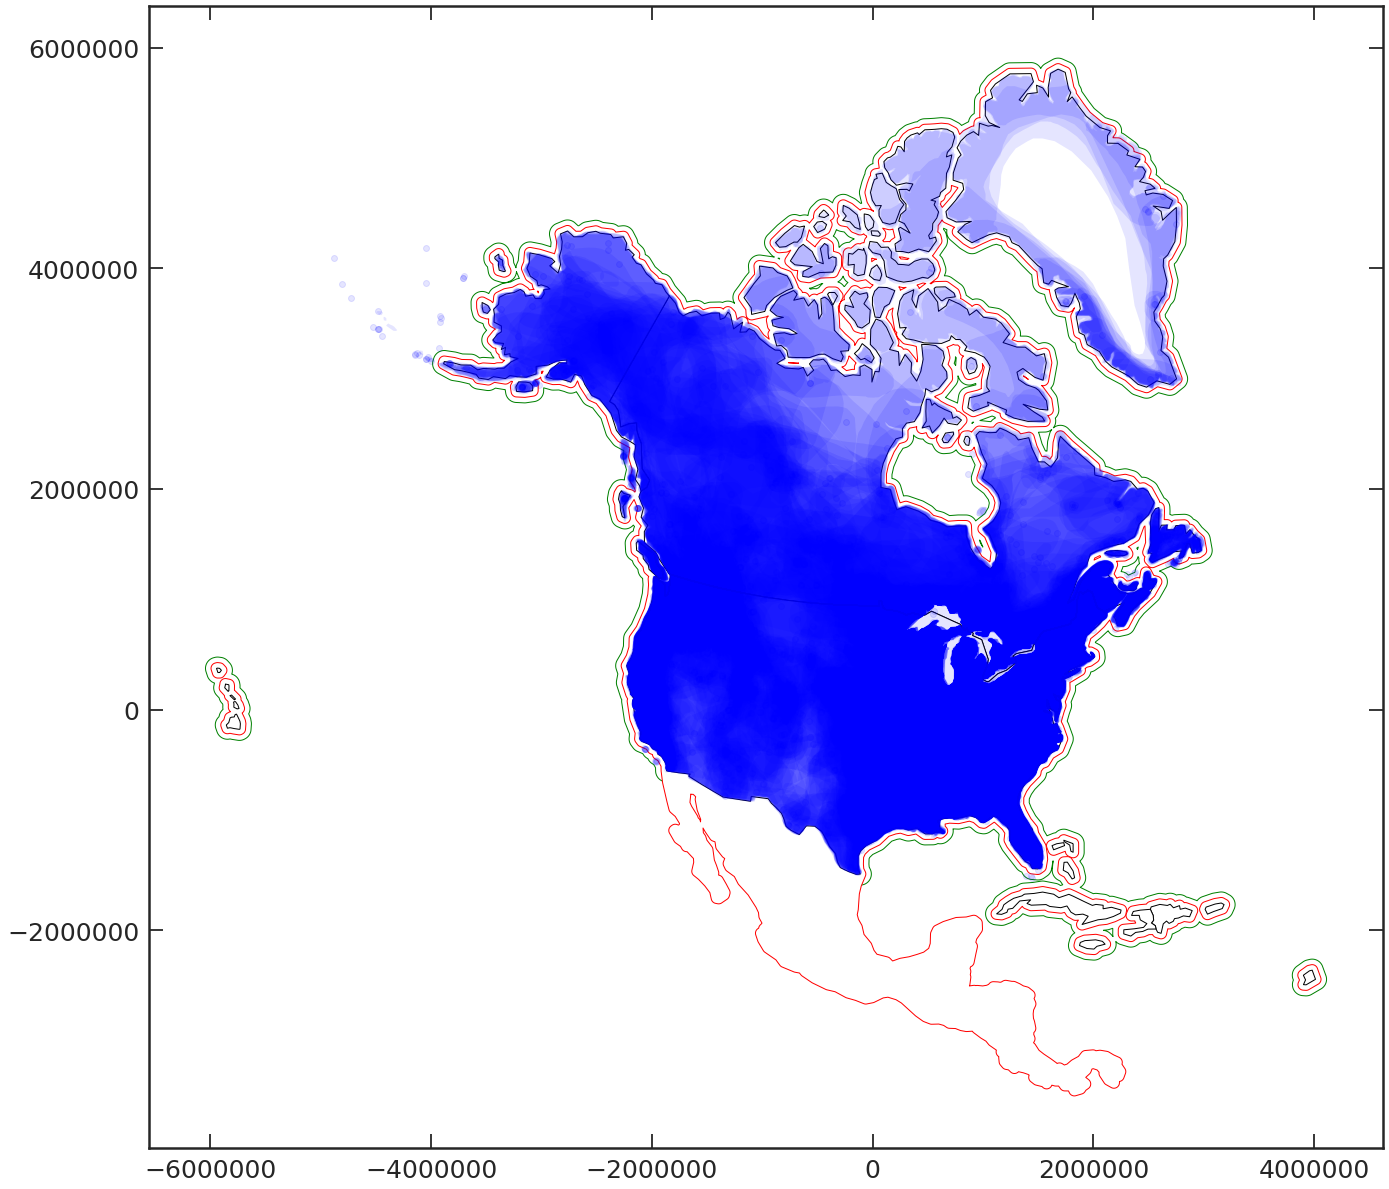

In [1264]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

north_america_nad83_cut_buffered.plot(ax=ax, color='white', edgecolor='green')
north_america_nad83_buffered.plot(ax=ax, color='white', edgecolor='red')

north_america_nad83[~(north_america_nad83['name'].isin(central_america_countries + ['Mexico']))].plot(ax=ax, color='white', edgecolor='black')


# path_details_gdf[path_details_gdf['folders'] == 'RanuHype_g'].plot(ax=ax, alpha=0.3, color='blue');
path_details_gdf['geometry'].plot(ax=ax, color='blue', alpha=0.1)

In the Figure above, the blue shaded area is the data available. In black is the natural polygon of the countries. In red we have a buffered polygon of the dissolved North America with a distance of 50km. Finally, in green, we have a buffered polygon of the dissolved North America excluding the countries from Central America and Mexico, since there is no data there. The distance employed was 100km.

Observe that the green contour includes all the data. Thus, we are going to use it to draw the grids.

In [1265]:
grids_5050_within_north_america_cut_dissolved_100km = gpd.overlay(grid_5050_ch, north_america_nad83_cut_buffered, how='intersection')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


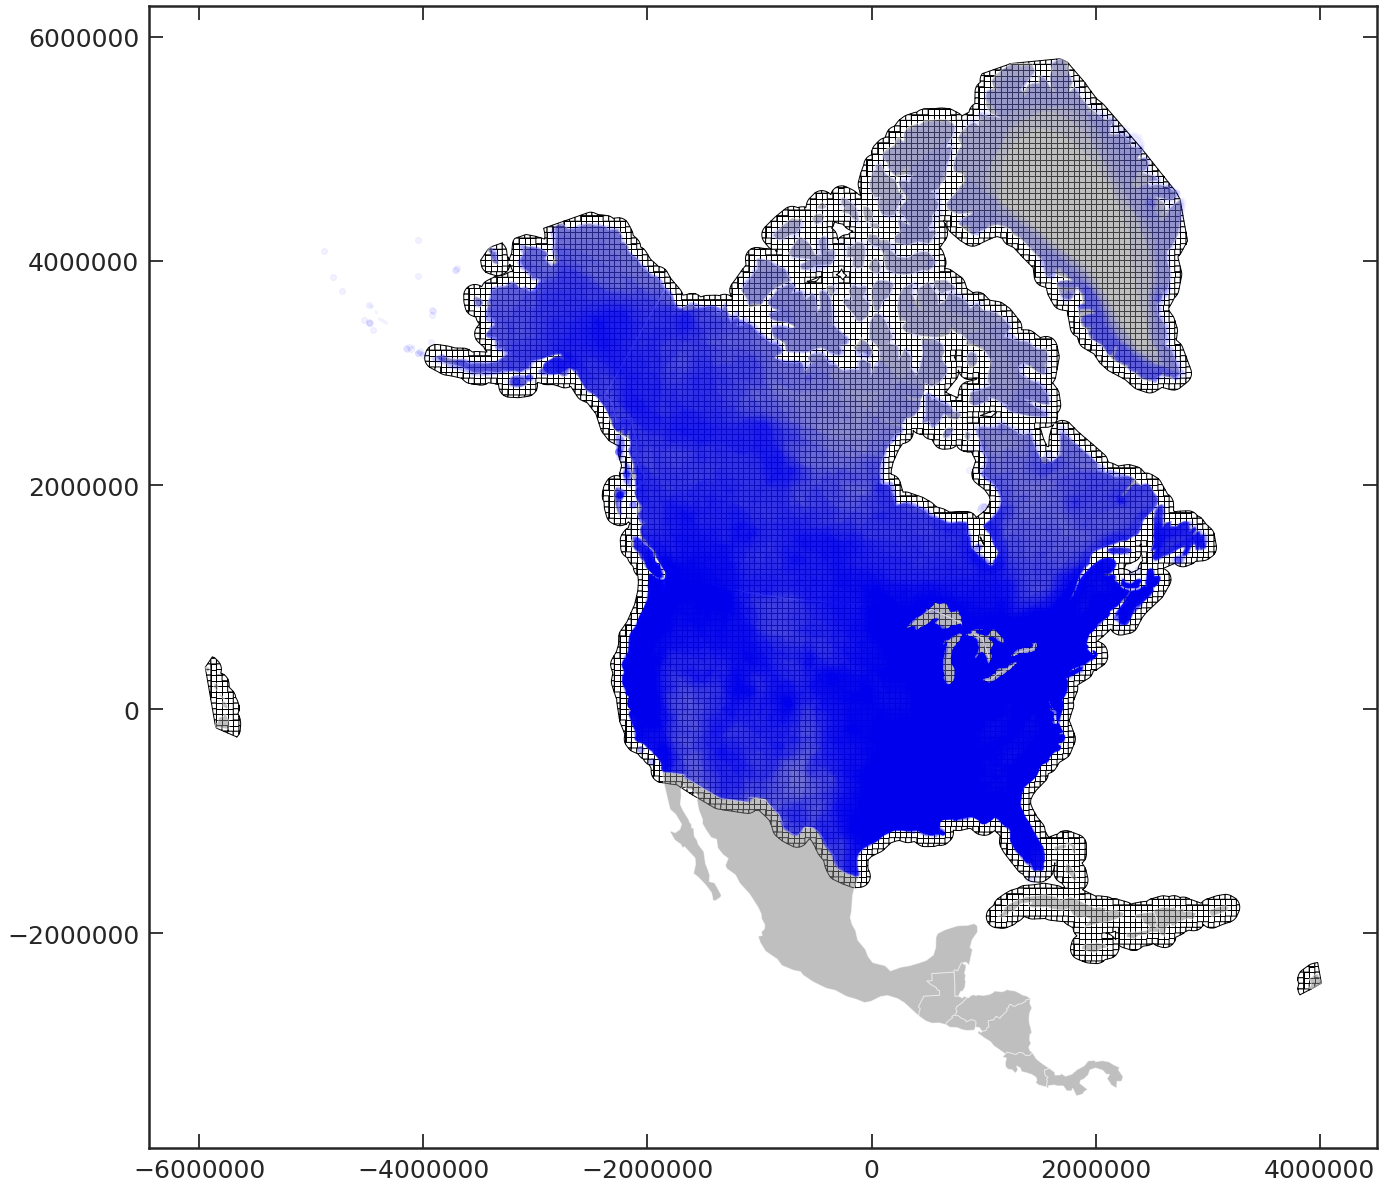

In [1267]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

grids_5050_within_north_america_cut_dissolved_100km.plot(color='white', edgecolor='black', ax=ax)
north_america_nad83.plot(color='grey', edgecolor='white', alpha=0.5, ax=ax)

path_details_gdf['geometry'].plot(ax=ax, color='blue', alpha=0.05)

In the figure above we can see that the grid create from the buffered North America without the Central America countries and Mexico with a 100km distance includes all the data. Therefore, we are going to use this grids to make the count.

# Data analysis
<a id="data-analysis"></a>
<a href="#summary">Summary</a>

## Introduction to the analysis
<a id="introduction-to-the-analysis"></a>
<a href="#summary">Summary</a>

In this section we are going to analyze the data. We are going to use the **grids_5050_within_north_america** grids, i.e., the grids of 50km² within the North America Continent.

Our goal is to calculate the number of grids that contain and do not contain the data for each specie.

To do this we are going to use the **gpd.overlay** function.

For instance, lets do an example. Take the polygons for the specie *Juncus brachyphyllus*:

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


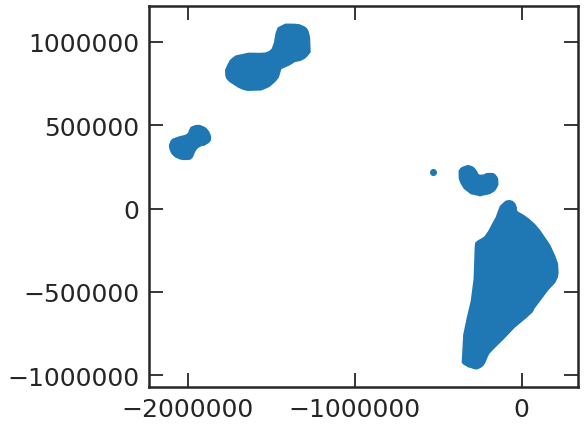

In [874]:
path_details_gdf.iloc[0:2].plot(figsize=stdfigsize());

We use the **gpd.overlay** to count the number of grids that intersect this area:

In [791]:
example_grids_with_data = gpd.overlay(path_details_gdf.iloc[1:2], grids_5050_within_north_america_ch, how='intersection')

Observe that the function only work with Polygon and Multipolygon, thus, after the number of grids occupied are retrivied, we have to add the number of points we have for that specie.

In [792]:
# number of grids occupied by the polygons
example_grids_with_data.shape[0]

279

In [831]:
def count_points(entry):
    c = 0
    try:
        for _ in entry['geometry'].iloc[0]:
            c += 1
        return c
    except:
        return 1

In [875]:
count_points(path_details_gdf.iloc[0])

1

Thus, the total number of grids occupied is:

In [735]:
279 + 1

280

Out of

In [1012]:
grids_5050_within_north_america_dissolved.shape[0]

11237

A fraction of

In [1013]:
print(280/11237, str(100*(280/11237)) + "%") 

0.024917682655513036 2.4917682655513036%


Now we are going to automatize the process.

To do this, we have to create a function that is going to count the number of grids occupied by that specie.

In [1014]:
def count_grids(entry):
    # check to see if it is a Polygon or a Multipolygon
    if str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.multipolygon.MultiPolygon'>":
        return gpd.overlay(entry, grids_5050_within_north_america_dissolved, how='intersection').shape[0]
    
    elif str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.polygon.Polygon'>":
        return gpd.overlay(entry, grids_5050_within_north_america_dissolved, how='intersection').shape[0]
    
    # check to see if it is a Point
    elif str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.point.Point'>":
        return count_points(entry['geometry'])
    
    # check to see if it is a MultiPoint
    elif str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.multipoint.MultiPoint'>":
        return count_points(entry)

We parallelize the process:

In [1015]:
pool = Pool(processes=8)
count_list = pool.map(count_grids, [path_details_gdf.iloc[i:i+1] for i in range(path_details_gdf.shape[0])])
pool.terminate()

Create a columns with the number of grids (50kmx50km) where the species was found.

In [1016]:
path_details_gdf['num_grids'] = count_list

Create a separate pd.DataFrame for the species.

In [1017]:
num_grids_per_specie = path_details_gdf[['folders', 'num_grids', 'area']].groupby('folders').sum().reset_index()

Now we count the number of non occupied grids:

In [1018]:
num_grids_per_specie['num_empty_grids'] = num_grids_per_specie['num_grids'].apply(lambda x: grids_5050_within_north_america_ch.shape[0] - x)

The pd.DataFrame for the species and the occupied grids looks like this

In [1019]:
num_grids_per_specie = num_grids_per_specie[['folders', 'num_grids', 'num_empty_grids', 'area']]
num_grids_per_specie.head()

folders  num_grids  num_empty_grids          area
0       AlisGram        999            10561  2.144365e+12
1       AlisLanc         50            11510  6.421037e+10
2  AlisPlan-aqua          1            11559  0.000000e+00
3       AlisSubc       1401            10159  3.125733e+12
4       AlisTriv       2487             9073  5.452530e+12

## Rank distribution
<a id="rank-distribution"></a>
<a href="#summary">Summary</a>

In this session we are going to use the number of occupied grids and analyze a rank distribution.

The number of grids occupied probably has a relation with the area occupied by the specie. Let's look at this just for curiosity

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


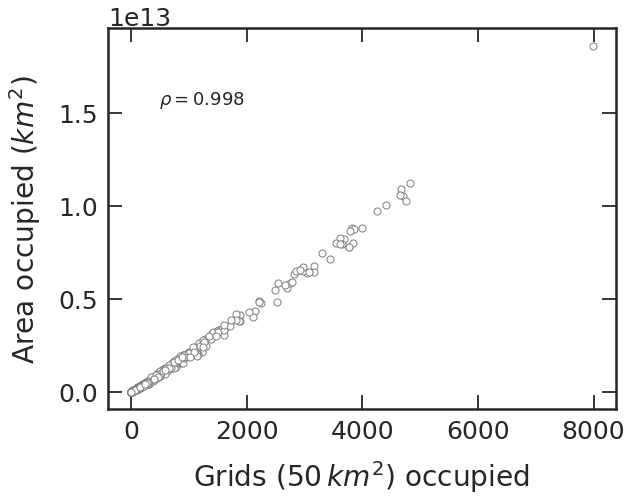

In [1020]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize())

fs_text = 18

# args to use in the graphic
kwargs = {'facecolors': 'none', 'edgecolors': 'grey', 'color': 'white', 's': 50}

# plot the number of grids occupied vs the total area the species occupy
num_grids_per_specie.plot.scatter('num_grids', 'area', ax=ax, **kwargs)

ax.set_xlabel('Grids ($50\,km^2$) occupied');
ax.set_ylabel('Area occupied ($km^2$)');

ax.annotate("$\\rho = $" + str(round(scipy.stats.pearsonr(num_grids_per_specie['num_grids'], num_grids_per_specie['area'])[0], 3)),
            (0.1, 0.8), xycoords='axes fraction', fontsize=fs_text);

As we can see, the number of grids occupied and the area have a linear correlation with Pearson coefficient equal to 0.998, indicating a very strong positive linear behavior. Which was expected.

Observe that we can rank the species by the number of grids and the total area occupied. It will be slightly different, as can be seen in the example bellow.

In [1021]:
# rank by the number of grids occupied
num_grids_per_specie.sort_values('num_grids', ascending=False).head()

folders  num_grids  num_empty_grids          area
36   EquiArve_g       7983             3577  1.859677e+13
19   CeraDeme_g       4823             6737  1.121446e+13
259  RanuHype_g       4750             6810  1.022689e+13
105    JuncBufo       4712             6848  1.050391e+13
37   EquiFluv_g       4673             6887  1.087800e+13

In [1022]:
# rank by the area occupied
num_grids_per_specie.sort_values('area', ascending=False).head()

folders  num_grids  num_empty_grids          area
36   EquiArve_g       7983             3577  1.859677e+13
19   CeraDeme_g       4823             6737  1.121446e+13
37   EquiFluv_g       4673             6887  1.087800e+13
252  RanuCymb_g       4647             6913  1.057342e+13
105    JuncBufo       4712             6848  1.050391e+13

Observe that there is a slightly difference in the order of species. The third on the distribution, ranking by the grids is *RanuHype_g* while ranking by area gives the specie *EquiFluv_g*. This occurs because we counted a grid when one point has in it and some species has more points than the other and the points has zero area. And, as we can see bellow, some species have more points than others, increasing the number of grids occupied but not the total area:

In [1023]:
# has 11 points
path_details_gdf[path_details_gdf['folders'] == 'RanuHype_g']

folders                   files  \
244  RanuHype_g    RanuHype_point_g.shp   
245  RanuHype_g  RanuHype_polygon_g.shp   

                                            paths  \
244    Shapefilet/RanuHype_g/RanuHype_point_g.shp   
245  Shapefilet/RanuHype_g/RanuHype_polygon_g.shp   

                                              geometry          area  \
244  (POINT (-4808392.496537975 3853853.71670826), ...  0.000000e+00   
245  (POLYGON ((-754306.4965832559 125674.312081243...  1.022689e+13   

     num_grids  
244          8  
245       4742

In [1024]:
# has two points
path_details_gdf[path_details_gdf['folders'] == 'EquiFluv_g']

folders                   files  \
358  EquiFluv_g  EquiFluv_polygon_g.shp   
359  EquiFluv_g    EquiFluv_point_g.shp   

                                            paths  \
358  Shapefilet/EquiFluv_g/EquiFluv_polygon_g.shp   
359    Shapefilet/EquiFluv_g/EquiFluv_point_g.shp   

                                              geometry          area  \
358  (POLYGON ((-2157222.271584167 1999500.63725855...  1.087800e+13   
359  (POINT (-2301991.058908916 4038031.856043571),...  0.000000e+00   

     num_grids  
358       4671  
359          2

As we can see, *RanuHype_g* has more points than *EquiFluv_g*. However, the number of points is not enough to make a great difference between the number of grids occupied. Moreover, the area occupied by the *EquiFluv* is bigger than the one occupied by the *RanuHype_g* and yet it is covers a smaller number of grids. We should look into this issue. To do this, we are going to plot the area of both species in the North America continent, together with the grids, and see what is going on.

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


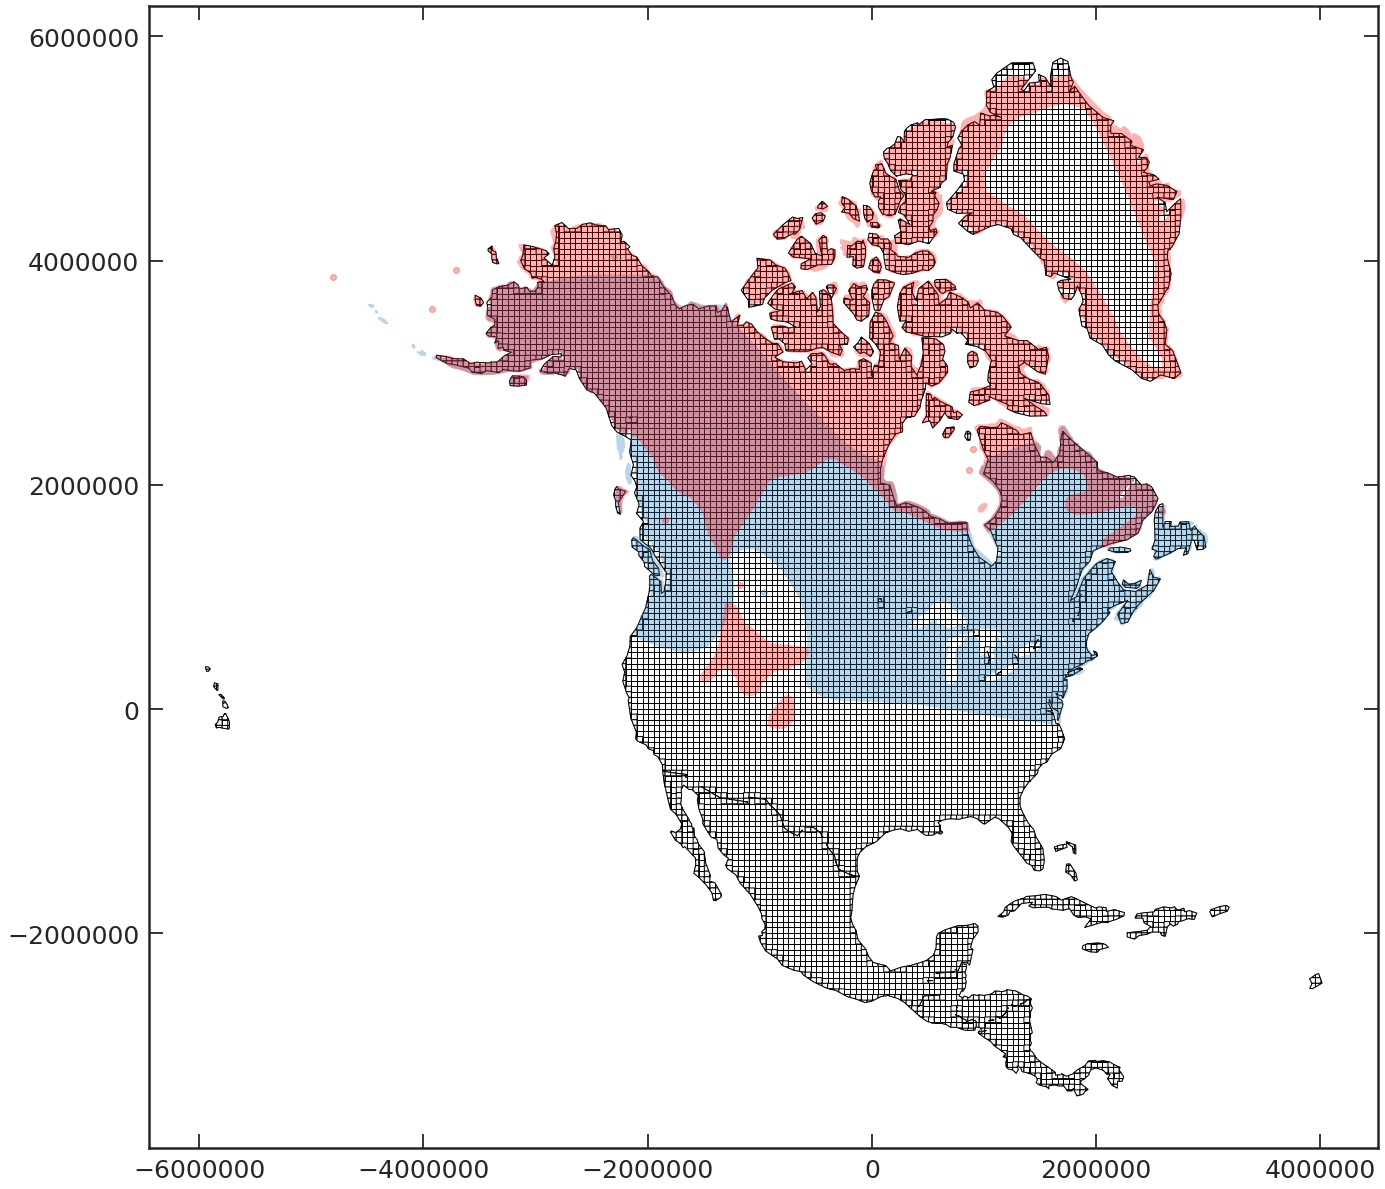

In [1026]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3));

# plot the North America map
north_america_nad83.plot(ax=ax, alpha=1, color='grey', edgecolor='grey');


# Plot the grids
grids_5050_within_north_america_dissolved.plot(color='white', edgecolor='black', ax=ax);

# plot the polygons for the species mentioned above
path_details_gdf[path_details_gdf['folders'] == 'EquiFluv_g'].plot(ax=ax, alpha=0.3);
path_details_gdf[path_details_gdf['folders'] == 'RanuHype_g'].plot(ax=ax, alpha=0.3, color='red');

As we can observe, the blue and red areas exceed the boundaries of the grids. Thus, we should apply a buffer into the **north_america_nad83_dissolved** and recreate the grids within this buffered polygon.

\*\*\* **See section 4.1** \*\*\*

In [895]:
rank_grid_df = pd.DataFrame(OrderedDict({'rank': np.arange(1, num_grids_per_specie.shape[0] + 1),
                                   'num_grids': num_grids_per_specie['num_grids'].sort_values(ascending=False)
                                  }))

We also create a column for the normalized values of grids occupied.

In [899]:
rank_df['num_grids_norm'] = rank_df['num_grids'] / rank_df['num_grids'].max()

Now let's take a look on the distribution and see if it resembles anything.

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


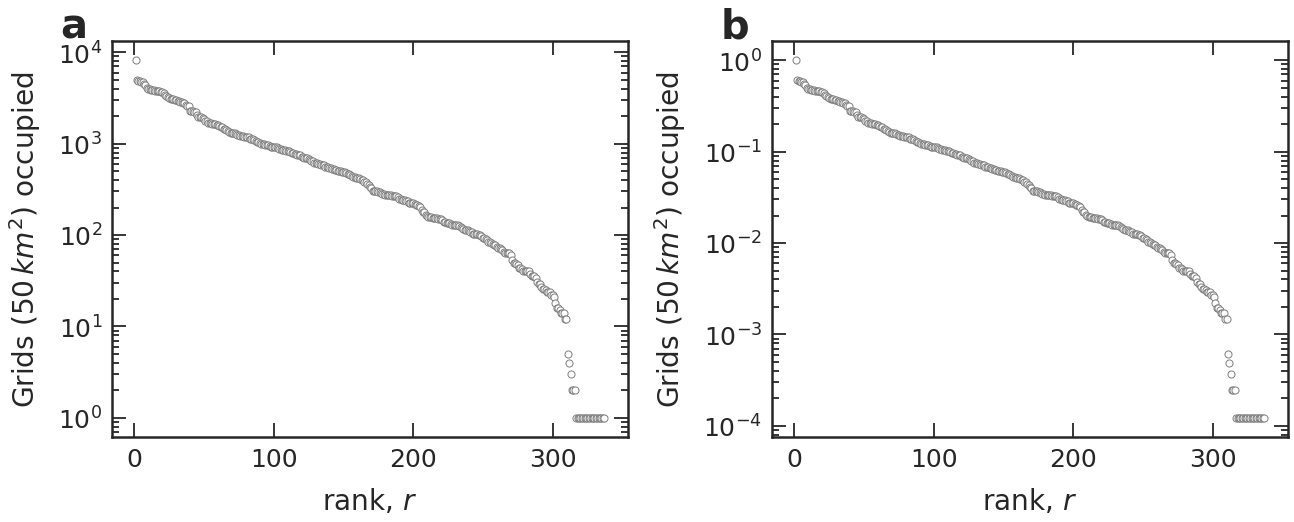

In [911]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(scale=1, ny=1, nx=2))

fs_label = 40

# label the graphics
[ax[c].annotate(string.ascii_lowercase[c], (-0.1, 1.01), xycoords='axes fraction', fontsize=fs_label, weight='bold') for c in range(2)]

# args for the plots
kwargs = {'logy': True, 'facecolors': 'none', 'edgecolors': 'grey', 'color': 'white', 's': 50}

# plot the original rank distribution
rank_df.plot.scatter('rank', 'num_grids', ax=ax[0], **kwargs)# logy=True, facecolor='none', color='grey')

# plot the normalized rank distribution
rank_df.plot.scatter('rank', 'num_grids_norm', ax=ax[1], **kwargs)# logy=True, facecolor='none', color='grey')

# labels
for c in range(2):
    ax[c].set_xlabel('rank, $r$');
    ax[c].set_ylabel('Grids ($50\,km^2$) occupied');
    
fig.tight_layout(pad=1.5, h_pad=2.5, w_pad=2.5)

As we can see from the figure above, it looks like that the rank distribution for the number of occupied grids follows an exponential decay.

Now we are going to try to fit it for an exponential distribution.

In [1348]:
def exp_dist(x, A, gamma):
    return A*np.exp(-gamma*x)

In [1354]:
def str_exp_dist(x, A, gamma, b):
    return A*np.exp(-gamma*(x**b))

In [1349]:
rank_df.head(3)

rank  num_grids  num_grids_norm
36      1       8187        1.000000
19      2       4986        0.609014
105     3       4864        0.594113

In [1384]:
rank_df.shape[0]

337

In [1390]:
fit_exp = nlfit(rank_df[(rank_df['rank'] >= 2) & (rank_df['rank'] <= 337)]['num_grids_norm'], exp_dist)
exp_fit_df = pd.DataFrame([[x, exp_dist(x, fit_exp[0][0], fit_exp[0][1])] for x in np.arange(0,rank_df.shape[0]+1)], columns=['x', 'fit'])

fit_str_exp = nlfit(rank_df[(rank_df['rank'] >= 2) & (rank_df['rank'] <= 337)]['num_grids_norm'], str_exp_dist)
str_exp_fit_df = pd.DataFrame([[x, str_exp_dist(x, fit_str_exp[0][0], fit_str_exp[0][1], fit_str_exp[0][2])] for x in np.arange(0,rank_df.shape[0]+1)], columns=['x', 'fit'])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


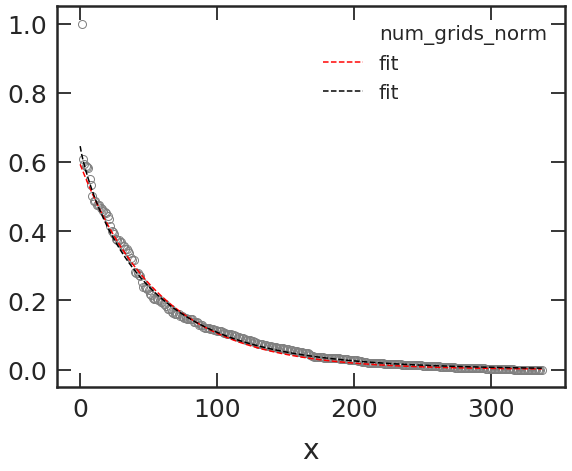

In [1391]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize())

# args to use in the graphic
kwargs = {'lw': 0, 'markerfacecolor': 'None', 'ms': 8, 'marker': 'o', 'markeredgecolor': 'grey', 'markeredgewidth': 1}

# plot the data
rank_df.plot('rank', 'num_grids_norm', ax=ax, **kwargs)

# plot the fit
exp_fit_df.plot('x', 'fit', ax=ax, ls='--', c='red')
str_exp_fit_df.plot('x', 'fit', ax=ax, ls='--', c='black')
# beta_like_fit_df.plot('x', 'fit', ax=ax, ls='--', c='blue')

# ax.set_yscale('log')
# ax.set_xscale('log')

## Rank distribution after buffering (look end of section 4.1)
<a id="rank-distribution-after-buffering"></a>
<a href="#summary">Summary</a>

We recreate the steps at the end of section 5.1.

First, we have to redefine the function **count_grids** to consider the **grids_5050_within_north_america_cut_dissolved_100km** to find the intersections.

In [1268]:
def count_grids(entry):
    # check to see if it is a Polygon or a Multipolygon
    if str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.multipolygon.MultiPolygon'>":
        return gpd.overlay(entry, grids_5050_within_north_america_cut_dissolved_100km, how='intersection').shape[0]
    
    elif str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.polygon.Polygon'>":
        return gpd.overlay(entry, grids_5050_within_north_america_cut_dissolved_100km, how='intersection').shape[0]
    
    # check to see if it is a Point
    elif str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.point.Point'>":
        return count_points(entry['geometry'])
    
    # check to see if it is a MultiPoint
    elif str(type(entry['geometry'].iloc[0])) == "<class 'shapely.geometry.multipoint.MultiPoint'>":
        return count_points(entry)

Now we can perform the grid count.

In [1269]:
# count the number of grids that has data within for each specie.
pool = Pool(processes=8)
count_list_cut_dissolved_100km = pool.map(count_grids, [path_details_gdf.iloc[i:i+1] for i in range(path_details_gdf.shape[0])])
pool.terminate()

Create a columns with the number of grids (50kmx50km) where the species was found.

In [1270]:
path_details_gdf['num_grids'] = count_list_cut_dissolved_100km

Create a separate pd.DataFrame for the species.

In [1271]:
num_grids_per_specie_cut_dissolved_100km = path_details_gdf[['folders', 'num_grids', 'area']].groupby('folders').sum().reset_index()

Now we count the number of non occupied grids:

In [1272]:
num_grids_per_specie_cut_dissolved_100km['num_empty_grids'] = num_grids_per_specie_cut_dissolved_100km['num_grids'].apply(lambda x: grids_5050_within_north_america_cut_dissolved_100km.shape[0] - x)

The pd.DataFrame for the species and the occupied grids looks like this

In [1273]:
num_grids_per_specie_cut_dissolved_100km = num_grids_per_specie_cut_dissolved_100km[['folders', 'num_grids', 'num_empty_grids', 'area']]
num_grids_per_specie_cut_dissolved_100km.head()

folders  num_grids  num_empty_grids          area
0       AlisGram        999            11337  2.144365e+12
1       AlisLanc         50            12286  6.421037e+10
2  AlisPlan-aqua          1            12335  0.000000e+00
3       AlisSubc       1404            10932  3.125733e+12
4       AlisTriv       2492             9844  5.452530e+12

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


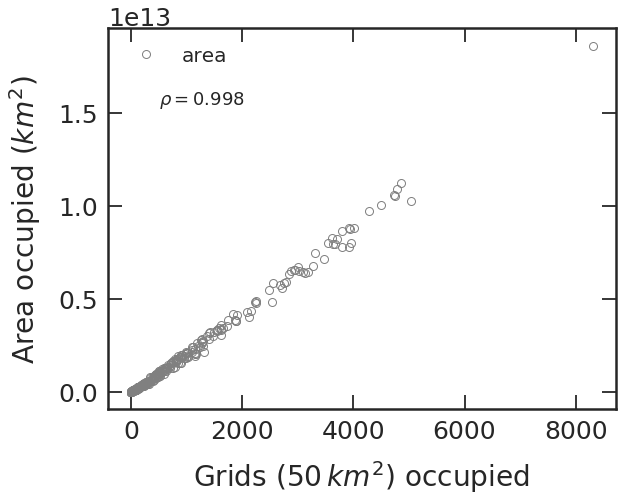

In [1300]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize())

fs_text = 18

# args to use in the graphic
kwargs = {'lw': 0, 'markerfacecolor': 'None', 'ms': 8, 'marker': 'o', 'markeredgecolor': 'grey', 'markeredgewidth': 1}

# plot the number of grids occupied vs the total area the species occupy
num_grids_per_specie_cut_dissolved_100km.plot('num_grids', 'area', ax=ax, **kwargs)

ax.set_xlabel('Grids ($50\,km^2$) occupied');
ax.set_ylabel('Area occupied ($km^2$)');

ax.annotate("$\\rho = $" + str(round(scipy.stats.pearsonr(num_grids_per_specie_cut_dissolved_100km['num_grids'], num_grids_per_specie_cut_dissolved_100km['area'])[0], 3)),
            (0.1, 0.8), xycoords='axes fraction', fontsize=fs_text);

Finally we can do the rank pd.DataFrame.

In [1277]:
num_grids_per_specie_cut_dissolved_100km.sort_values('num_grids', ascending=False).head()

folders  num_grids  num_empty_grids          area
36   EquiArve_g       8302             4034  1.859677e+13
259  RanuHype_g       5033             7303  1.022689e+13
19   CeraDeme_g       4857             7479  1.121446e+13
37   EquiFluv_g       4790             7546  1.087800e+13
105    JuncBufo       4744             7592  1.050391e+13

In [1278]:
path_details_gdf[path_details_gdf['folders'] == 'RanuHype_g']

folders                   files  \
244  RanuHype_g    RanuHype_point_g.shp   
245  RanuHype_g  RanuHype_polygon_g.shp   

                                            paths  \
244    Shapefilet/RanuHype_g/RanuHype_point_g.shp   
245  Shapefilet/RanuHype_g/RanuHype_polygon_g.shp   

                                              geometry          area  \
244  (POINT (-4808392.496537975 3853853.71670826), ...  0.000000e+00   
245  (POLYGON ((-754306.4965832559 125674.312081243...  1.022689e+13   

     num_grids  
244          8  
245       5025

In [1279]:
path_details_gdf[path_details_gdf['folders'] == 'CeraDeme_g']

folders           files                                 paths  \
112  CeraDeme_g  CeraDeme_g.shp  Shapefilet/CeraDeme_g/CeraDeme_g.shp   

                                              geometry          area  \
112  (POLYGON ((2236329.949586485 1177057.529093927...  1.121446e+13   

     num_grids  
112       4857

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


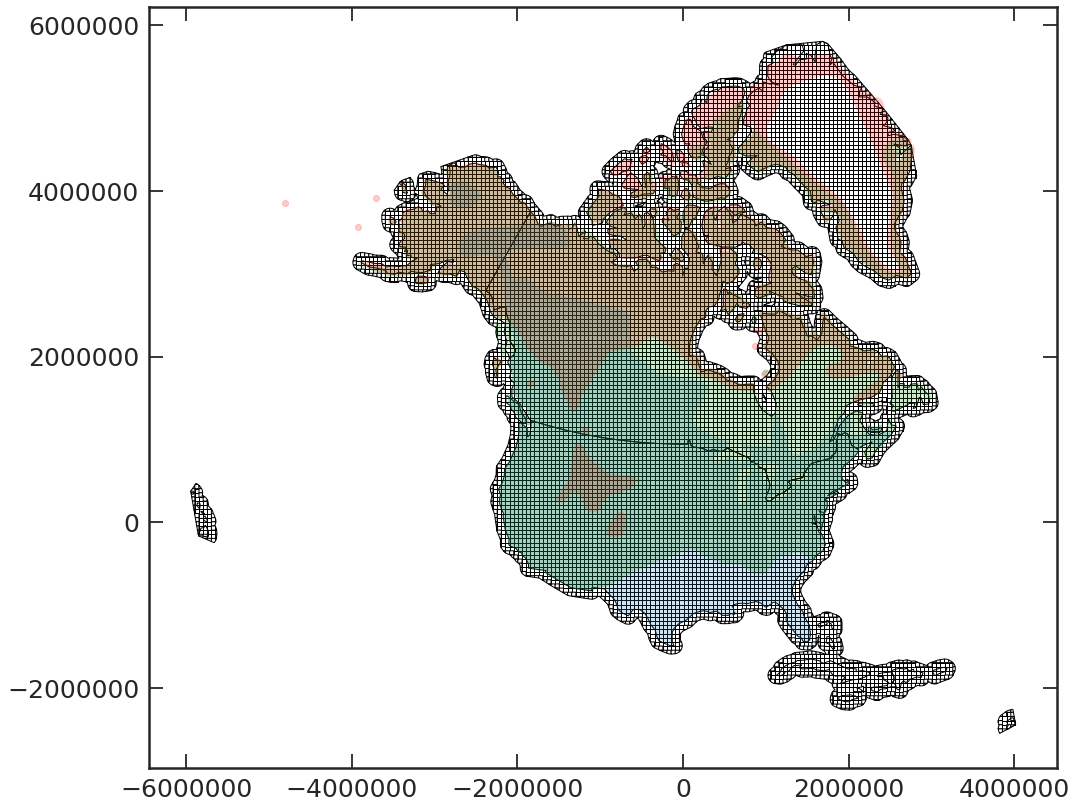

In [1320]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=2))

grids_5050_within_north_america_cut_dissolved_100km.plot(ax=ax, color='white', edgecolor='black')

north_america_nad83[~north_america_nad83['name'].isin(central_america_countries + ['Mexico'])].plot(facecolor='None', edgecolor='black', ax=ax)
path_details_gdf[path_details_gdf['folders'] == 'CeraDeme_g'].plot(ax=ax, alpha=0.2)
path_details_gdf[path_details_gdf['folders'] == 'RanuHype_g'].plot(ax=ax, alpha=0.2, color='red')
path_details_gdf[path_details_gdf['folders'] == 'EquiArve_g'].plot(ax=ax, alpha=0.2, color='green')

In [1392]:
rank_grid_cut_dissolved_df = pd.DataFrame(OrderedDict({'rank': np.arange(1, num_grids_per_specie_cut_dissolved_100km.shape[0] + 1),
                                   'num_grids': num_grids_per_specie_cut_dissolved_100km['num_grids'].sort_values(ascending=False)
                                  }))

We also create a column for the normalized values of grids occupied.

In [1393]:
rank_grid_cut_dissolved_df['num_grids_norm'] = rank_grid_cut_dissolved_df['num_grids'] / rank_grid_cut_dissolved_df['num_grids'].max()

Now let's take a look on the distribution and see if it resembles anything.

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


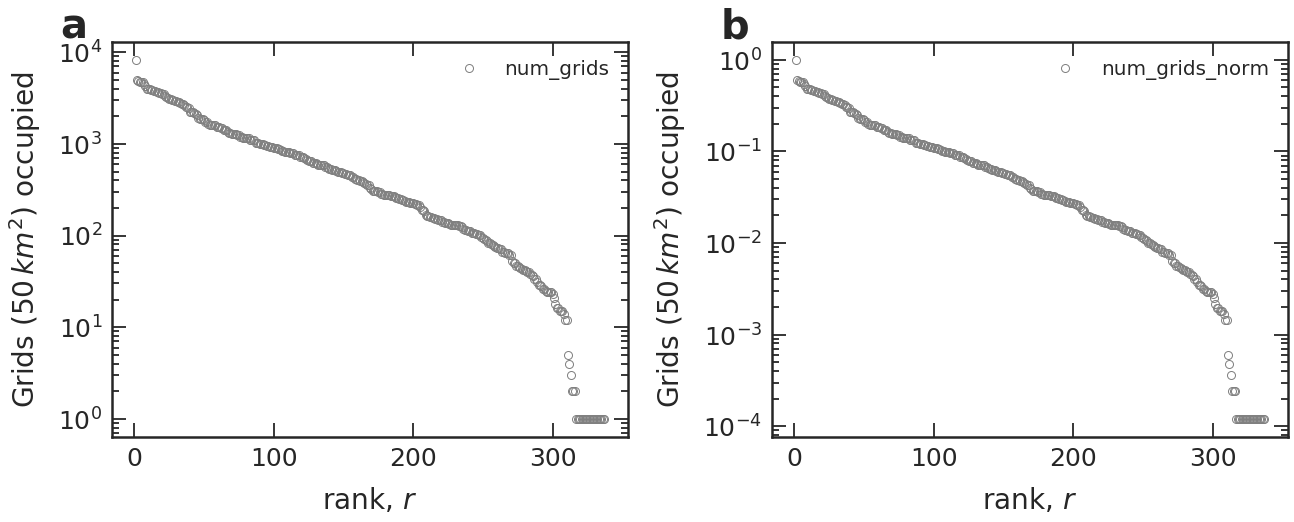

In [1397]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(scale=1, ny=1, nx=2))

fs_label = 40

# label the graphics
[ax[c].annotate(string.ascii_lowercase[c], (-0.1, 1.01), xycoords='axes fraction', fontsize=fs_label, weight='bold') for c in range(2)]

# args to use in the graphic
kwargs = {'lw': 0, 'markerfacecolor': 'None', 'ms': 8, 'marker': 'o', 'markeredgecolor': 'grey', 'markeredgewidth': 1, 'logy': True}


# plot the original rank distribution
rank_grid_cut_dissolved_df.plot('rank', 'num_grids', ax=ax[0], **kwargs)# logy=True, facecolor='none', color='grey')

# plot the normalized rank distribution
rank_grid_cut_dissolved_df.plot('rank', 'num_grids_norm', ax=ax[1], **kwargs)# logy=True, facecolor='none', color='grey')

# labels
for c in range(2):
    ax[c].set_xlabel('rank, $r$');
    ax[c].set_ylabel('Grids ($50\,km^2$) occupied');
    
fig.tight_layout(pad=1.5, h_pad=2.5, w_pad=2.5)

As we can see from the figure above, it looks like that the rank distribution for the number of occupied grids follows an exponential decay.

Now we are going to try to fit it for an exponential distribution.

In [1399]:
rank_grid_cut_dissolved_df.head(3)

rank  num_grids  num_grids_norm
36      1       8302        1.000000
259     2       5033        0.606239
19      3       4857        0.585040

In [1400]:
rank_grid_cut_dissolved_df.shape[0]

337

In [1401]:
fit_exp = nlfit(rank_grid_cut_dissolved_df[(rank_grid_cut_dissolved_df['rank'] >= 2) & (rank_grid_cut_dissolved_df['rank'] <= 337)]['num_grids_norm'], exp_dist)
exp_fit_df = pd.DataFrame([[x, exp_dist(x, fit_exp[0][0], fit_exp[0][1])] for x in np.arange(0,rank_grid_cut_dissolved_df.shape[0]+1)], columns=['x', 'fit'])

fit_str_exp = nlfit(rank_grid_cut_dissolved_df[(rank_grid_cut_dissolved_df['rank'] >= 2) & (rank_grid_cut_dissolved_df['rank'] <= 337)]['num_grids_norm'], str_exp_dist)
str_exp_fit_df = pd.DataFrame([[x, str_exp_dist(x, fit_str_exp[0][0], fit_str_exp[0][1], fit_str_exp[0][2])] for x in np.arange(0,rank_grid_cut_dissolved_df.shape[0]+1)], columns=['x', 'fit'])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


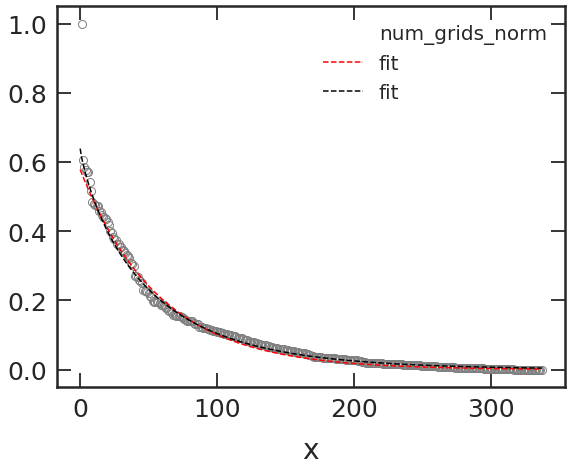

In [1402]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize())

# args to use in the graphic
kwargs = {'lw': 0, 'markerfacecolor': 'None', 'ms': 8, 'marker': 'o', 'markeredgecolor': 'grey', 'markeredgewidth': 1}

# plot the data
rank_grid_cut_dissolved_df.plot('rank', 'num_grids_norm', ax=ax, **kwargs)

# plot the fit
exp_fit_df.plot('x', 'fit', ax=ax, ls='--', c='red')
str_exp_fit_df.plot('x', 'fit', ax=ax, ls='--', c='black')
# beta_like_fit_df.plot('x', 'fit', ax=ax, ls='--', c='blue')

# ax.set_yscale('log')
# ax.set_xscale('log')

Observe that the rank distribution of grids occupied looks quite the same for the buffered polygon and the non buffered.

# Count the number of species within each grid
<a id="count-the-number-of-species"></a>
<a href="#summary">Summary</a>

## Grids $50km^2$
<a id="grids-50-km"></a>
<a href="#summary">Summary</a>

In this section we are going to consider the North America without the Central America countries and Mexico. We are going to create a grid of $50 km^2$ each and count the number of species that has occurrences in that area.

First, we have to create a square fishnet that includes the North America.

In [73]:
grid_5050_north_america_cut_sq = fishnet(
    pd.concat([polygon_border_coords(north_america_nad83['geometry'].iloc[i], xlim=[-6000000,3500000], ylim=[-1600000,6000000]) for i in range(north_america_nad83.shape[0])]).reset_index(drop=True),
    width=50000, height=50000)

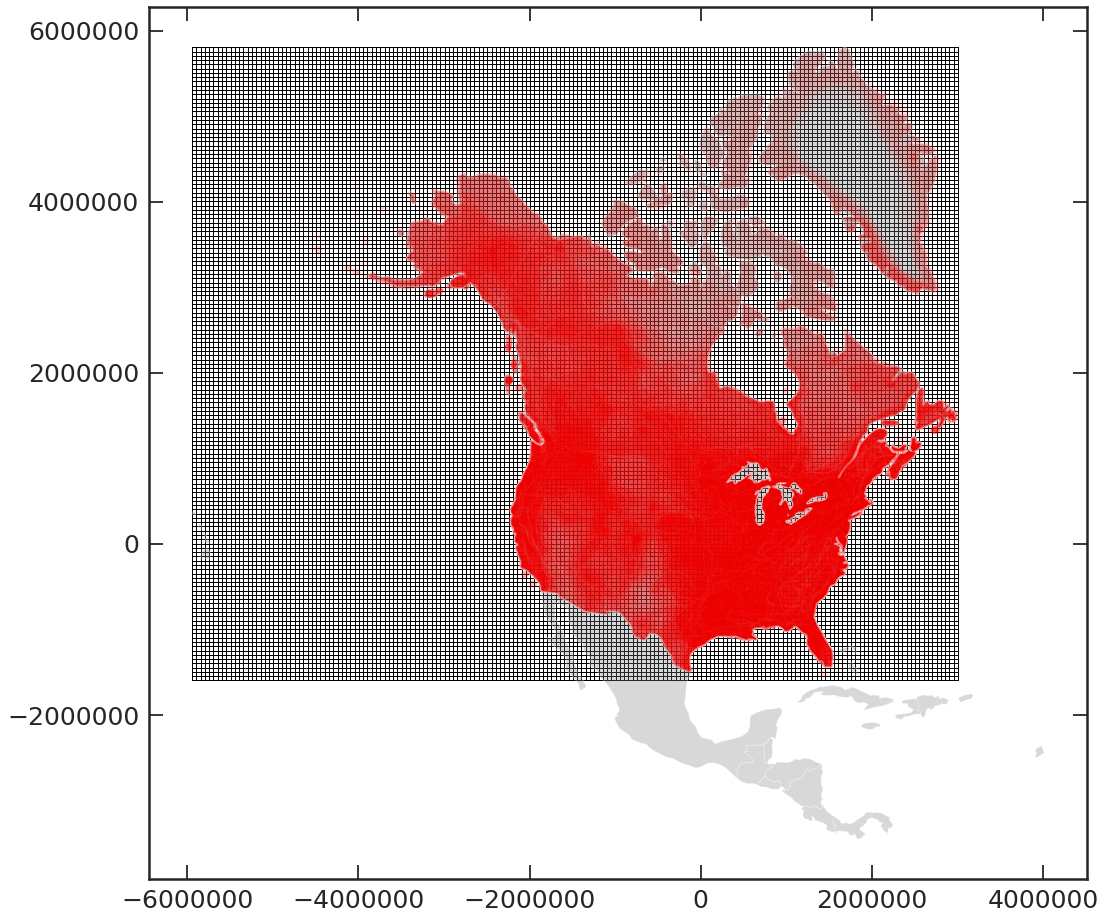

In [74]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3, ratio=0.8))

grid_5050_north_america_cut_sq.plot(ax=ax, color='white', edgecolor='black')
north_america_nad83.plot(ax=ax, color='grey', edgecolor='white', alpha=0.3)
path_details_gdf['geometry'].plot(ax=ax, color='red', alpha=0.05)

The fishnet draw above is the one we are going to work with.

We have to count the number of species within each grid.

In [16]:
path_details_gdf = path_details_gdf.sort_values('folders')

In [17]:
species = path_details_gdf[path_details_gdf['area'] != 0].reset_index(drop=True)['folders']

In [18]:
north_america_sp_code_dict = {sp: n for n, sp in enumerate(species)}

In [19]:
north_america_sp_code_dict

{'AlisGram': 0,
 'AlisLanc': 1,
 'AlisSubc': 2,
 'AlisTriv': 3,
 'AzolCaro_g': 4,
 'AzolFili_g': 5,
 'AzolMexi_g': 6,
 'BlyxAube': 7,
 'BrasSchr_g': 8,
 'ButoUmbe': 9,
 'CaboCaro_g': 10,
 'CallPalu': 11,
 'CaltLept_g': 12,
 'CaltNata_g': 13,
 'CaltPalu_g': 14,
 'CannFlac': 15,
 'CannGlau': 16,
 'CeraDeme_g': 17,
 'CeraEchi_g': 18,
 'ColoEscu': 19,
 'CommComm': 20,
 'CommVirg': 21,
 'CrinAmer_var_amer': 22,
 'DamaCali': 23,
 'EchiBert': 24,
 'EchiCord_subsp_cord': 25,
 'EchiTene': 26,
 'EgerDens': 27,
 'EichCras': 28,
 'ElodBifo': 29,
 'ElodCana': 30,
 'ElodNutt': 31,
 'EquiArve_g': 32,
 'EquiFluv_g': 33,
 'EquiPalu_g': 34,
 'ErioAqua': 35,
 'ErioCine': 36,
 'ErioComp': 37,
 'ErioDeca': 38,
 'ErioKoer': 39,
 'ErioLine': 40,
 'ErioPark': 41,
 'ErioRave': 42,
 'ErioTexe': 43,
 'HaloDeci': 44,
 'HaloEnge': 45,
 'HaloJohn': 46,
 'HaloduleWrig': 47,
 'HeteDubi': 48,
 'HeteLimo': 49,
 'HeteMexi': 50,
 'HeteMult': 51,
 'HeteReni': 52,
 'HeteRotu': 53,
 'HydrMors-ranae': 54,
 'HydrVert': 55,
 '

In [78]:
polys1 = path_details_gdf[path_details_gdf['area'] != 0].reset_index(
    drop=True)['geometry']
polys2 = grid_5050_north_america_cut_sq['geometry']

species = path_details_gdf[path_details_gdf['area'] != 0].reset_index(
    drop=True)['folders']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in north_america_sp_code_dict.items()],
    'code': [n for sp, n in north_america_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

Here we calculate all the intersections.

In [79]:
intersection_grids_species_gpd = gpd.overlay(df1, df2, how='intersection')

Column df1 has all the labels from the **path_details_gdf**:

In [80]:
df1.head(2)

geometry  df1   species  code
0  (POLYGON ((1217232.010075063 466547.7992786579...    1  AlisGram     0
1  (POLYGON ((-2141318.758422129 281993.412289276...    2  AlisLanc     1

While the df2 has all the labels from the **grid_5050_north_america_cut_sq**:

In [81]:
df2.head(2)

geometry  df2
0  POLYGON ((-5944766.341318235 5804657.842212005...    1
1  POLYGON ((-5944766.341318235 5754657.842212005...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [82]:
intersection_grids_species_gpd

df1     species  code    df2  \
85        1    AlisGram     0  14591   
5908      4    AlisTriv     3  14591   
42979    14  CaltNata_g    13  14591   
49364    15  CaltPalu_g    14  14591   
61979    18  CeraDeme_g    17  14591   
...     ...         ...   ...    ...   
679252  239  RanuHype_g   238  20187   
679745  239  RanuHype_g   238  19605   
685516  239  RanuHype_g   238   8174   
704195  243  RanuPall_g   242  23157   
850131  296    TrigMari   295  20511   

                                                 geometry  
85      POLYGON ((-1044766.341318235 1504657.842212005...  
5908    POLYGON ((-1044766.341318235 1504657.842212005...  
42979   POLYGON ((-1044766.341318235 1504657.842212005...  
49364   POLYGON ((-1006038.015033893 1504657.842212005...  
61979   POLYGON ((-1044766.341318235 1504657.842212005...  
...                                                   ...  
679252  POLYGON ((880493.3326083039 2854657.842212005,...  
679745  POLYGON ((664590.0013883723 2402590.395873991,...  
685516  POLYGON ((-3144766.341318235 4110129.423870414...  
704195  POLYGON ((1855233.658681765 2361356.0369728, 1...  
850131  POLYGON ((955233.6586817652 1477769.085500382,...  

[285892 rows x 5 columns]

For instance, on the first five rows of the **intersection_grids_species_gpd** displayed above, we have that the species on the labels 1, 3, 8, 11, and 15 intersect the grid of label 16689.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [83]:
intersection_grids_species_gpd.groupby('df2').count()

df1  species  code  geometry
df2                                
4188     1        1     1         1
4189     1        1     1         1
4336     1        1     1         1
4337     1        1     1         1
4484     1        1     1         1
...    ...      ...   ...       ...
26428    1        1     1         1
26429   22       22    22        22
26430   37       37    37        37
26431   36       36    36        36
26432   31       31    31        31

[10060 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 4188 (first one on the pd.DataFrame) has 1 occurrence while the grid 26432 (last one on the pd.DataFrame) has 31 occurrences.

In [84]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

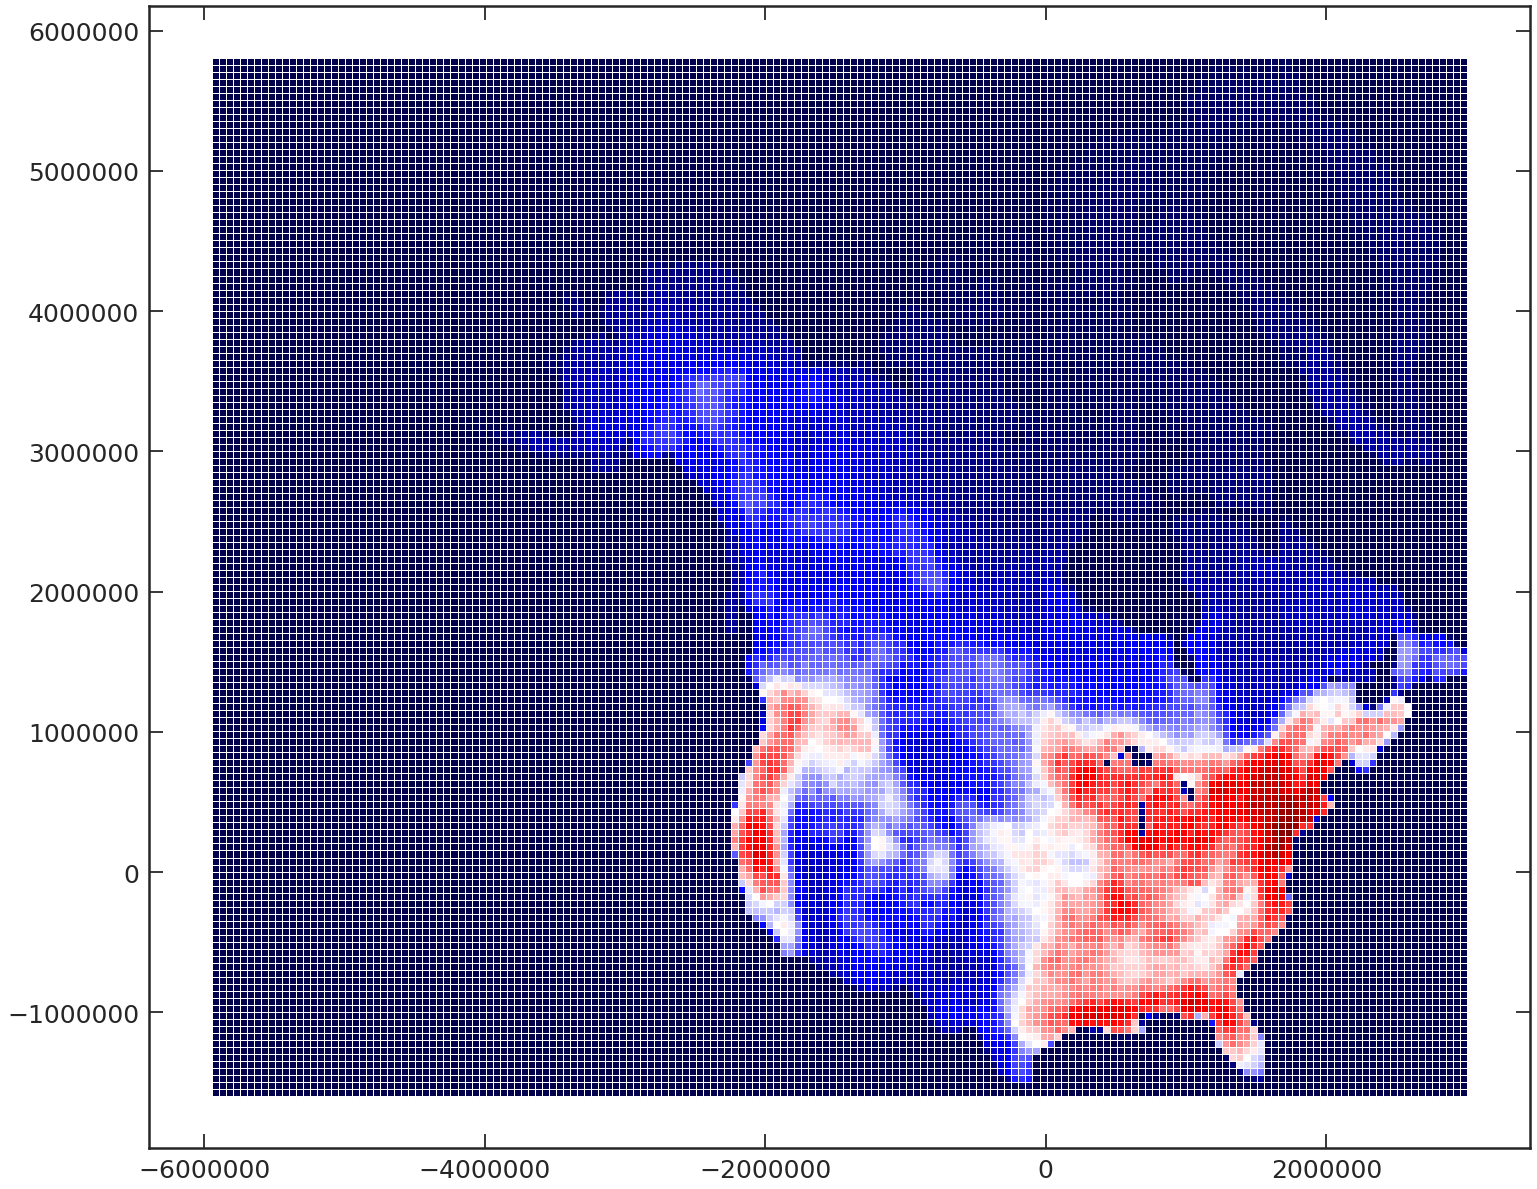

In [85]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [86]:
(pd.Series([k for k,v in north_america_sp_code_dict.items()]) == df1['species']).all()

True

In [87]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd[intersection_grids_species_gpd['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(north_america_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [88]:
df.head(3)

geometry  0_AlisGram  1_AlisLanc  \
0  POLYGON ((-5944766.341318235 5804657.842212005...         0.0         0.0   
1  POLYGON ((-5944766.341318235 5754657.842212005...         0.0         0.0   
2  POLYGON ((-5944766.341318235 5704657.842212005...         0.0         0.0   

   2_AlisSubc  3_AlisTriv  4_AzolCaro_g  5_AzolFili_g  6_AzolMexi_g  \
0         0.0         0.0           0.0           0.0           0.0   
1         0.0         0.0           0.0           0.0           0.0   
2         0.0         0.0           0.0           0.0           0.0   

   7_BlyxAube  8_BrasSchr_g      ...       300_TyphLati  301_VallAmer  \
0         0.0           0.0      ...                0.0           0.0   
1         0.0           0.0      ...                0.0           0.0   
2         0.0           0.0      ...                0.0           0.0   

   302_WolfBore  303_WolfBras  304_WolfColu  305_WolfGlob  306_WolffiellaGlad  \
0           0.0           0.0           0.0           0.0                 0.0   
1           0.0           0.0           0.0           0.0                 0.0   
2           0.0           0.0           0.0           0.0                 0.0   

   307_WolffiellaLing  308_WolffiellaOblo  309_ZannPalu  
0                 0.0                 0.0           0.0  
1                 0.0                 0.0           0.0  
2                 0.0                 0.0           0.0  

[3 rows x 311 columns]

We add a column with the total species that occurred within that grid.

In [89]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [90]:
occurrences_within_5050_grid = gpd.GeoDataFrame(df, geometry='geometry')

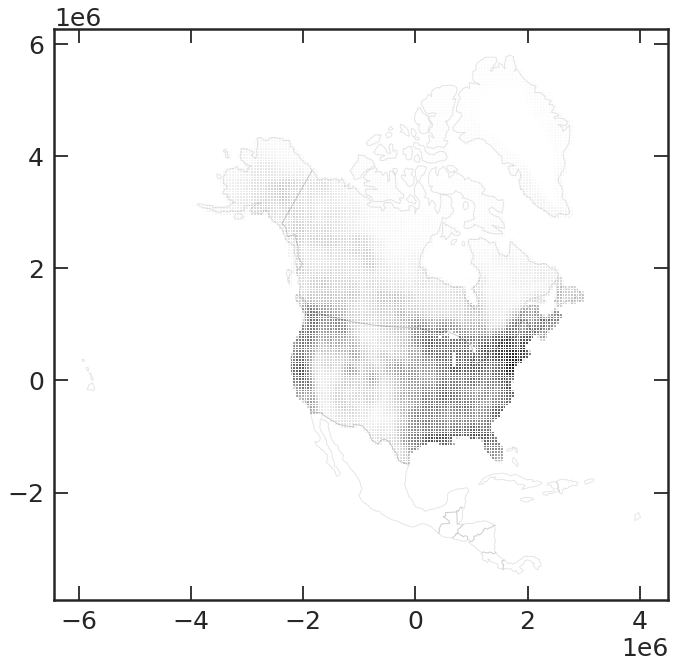

In [91]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_5050_grid[['geometry', 'Total']].plot(column='Total', cmap='Greys', ax=ax);
north_america_nad83.plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [92]:
# occurrences_within_5050_grid.to_file('../results/north_america/sp_polygon_5050/occurrences_within_5050_grid_north_america.shp')

## grids $100km^2$
<a id="grids-100-km"></a>
<a href="#summary">Summary</a>

In this section we are going to consider the North America without the Central America countries and Mexico. We are going to create a grid of $50 km^2$ each and count the number of species that has occurrences in that area.

First, we have to create a square fishnet that includes the North America.

In [51]:
grid_100100_north_america_cut_sq = fishnet(
    pd.concat([polygon_border_coords(north_america_nad83['geometry'].iloc[i], xlim=[-6000000,3500000], ylim=[-1600000,6000000]) for i in range(north_america_nad83.shape[0])]).reset_index(drop=True),
    width=100000, height=100000)

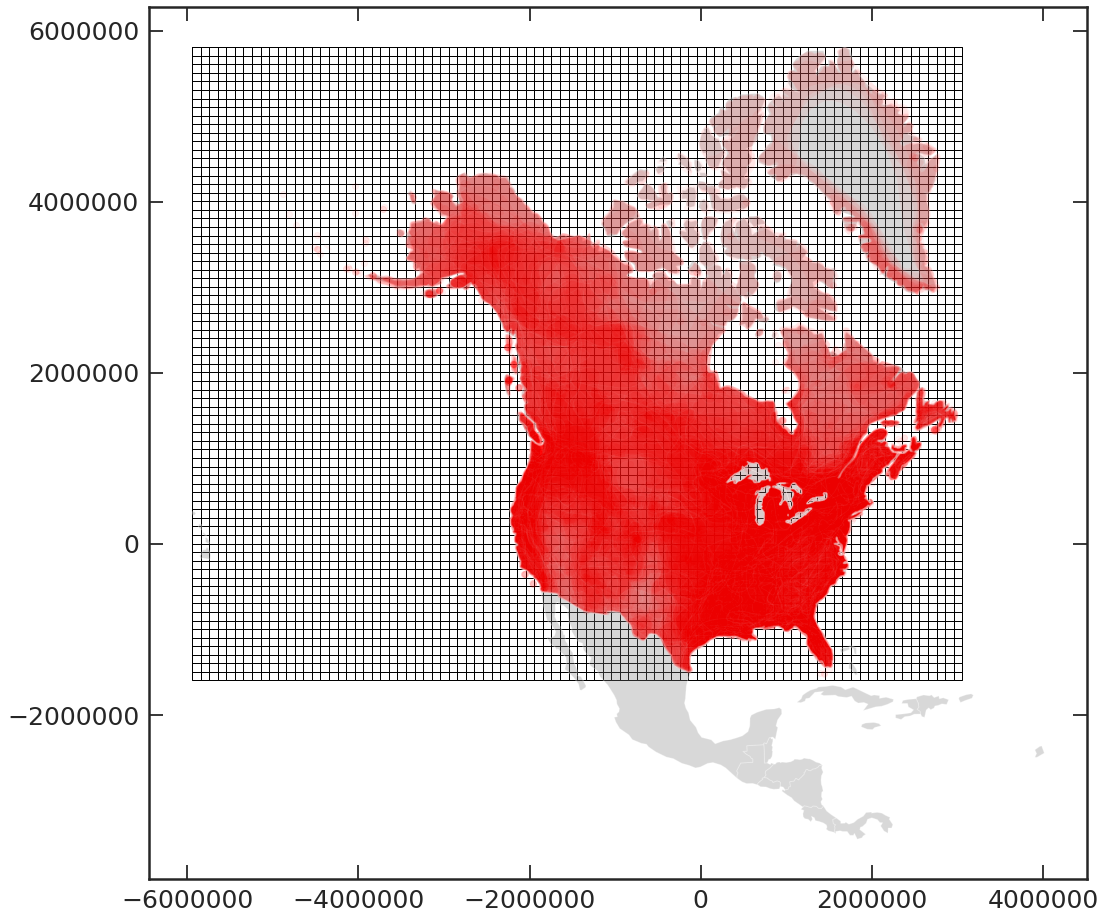

In [52]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3, ratio=0.8))

grid_100100_north_america_cut_sq.plot(ax=ax, color='white', edgecolor='black')
north_america_nad83.plot(ax=ax, color='grey', edgecolor='white', alpha=0.3)
path_details_gdf['geometry'].plot(ax=ax, color='red', alpha=0.05)

The fishnet draw above is the one we are going to work with.

We have to count the number of species within each grid.

In [53]:
path_details_gdf = path_details_gdf.sort_values('folders')

In [54]:
species = path_details_gdf[path_details_gdf['area'] != 0].reset_index(drop=True)['folders']

In [55]:
north_america_sp_code_dict = {sp: n for n, sp in enumerate(species)}

In [56]:
polys1 = path_details_gdf[path_details_gdf['area'] != 0].reset_index(
    drop=True)['geometry']
polys2 = grid_100100_north_america_cut_sq['geometry']

species = path_details_gdf[path_details_gdf['area'] != 0].reset_index(
    drop=True)['folders']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in north_america_sp_code_dict.items()],
    'code': [n for sp, n in north_america_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

Here we calculate all the intersections.

In [57]:
intersection_grids_species_gpd = gpd.overlay(df1, df2, how='intersection')

Column df1 has all the labels from the **path_details_gdf**:

In [58]:
df1.head(2)

geometry  df1   species  code
0  (POLYGON ((1217232.010075063 466547.7992786579...    1  AlisGram     0
1  (POLYGON ((-2141318.758422129 281993.412289276...    2  AlisLanc     1

While the df2 has all the labels from the **grid_5050_north_america_cut_sq**:

In [59]:
df2.head(2)

geometry  df2
0  POLYGON ((-5944766.341318235 5804657.842212005...    1
1  POLYGON ((-5944766.341318235 5704657.842212005...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [60]:
intersection_grids_species_gpd

df1     species  code   df2  \
6         1    AlisGram     0  3597   
1542      4    AlisTriv     3  3597   
13513    15  CaltPalu_g    14  3597   
16422    18  CeraDeme_g    17  3597   
24418    30    ElodBifo    29  3597   
...     ...         ...   ...   ...   
175075  239  RanuHype_g   238  4085   
175267  239  RanuHype_g   238  2015   
175342  239  RanuHype_g   238  4234   
175633  239  RanuHype_g   238  5576   
176176  239  RanuHype_g   238  4919   

                                                 geometry  
6       POLYGON ((-1139460.286005415 1304657.842212005...  
1542    POLYGON ((-1144766.341318235 1404657.842212005...  
13513   POLYGON ((-1110427.471880576 1404657.842212005...  
16422   POLYGON ((-1144766.341318235 1404657.842212005...  
24418   POLYGON ((-1107274.825262816 1304657.842212005...  
...                                                   ...  
175075  POLYGON ((-409157.3896792911 4404657.842212005...  
175267  POLYGON ((-3144766.341318235 4110129.423870414...  
175342  (POLYGON ((-169805.4708090622 4204657.84221200...  
175633  POLYGON ((1555233.658681765 3231769.902122392,...  
176176  POLYGON ((664590.0013883723 2402590.395873991,...  

[82342 rows x 5 columns]

For instance, on the first five rows of the **intersection_grids_species_gpd** displayed above, we have that the species on the labels 1, 3, 8, 11, and 15 intersect the grid of label 16689.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [61]:
intersection_grids_species_gpd.groupby('df2').count()

df1  species  code  geometry
df2                               
1058    1        1     1         1
1059    1        1     1         1
1132    1        1     1         1
1133    1        1     1         1
1134    1        1     1         1
...   ...      ...   ...       ...
6556   41       41    41        41
6557    1        1     1         1
6628    1        1     1         1
6629   37       37    37        37
6630   36       36    36        36

[2697 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 4188 (first one on the pd.DataFrame) has 1 occurrence while the grid 26432 (last one on the pd.DataFrame) has 31 occurrences.

In [62]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

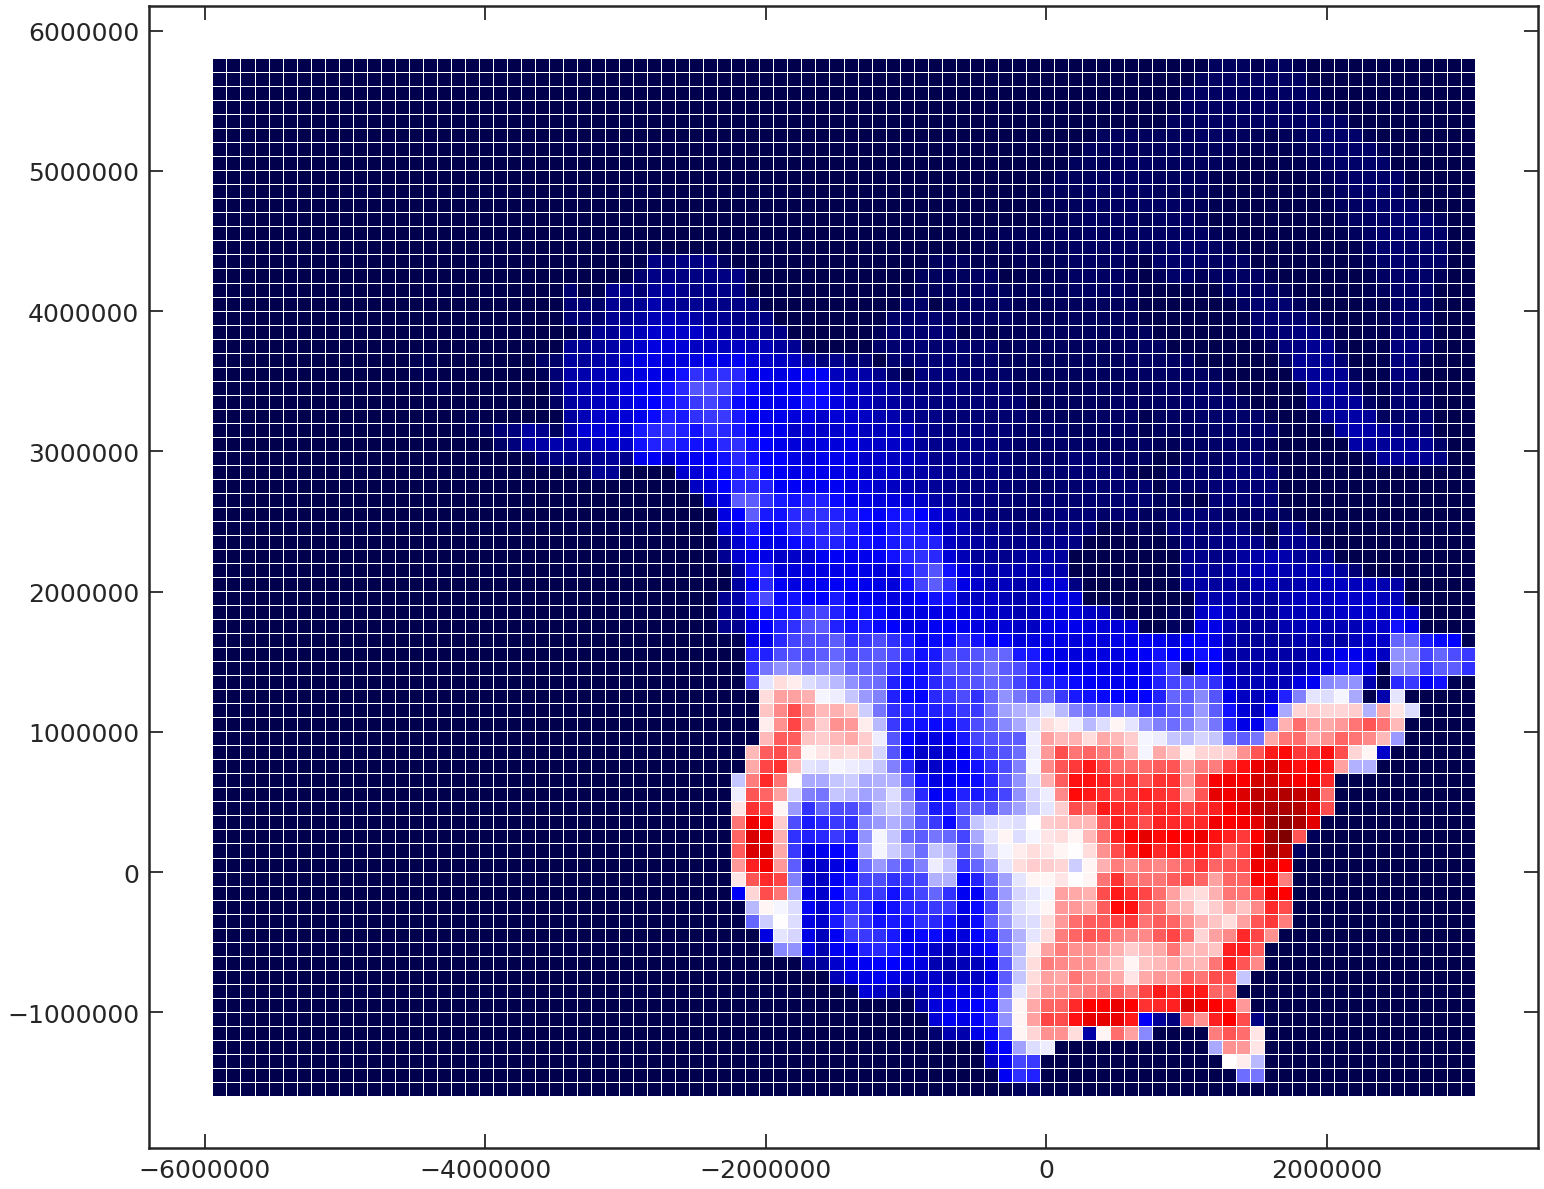

In [63]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [64]:
(pd.Series([k for k,v in north_america_sp_code_dict.items()]) == df1['species']).all()

True

In [65]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd[intersection_grids_species_gpd['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(north_america_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [66]:
df.head(3)

geometry  0_AlisGram  1_AlisLanc  \
0  POLYGON ((-5944766.341318235 5804657.842212005...         0.0         0.0   
1  POLYGON ((-5944766.341318235 5704657.842212005...         0.0         0.0   
2  POLYGON ((-5944766.341318235 5604657.842212005...         0.0         0.0   

   2_AlisSubc  3_AlisTriv  4_AzolCaro_g  5_AzolFili_g  6_AzolMexi_g  \
0         0.0         0.0           0.0           0.0           0.0   
1         0.0         0.0           0.0           0.0           0.0   
2         0.0         0.0           0.0           0.0           0.0   

   7_BlyxAube  8_BrasSchr_g      ...       300_TyphLati  301_VallAmer  \
0         0.0           0.0      ...                0.0           0.0   
1         0.0           0.0      ...                0.0           0.0   
2         0.0           0.0      ...                0.0           0.0   

   302_WolfBore  303_WolfBras  304_WolfColu  305_WolfGlob  306_WolffiellaGlad  \
0           0.0           0.0           0.0           0.0                 0.0   
1           0.0           0.0           0.0           0.0                 0.0   
2           0.0           0.0           0.0           0.0                 0.0   

   307_WolffiellaLing  308_WolffiellaOblo  309_ZannPalu  
0                 0.0                 0.0           0.0  
1                 0.0                 0.0           0.0  
2                 0.0                 0.0           0.0  

[3 rows x 311 columns]

We add a column with the total species that occurred within that grid.

In [67]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [68]:
occurrences_within_100100_grid = gpd.GeoDataFrame(df, geometry='geometry')

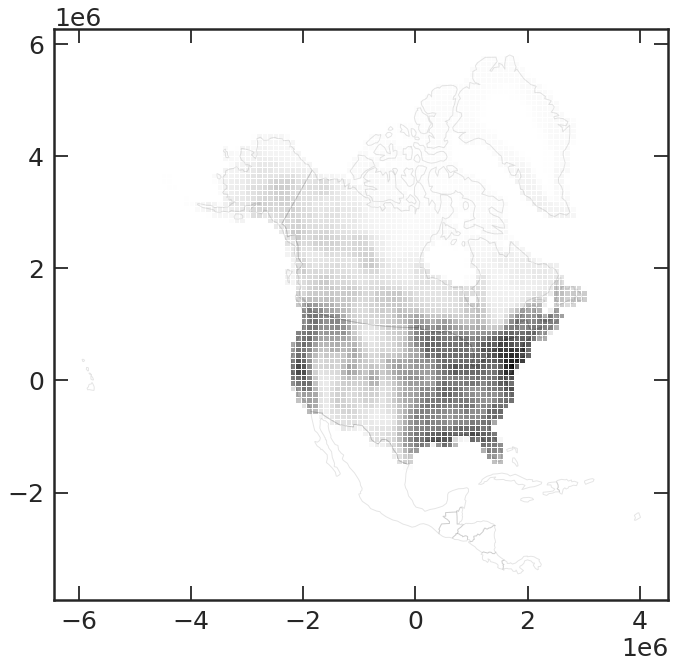

In [69]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_100100_grid[['geometry', 'Total']].plot(column='Total', cmap='Greys', ax=ax);
north_america_nad83.plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [70]:
occurrences_within_100100_grid.crs = {'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0}

In [72]:
occurrences_within_100100_grid.to_file('../results/north_america/sp_polygon_100100/occurrences_within_100100_grid_north_america.shp')

# Europe data
<a id="europe-data"></a>
<a href="#summary">Summary</a>

In this section we are going to analyze the aspects of the data from Europe.

## First look
<a id="first-look"></a>
<a href="#summary">Summary</a>

The first file we have consists in a matrix file with the occurrences of the species within each grid. However, we do not have a shape file for each of these grids, but a code. This code is given using the **Common European Grid Reference System (CGRS)**.

In [56]:
europe_matrix_pres_abs = pd.read_excel('../raw_data/europe/Aquatic_spp157_matrix_Europe.xlsx')

As one can see below, we have **1606 grids** and **158 species**.

In [57]:
europe_matrix_pres_abs.shape

(1606, 158)

We count the number of species within that particular grid.

In [58]:
europe_matrix_pres_abs['Total'] = europe_matrix_pres_abs[europe_matrix_pres_abs.columns[1:]].sum(axis=1)

In [59]:
europe_matrix_pres_abs.head()

CGRSNAME  Acorus calamus  Aldrovanda vesiculosa  Alisma gramineum  \
0   33TYN1               1                      0                 1   
1   33TYN2               1                      0                 1   
2   33UUA4               1                      0                 0   
3   33UUB1               1                      0                 0   
4   33UUB3               1                      0                 0   

   Alisma lanceolatum  Alisma plantago-aquatica  Alisma wahlenbergii  \
0                   1                         1                    0   
1                   1                         1                    0   
2                   0                         1                    0   
3                   1                         1                    0   
4                   0                         1                    0   

   Apium inundatum  Azolla filiculoides  Baldellia ranunculoides  ...    \
0                0                    0                        0  ...     
1                0                    0                        0  ...     
2                0                    0                        0  ...     
3                0                    0                        0  ...     
4                1                    0                        1  ...     

   Utricularia intermedia  Utricularia minor  Utricularia vulgaris  \
0                       0                  1                     1   
1                       0                  1                     1   
2                       1                  1                     1   
3                       0                  1                     0   
4                       1                  1                     1   

   Veronica anagallis-aquatica  Veronica beccabunga  Veronica catenata  \
0                            1                    1                  0   
1                            1                    1                  0   
2                            1                    1                  0   
3                            1                    1                  1   
4                            1                    0                  1   

   Zannichellia palustris  Elatine alsinastrum  Elatine triandra  Total  
0                       1                    1                 0     83  
1                       1                    1                 0     79  
2                       0                    0                 0     83  
3                       1                    0                 0     85  
4                       1                    0                 1     96  

[5 rows x 159 columns]

Now we have this shape file containing the grids based on the **CGRS**:

In [60]:
cgrs_shp_gpd = gpd.read_file('../raw_data/europe/cgrs_grid/cgrs_grid.shp')

In [61]:
cgrs_shp_gpd.crs

{'init': 'epsg:4326'}

We map all the polygons according to the **CGRS** names.

In [62]:
europe_matrix_pres_abs['geometry'] = europe_matrix_pres_abs['CGRSNAME'].map(cgrs_shp_gpd[['CGRSNAME', 'geometry']].set_index('CGRSNAME').to_dict('dict')['geometry'])

In [63]:
europe_matrix_pres_abs['geometry']

0       POLYGON ((17.64926 47.37283, 17.67206 47.82224...
1       POLYGON ((17.627 46.92338, 17.64926 47.37283, ...
2       POLYGON ((12.70451 54.12622, 12.67934 54.57522...
3       POLYGON ((12 55.45934, 12 55.90883, 12.59949 5...
4       POLYGON ((12.62685 55.4731, 12.59949 55.92198,...
                              ...                        
1601    POLYGON ((13.70747 46.04627, 13.69685 46.49615...
1602    POLYGON ((14.34836 46.50171, 14.34292 46.95164...
1603    POLYGON ((14.35367 46.05175, 14.34836 46.50171...
1604    POLYGON ((13.67483 47.39579, 13.66341 47.84556...
1605    POLYGON ((14.33734 47.40154, 14.33163 47.8514,...
Name: geometry, Length: 1606, dtype: object

Now we transform the pd.DataFrame into A gpd.GeoDataFrame considering the column 'geometry' as the geometry with polygons.

In [64]:
europe_matrix_pres_abs = gpd.GeoDataFrame(europe_matrix_pres_abs, geometry='geometry')

Now we calculate the total number of species within each grid.

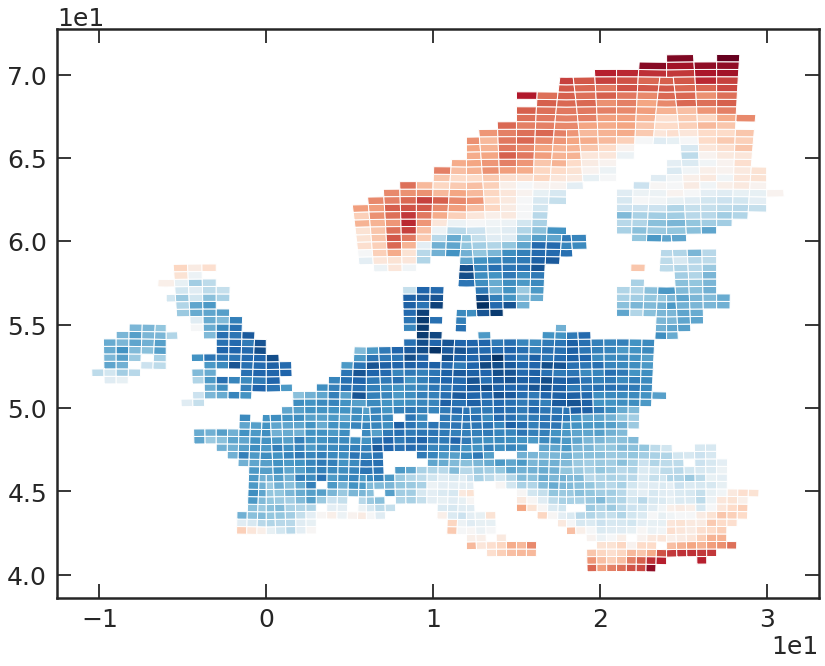

In [65]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))

europe_matrix_pres_abs.plot(ax=ax, column='Total', cmap='RdBu')

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

We can use the projection **NAD83**:

In [66]:
cgrs_shp_gpd_nad83 = cgrs_shp_gpd.to_crs({'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0})

In [67]:
cgrs_shp_gpd_nad83.head()

CGRSNAME               CGRSTYPE  \
0   24NSF3  independent seam cell   
1   24NSF4  independent seam cell   
2   24NSG3  independent seam cell   
3   24NSG4  independent seam cell   
4   24NSH3  independent seam cell   

                                            geometry  
0  POLYGON ((6649736.800845682 -2333779.249808296...  
1  POLYGON ((6684042.128302566 -2381909.646317114...  
2  POLYGON ((6581644.915545439 -2238246.290892435...  
3  POLYGON ((6615605.39822203 -2285892.869952482,...  
4  POLYGON ((6514224.923397187 -2143655.998501401...

We create a copy of the europe_matrix_pres_abs and delete the previous geometry so we can create the other in the nad83 projection.

In [68]:
europe_matrix_pres_abs_nad83 = europe_matrix_pres_abs.copy()
del europe_matrix_pres_abs_nad83['geometry']

In [69]:
europe_matrix_pres_abs_nad83.head()

CGRSNAME  Acorus calamus  Aldrovanda vesiculosa  Alisma gramineum  \
0   33TYN1               1                      0                 1   
1   33TYN2               1                      0                 1   
2   33UUA4               1                      0                 0   
3   33UUB1               1                      0                 0   
4   33UUB3               1                      0                 0   

   Alisma lanceolatum  Alisma plantago-aquatica  Alisma wahlenbergii  \
0                   1                         1                    0   
1                   1                         1                    0   
2                   0                         1                    0   
3                   1                         1                    0   
4                   0                         1                    0   

   Apium inundatum  Azolla filiculoides  Baldellia ranunculoides  ...    \
0                0                    0                        0  ...     
1                0                    0                        0  ...     
2                0                    0                        0  ...     
3                0                    0                        0  ...     
4                1                    0                        1  ...     

   Utricularia intermedia  Utricularia minor  Utricularia vulgaris  \
0                       0                  1                     1   
1                       0                  1                     1   
2                       1                  1                     1   
3                       0                  1                     0   
4                       1                  1                     1   

   Veronica anagallis-aquatica  Veronica beccabunga  Veronica catenata  \
0                            1                    1                  0   
1                            1                    1                  0   
2                            1                    1                  0   
3                            1                    1                  1   
4                            1                    0                  1   

   Zannichellia palustris  Elatine alsinastrum  Elatine triandra  Total  
0                       1                    1                 0     83  
1                       1                    1                 0     79  
2                       0                    0                 0     83  
3                       1                    0                 0     85  
4                       1                    0                 1     96  

[5 rows x 159 columns]

Now we map the polygons.

In [70]:
europe_matrix_pres_abs_nad83['geometry'] = europe_matrix_pres_abs_nad83['CGRSNAME'].map(cgrs_shp_gpd_nad83[['CGRSNAME', 'geometry']].set_index('CGRSNAME').to_dict('dict')['geometry'])

In [71]:
europe_matrix_pres_abs_nad83['geometry']

0       POLYGON ((6003547.541963266 5350165.124617628,...
1       POLYGON ((6048651.16620484 5336141.581857722, ...
2       POLYGON ((5221086.189204402 5240972.011263947,...
3       POLYGON ((5070777.080242321 5245772.595276377,...
4       POLYGON ((5081814.118348365 5282743.676878905,...
                              ...                        
1601    POLYGON ((6055510.882118946 5037736.453646368,...
1602    POLYGON ((6024194.112990042 5096650.601671564,...
1603    POLYGON ((6069306.404595892 5082835.034543341,...
1604    POLYGON ((5920041.839881434 5079092.995277294,...
1605    POLYGON ((5933856.300987229 5124305.595010851,...
Name: geometry, Length: 1606, dtype: object

Now we transform the pd.DataFrame into A gpd.GeoDataFrame considering the column 'geometry' as the geometry with polygons.

In [72]:
europe_matrix_pres_abs_nad83 = gpd.GeoDataFrame(europe_matrix_pres_abs_nad83, geometry='geometry')

The grids with the data will look like this:

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


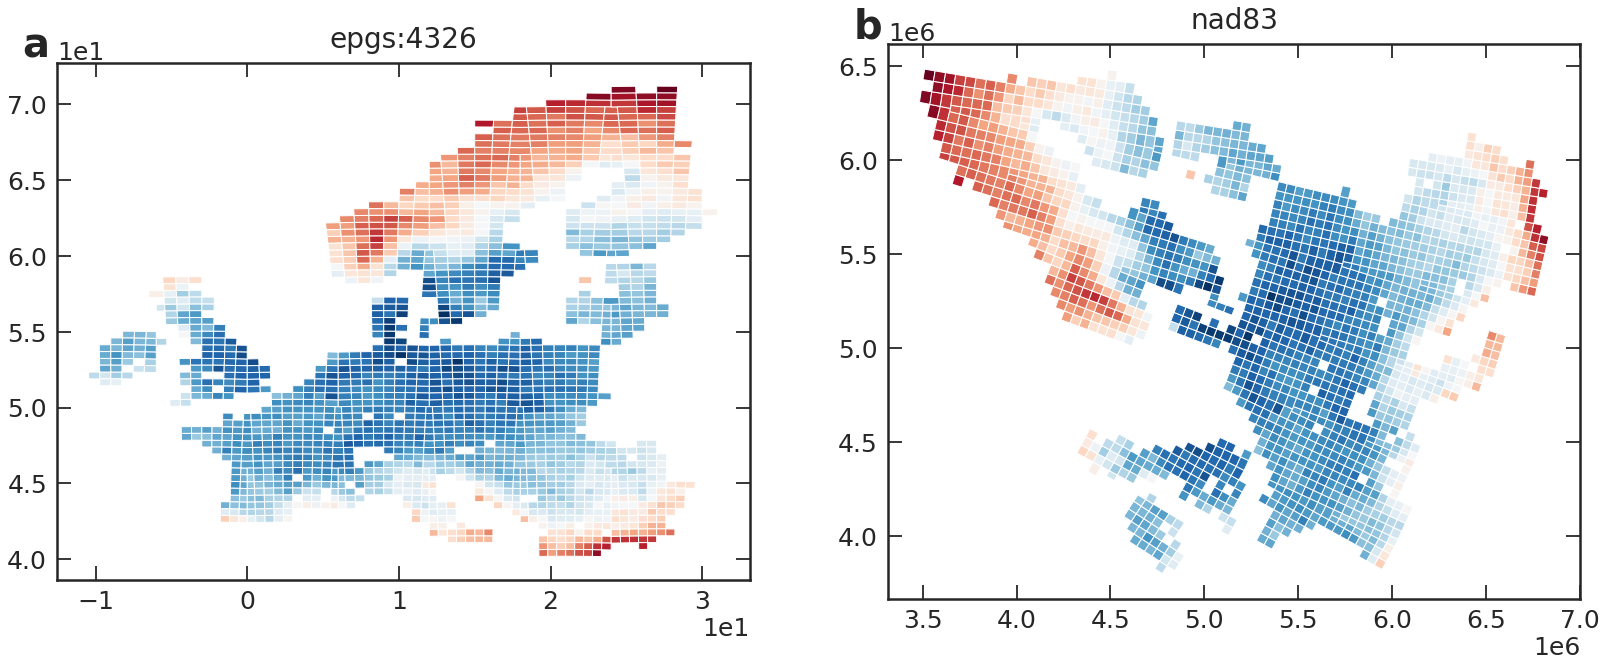

In [73]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(scale=1.5, ny=1, nx=2))

fs_label = 40

europe_matrix_pres_abs.plot(column='Total', cmap='RdBu', ax=ax[0])
europe_matrix_pres_abs_nad83.plot(column='Total', cmap='RdBu', ax=ax[1])

for c in range(2):
    ax[c].set_title(['epgs:4326', 'nad83'][c])
    ax[c].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax[c].annotate(string.ascii_lowercase[c], (-0.05, 1.01), xycoords='axes fraction', fontsize=fs_label, weight='bold')

## Count the number of grids
<a id="count-the-number-of-grids"></a>
<a href="#summary">Summary</a>

First we create a gpd.GeoDataFrame with the dissolved polygons of all the grids that we have from the cgrs data.

In [84]:
tmp_l = []
for sp in europe_matrix_pres_abs_nad83.columns[1:-2]:
    # sp = 'Acorus calamus'
    df = europe_matrix_pres_abs_nad83[[sp, 'geometry']] 
    gdf = df[df[sp] != 0].dissolve(sp).reset_index()
    del gdf[sp]
    gdf['specie'] = sp

    tmp_l.append(gdf)

In [85]:
europe_sp_polygon = pd.concat(tmp_l).reset_index(drop=True)
del tmp_l

In [104]:
# europe_sp_polygon.to_file('results/europe/sp_polygon/europe_sp_polygon.shp')

Now we have to create the fishnet for the Europe. To do this we are going to use the function **fishnet**.

Before creating the fishnet, we are going to take a look at the places where the data is found.

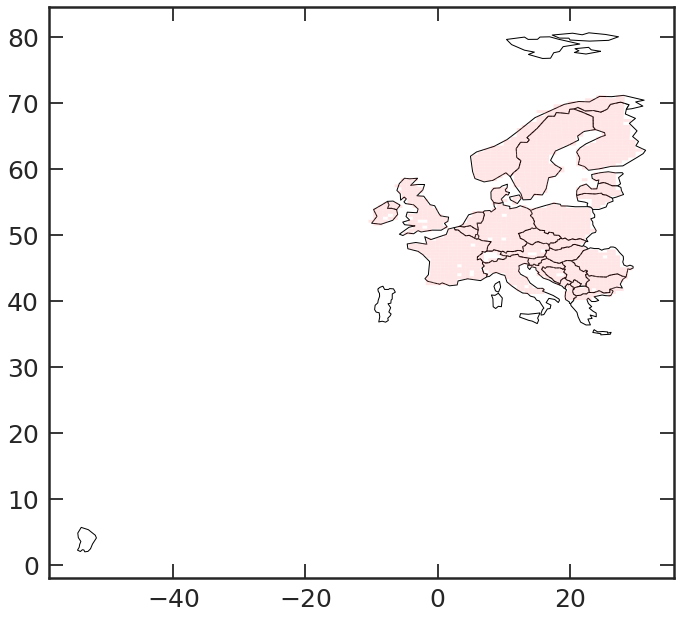

In [88]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=2, ratio=0.8))

world[(world['continent'] == 'Europe')][~world[(world['continent'] == 'Europe')]['name'].isin(['Russia', 'Portugual', 'Spain', 'Iceland', 'Belarus', 'Ukraine', 'Moldova'])].plot(ax=ax, color='white', edgecolor='black')
europe_matrix_pres_abs.plot(ax=ax, color='red', alpha=0.1)

We them consider the Europe without Russia to create the nad83 projection.

In [89]:
europe_nad83 = world[(world['continent'] == 'Europe') & (world['name'] != 'Russia')].to_crs({'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0})

Let's take a look at the data in this new projection.

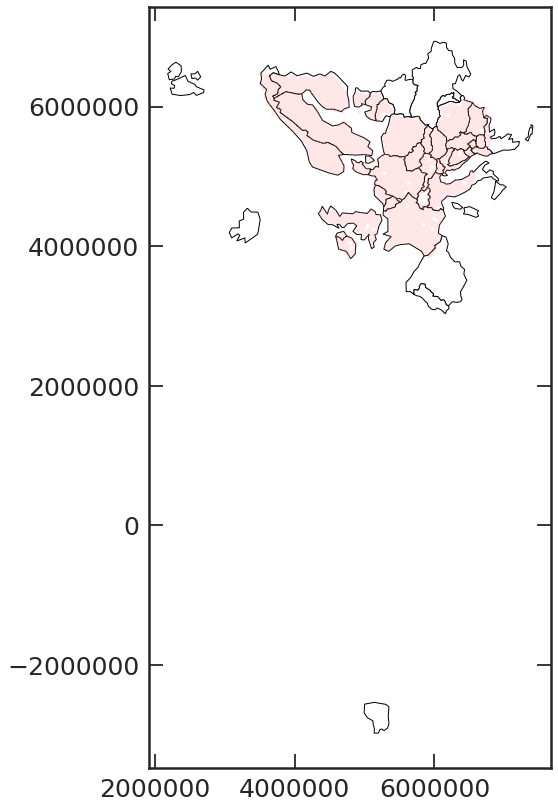

In [90]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=2, ratio=0.8))

europe_nad83.plot(ax=ax, color='white', edgecolor='black')
europe_matrix_pres_abs_nad83.plot(ax=ax, color='red', alpha=0.1)

In [91]:
grids_europe_5050 = fishnet(europe_matrix_pres_abs_nad83, width=50000, height=50000)
grids_europe_100100 = fishnet(europe_matrix_pres_abs_nad83, width=100000, height=100000)

Now that we have the polygon data and the grids, we can count the number of species within each grid.

We have to count the number of species within each grid.

In [92]:
species_europe = europe_sp_polygon['specie']

We create a code number for each specie.

In [97]:
europe_sp_code_dict = {sp: n for n, sp in enumerate(species_europe)}

### For the $50\,km^2$
<a id="for-the-50-km"></a>
<a href="#summary">Summary</a>

In [ ]:
europe_sp_code_dict

In [99]:
path_details_gdf

folders                 files  \
0         AlisGram    AlisGram_point.shp   
1         AlisGram  AlisGram_polygon.shp   
2         AlisLanc          AlisLanc.shp   
3    AlisPlan-aqua     AlisPlan-aqua.shp   
4         AlisSubc          AlisSubc.shp   
..             ...                   ...   
577       WolfGlob    WolfGlob_point.shp   
578       WolfGlob  WolfGlob_polygon.shp   
579       ZannPalu    ZannPalu_point.shp   
580       ZannPalu  ZannPalu_polygon.shp   
581       ZostJapo          ZostJapo.shp   

                                                 paths  \
0    ../../macrophytes_data/north_america/Shapefile...   
1    ../../macrophytes_data/north_america/Shapefile...   
2    ../../macrophytes_data/north_america/Shapefile...   
3    ../../macrophytes_data/north_america/Shapefile...   
4    ../../macrophytes_data/north_america/Shapefile...   
..                                                 ...   
577  ../../macrophytes_data/north_america/Shapefile...   
578  ../../macrophytes_data/north_america/Shapefile...   
579  ../../macrophytes_data/north_america/Shapefile...   
580  ../../macrophytes_data/north_america/Shapefile...   
581  ../../macrophytes_data/north_america/Shapefile...   

                                              geometry          area  
0    (POINT (-1979117.438179391 1817854.755364797),...  0.000000e+00  
1    (POLYGON ((1217232.010075063 466547.7992786579...  2.144365e+12  
2    (POLYGON ((-2141318.758422129 281993.412289276...  6.421037e+10  
3         POINT (-2442740.545034301 3442876.618396966)  0.000000e+00  
4    POLYGON ((2086831.985638313 812269.6764740683,...  3.125733e+12  
..                                                 ...           ...  
577       POINT (1286152.233336307 -1112093.954126946)  0.000000e+00  
578  POLYGON ((-1699517.904670633 -467408.914756864...  9.530282e+10  
579  (POINT (-2794950.784571846 3045377.202994014),...  0.000000e+00  
580  (POLYGON ((974260.2087112665 -976696.587681338...  5.914547e+12  
581  (POINT (-1985246.584072316 1027905.339160637),...  0.000000e+00  

[582 rows x 5 columns]

In [114]:
polys1 = sp_polygon_europe[sp_polygon_europe['area'] != 0].reset_index(
    drop=True)['geometry']
polys2 = grids_europe_5050['geometry']

species = sp_polygon_europe[sp_polygon_europe['area'] != 0].reset_index(
    drop=True)['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in europe_sp_code_dict.items()],
    'code': [n for sp, n in europe_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

Here we calculate all the intersections.

In [115]:
intersection_grids_species_gpd_europe = gpd.overlay(df1, df2, how='intersection')

Column df1 has all the labels from the **path_details_gdf**:

In [116]:
df1.head(2)

geometry  df1  \
0  (POLYGON ((4731286.624026645 4273781.341570556...    1   
1  (POLYGON ((5863981.224978034 3866643.593770091...    2   

                 species  code  
0         Acorus calamus     0  
1  Aldrovanda vesiculosa     1

While the df2 has all the labels from the **grid_5050_north_america_cut_sq**:

In [117]:
df2.head(2)

geometry  df2
0  POLYGON ((3483112.472912834 6485379.222420639,...    1
1  POLYGON ((3483112.472912834 6435379.222420639,...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [118]:
intersection_grids_species_gpd_europe

df1                   species  code   df2  \
2         1            Acorus calamus     0  3364   
3441      3          Alisma gramineum     2  3364   
5037      4        Alisma lanceolatum     3  3364   
7090      5  Alisma plantago-aquatica     4  3364   
15091    10             Berula erecta     9  3364   
...     ...                       ...   ...   ...   
321871  140         Sparganium natans   139   504   
330619  143        Subularia aquatica   142   504   
334388  145      Trichophorum alpinum   144   504   
345904  149    Utricularia intermedia   148   504   
349252  150         Utricularia minor   149   504   

                                                 geometry  
2       POLYGON ((6623614.038331674 5734375.635907611,...  
3441    POLYGON ((6583112.472912833 5735379.222420639,...  
5037    POLYGON ((6583112.472912833 5735379.222420639,...  
7090    POLYGON ((6623775.631771588 5735379.222420639,...  
15091   POLYGON ((6583112.472912833 5735379.222420639,...  
...                                                   ...  
321871  POLYGON ((3983112.472912834 5621149.237569521,...  
330619  POLYGON ((3983112.472912834 5621149.237569521,...  
334388  POLYGON ((3983112.472912834 5621149.237569521,...  
345904  POLYGON ((3983112.472912834 5621149.237569521,...  
349252  POLYGON ((3983112.472912834 5621149.237569521,...  

[144936 rows x 5 columns]

For instance, on the first five rows of the **intersection_grids_species_gpd_europe** displayed above, we have that the species on the labels 1, 3, 4, and 5 intersect the grid of label 3364.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [119]:
intersection_grids_species_gpd_europe.groupby('df2').count()

df1  species  code  geometry
df2                               
1      13       13    13        13
2      13       13    13        13
3      16       16    16        16
4      16       16    16        16
5      17       17    17        17
...   ...      ...   ...       ...
3584   30       30    30        30
3585   34       34    34        34
3586   37       37    37        37
3587   35       35    35        35
3636   18       18    18        18

[1862 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 4188 (first one on the pd.DataFrame) has 1 occurrence while the grid 26432 (last one on the pd.DataFrame) has 31 occurrences.

In [120]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_europe.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

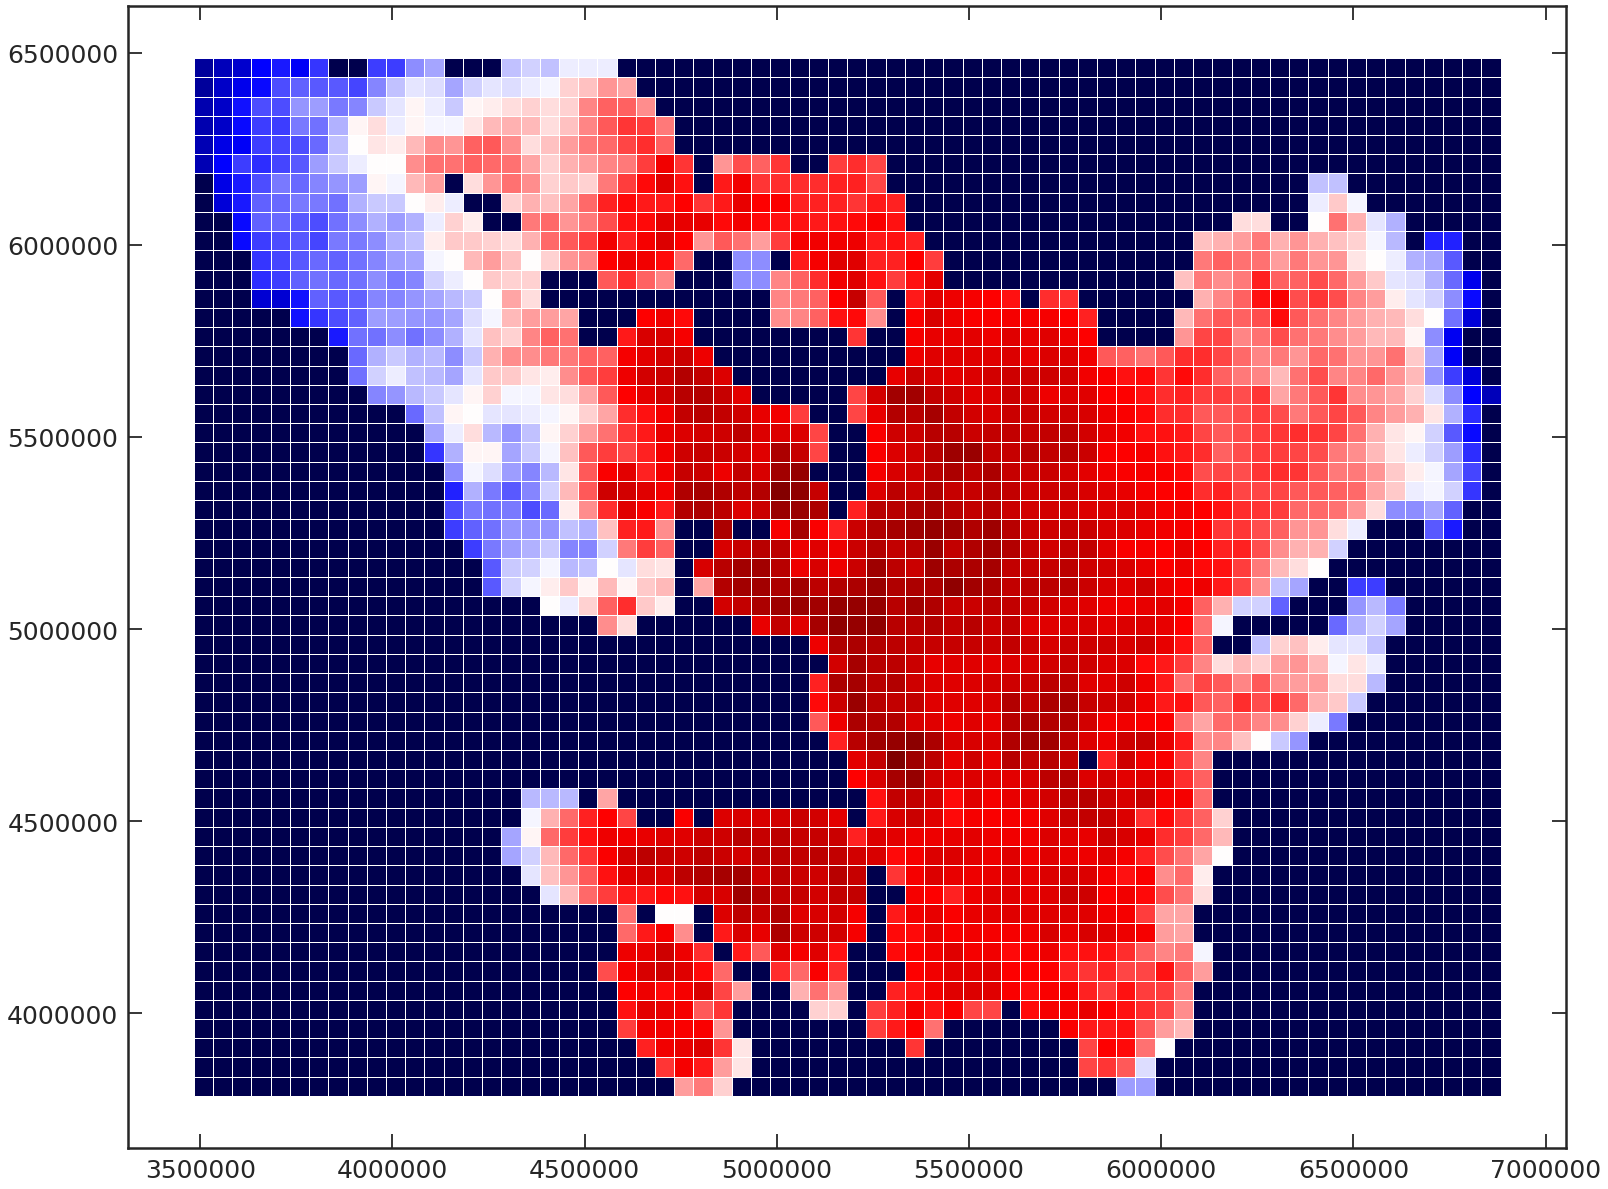

In [121]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [123]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_europe[intersection_grids_species_gpd_europe['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(europe_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [143]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_europe[intersection_grids_species_gpd_europe['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[sp] = df2['df2'].map(sp_dict).fillna(0)

In [124]:
df.head(3)

geometry  0_Acorus calamus  \
0  POLYGON ((3483112.472912834 6485379.222420639,...               0.0   
1  POLYGON ((3483112.472912834 6435379.222420639,...               0.0   
2  POLYGON ((3483112.472912834 6385379.222420639,...               0.0   

   1_Aldrovanda vesiculosa  2_Alisma gramineum  3_Alisma lanceolatum  \
0                      0.0                 0.0                   0.0   
1                      0.0                 0.0                   0.0   
2                      0.0                 0.0                   0.0   

   4_Alisma plantago-aquatica  5_Alisma wahlenbergii  6_Apium inundatum  \
0                         0.0                    0.0                0.0   
1                         0.0                    0.0                0.0   
2                         0.0                    0.0                0.0   

   7_Azolla filiculoides  8_Baldellia ranunculoides          ...           \
0                    0.0                        0.0          ...            
1                    0.0                        0.0          ...            
2                    0.0                        0.0          ...            

   147_Utricularia australis  148_Utricularia intermedia  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   

   149_Utricularia minor  150_Utricularia vulgaris  \
0                    0.0                       0.0   
1                    0.0                       0.0   
2                    0.0                       0.0   

   151_Veronica anagallis-aquatica  152_Veronica beccabunga  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   

   153_Veronica catenata  154_Zannichellia palustris  155_Elatine alsinastrum  \
0                    0.0                         0.0                      0.0   
1                    0.0                         0.0                      0.0   
2                    0.0                         0.0                      0.0   

   156_Elatine triandra  
0                   0.0  
1                   0.0  
2                   0.0  

[3 rows x 158 columns]

We add a column with the total species that occurred within that grid.

In [125]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [126]:
occurrences_within_5050_grid_europe = gpd.GeoDataFrame(df, geometry='geometry')

In [127]:
occurrences_within_5050_grid_europe

geometry  0_Acorus calamus  \
0     POLYGON ((3483112.472912834 6485379.222420639,...               0.0   
1     POLYGON ((3483112.472912834 6435379.222420639,...               0.0   
2     POLYGON ((3483112.472912834 6385379.222420639,...               0.0   
3     POLYGON ((3483112.472912834 6335379.222420639,...               0.0   
4     POLYGON ((3483112.472912834 6285379.222420639,...               0.0   
...                                                 ...               ...   
3667  POLYGON ((6833112.472912833 4035379.222420639,...               0.0   
3668  POLYGON ((6833112.472912833 3985379.222420639,...               0.0   
3669  POLYGON ((6833112.472912833 3935379.222420639,...               0.0   
3670  POLYGON ((6833112.472912833 3885379.222420639,...               0.0   
3671  POLYGON ((6833112.472912833 3835379.222420639,...               0.0   

      1_Aldrovanda vesiculosa  2_Alisma gramineum  3_Alisma lanceolatum  \
0                         0.0                 0.0                   0.0   
1                         0.0                 0.0                   0.0   
2                         0.0                 0.0                   0.0   
3                         0.0                 0.0                   0.0   
4                         0.0                 0.0                   0.0   
...                       ...                 ...                   ...   
3667                      0.0                 0.0                   0.0   
3668                      0.0                 0.0                   0.0   
3669                      0.0                 0.0                   0.0   
3670                      0.0                 0.0                   0.0   
3671                      0.0                 0.0                   0.0   

      4_Alisma plantago-aquatica  5_Alisma wahlenbergii  6_Apium inundatum  \
0                            0.0                    0.0                0.0   
1                            0.0                    0.0                0.0   
2                            0.0                    0.0                0.0   
3                            0.0                    0.0                0.0   
4                            0.0                    0.0                0.0   
...                          ...                    ...                ...   
3667                         0.0                    0.0                0.0   
3668                         0.0                    0.0                0.0   
3669                         0.0                    0.0                0.0   
3670                         0.0                    0.0                0.0   
3671                         0.0                    0.0                0.0   

      7_Azolla filiculoides  8_Baldellia ranunculoides  ...    \
0                       0.0                        0.0  ...     
1                       0.0                        0.0  ...     
2                       0.0                        0.0  ...     
3                       0.0                        0.0  ...     
4                       0.0                        0.0  ...     
...                     ...                        ...  ...     
3667                    0.0                        0.0  ...     
3668                    0.0                        0.0  ...     
3669                    0.0                        0.0  ...     
3670                    0.0                        0.0  ...     
3671                    0.0                        0.0  ...     

      148_Utricularia intermedia  149_Utricularia minor  \
0                            0.0                    0.0   
1                            0.0                    0.0   
2                            0.0                    0.0   
3                            0.0                    0.0   
4                            0.0                    0.0   
...                          ...                    ...   
3667                         0.0                    0.0   
3668                         0.

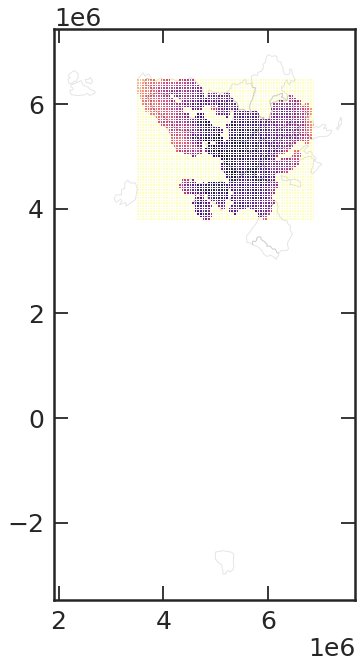

In [128]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_5050_grid_europe[['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
europe_nad83.plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [129]:
# occurrences_within_5050_grid_europe.to_file('../results/europe/nad83/sp_polygon_5050_nad83/occurrences_within_5050_grid_europe_nad83.shp')

In [18]:
occurrences_within_5050_grid_europe = gpd.read_file('../results/europe/sp_polygon_5050/occurrences_within_5050_grid_europe.shp')

In [36]:
occurrences_within_5050_grid_europe[
    occurrences_within_5050_grid_europe.columns[
        occurrences_within_5050_grid_europe.columns != 'Total']].sum(axis=0).min()

4.0

In [37]:
occurrences_within_5050_grid_europe.sum(axis=0)[occurrences_within_5050_grid_europe.sum(axis=0) == 4.]

Ceratoph_1    4.0
Nymphaea l    4.0
Nymphaea r    4.0
Pilularia     4.0
dtype: float64

In [35]:
occurrences_within_5050_grid_europe.sum(axis=0)[occurrences_within_5050_grid_europe.sum(axis=0) == 1830.]

Phragmites    1830.0
dtype: float64

### For the $100\,km^2$
<a id="for-the-100-km"></a>
<a href="#summary">Summary</a>

In [42]:
polys1 = europe_sp_polygon['geometry']
polys2 = grids_europe_100100['geometry']

df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1': np.arange(1, len(polys1)+1), 'species': species_europe})
df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2': np.arange(1, len(polys2)+1)})

Here we calculate all the intersections.

In [43]:
intersection_grids_species_gpd_europe = gpd.overlay(df1, df2, how='intersection')

Column df1 has all the labels from the **path_details_gdf**:

In [44]:
df1.head(2)

df1                                           geometry  \
0    1  (POLYGON ((4731286.624026645 4273781.341570556...   
1    2  (POLYGON ((5863981.224978034 3866643.593770091...   

                 species  
0         Acorus calamus  
1  Aldrovanda vesiculosa

While the df2 has all the labels from the **grid_5050_north_america_cut_sq**:

In [45]:
df2.head(2)

df2                                           geometry
0    1  POLYGON ((3483112.472912834 6485379.222420639,...
1    2  POLYGON ((3483112.472912834 6385379.222420639,...

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [46]:
intersection_grids_species_gpd_europe

df1                   species  df2  \
13       1            Acorus calamus  847   
927      3          Alisma gramineum  847   
1356     4        Alisma lanceolatum  847   
1892     5  Alisma plantago-aquatica  847   
3972    10             Berula erecta  847   
...    ...                       ...  ...   
70560  117        Ranunculus reptans    1   
71658  120  Ranunculus trichophyllus    1   
79473  134  Sparganium angustifolium    1   
81965  139    Sparganium hyperboreum    1   
85070  143        Subularia aquatica    1   

                                                geometry  
13     POLYGON ((6583112.472912833 5557065.502811748,...  
927    (POLYGON ((6683112.472912833 5581956.057718567...  
1356   POLYGON ((6583112.472912833 5508808.380932489,...  
1892   POLYGON ((6668453.599433335 5585379.222420639,...  
3972   POLYGON ((6583112.472912833 5508808.380932489,...  
...                                                  ...  
70560  POLYGON ((3551753.421913818 6385379.222420639,...  
71658  POLYGON ((3551753.421913818 6385379.222420639,...  
79473  POLYGON ((3551753.421913818 6385379.222420639,...  
81965  POLYGON ((3551753.421913818 6385379.222420639,...  
85070  POLYGON ((3551753.421913818 6385379.222420639,...  

[44460 rows x 4 columns]

For instance, on the first five rows of the **intersection_grids_species_gpd_europe** displayed above, we have that the species on the labels 1, 3, 4, and 5 intersect the grid of label 3364.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [47]:
intersection_grids_species_gpd_europe.groupby('df2').count()

df1  species  geometry
df2                        
1     20       20        20
2     20       20        20
3     29       29        29
4     25       25        25
28    33       33        33
..   ...      ...       ...
898   30       30        30
900   29       29        29
901   36       36        36
902   38       38        38
903   35       35        35

[531 rows x 3 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 4188 (first one on the pd.DataFrame) has 1 occurrence while the grid 26432 (last one on the pd.DataFrame) has 31 occurrences.

In [48]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_europe.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


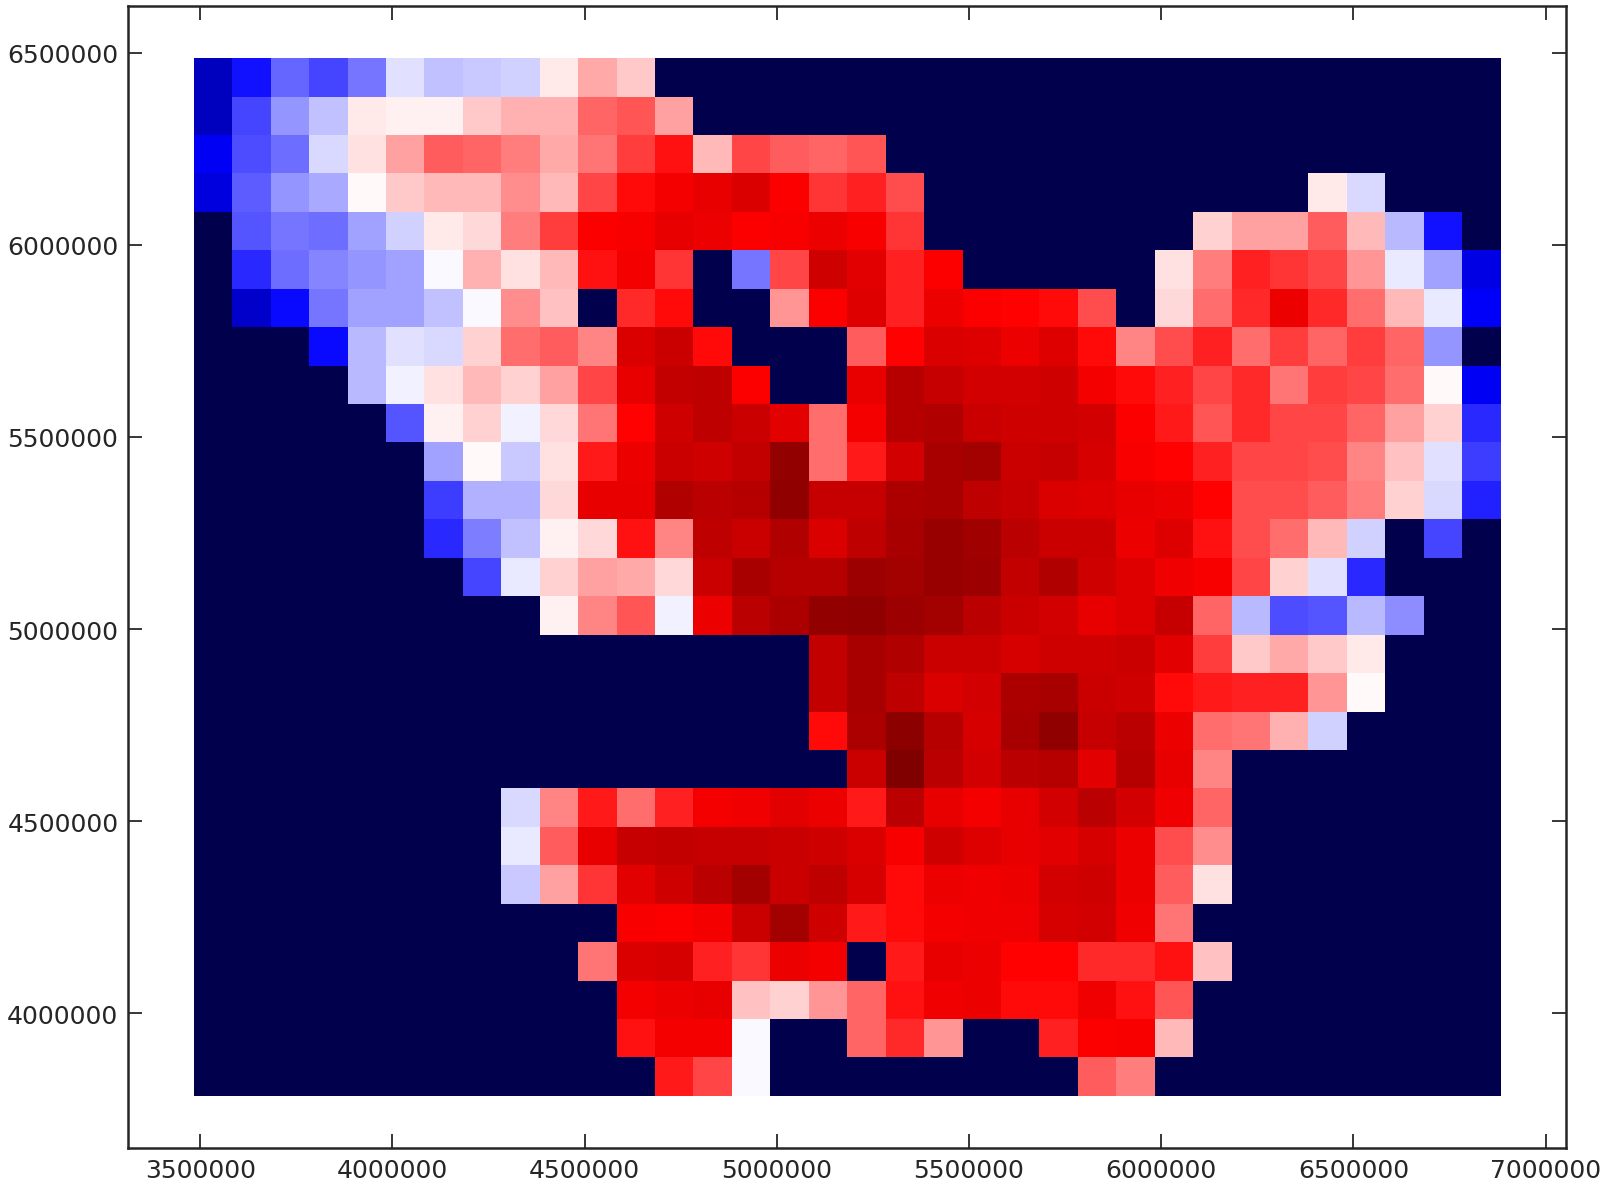

In [49]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [50]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_europe[intersection_grids_species_gpd_europe['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[sp] = df2['df2'].map(sp_dict).fillna(0)

In [51]:
df.head(3)

geometry  Acorus calamus  \
0  POLYGON ((3483112.472912834 6485379.222420639,...             0.0   
1  POLYGON ((3483112.472912834 6385379.222420639,...             0.0   
2  POLYGON ((3483112.472912834 6285379.222420639,...             0.0   

   Aldrovanda vesiculosa  Alisma gramineum  Alisma lanceolatum  \
0                    0.0               0.0                 0.0   
1                    0.0               0.0                 0.0   
2                    0.0               0.0                 0.0   

   Alisma plantago-aquatica  Alisma wahlenbergii  Apium inundatum  \
0                       0.0                  0.0              0.0   
1                       0.0                  0.0              0.0   
2                       0.0                  0.0              0.0   

   Azolla filiculoides  Baldellia ranunculoides        ...         \
0                  0.0                      0.0        ...          
1                  0.0                      0.0        ...          
2                  0.0                      0.0        ...          

   Utricularia australis  Utricularia intermedia  Utricularia minor  \
0                    0.0                     0.0                0.0   
1                    0.0                     0.0                0.0   
2                    0.0                     0.0                0.0   

   Utricularia vulgaris  Veronica anagallis-aquatica  Veronica beccabunga  \
0                   0.0                          0.0                  0.0   
1                   0.0                          0.0                  0.0   
2                   0.0                          0.0                  0.0   

   Veronica catenata  Zannichellia palustris  Elatine alsinastrum  \
0                0.0                     0.0                  0.0   
1                0.0                     0.0                  0.0   
2                0.0                     0.0                  0.0   

   Elatine triandra  
0               0.0  
1               0.0  
2               0.0  

[3 rows x 158 columns]

We add a column with the total species that occurred within that grid.

In [52]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [53]:
occurrences_within_100100_grid_europe = gpd.GeoDataFrame(df, geometry='geometry')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


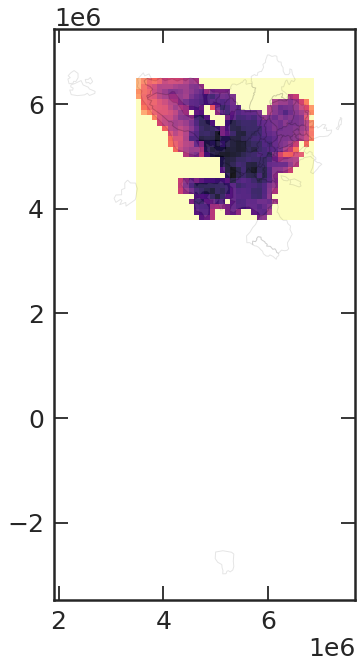

In [54]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


occurrences_within_100100_grid_europe[['geometry', 'Total']].plot(column='Total', cmap='magma_r', ax=ax);
europe_nad83.plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [58]:
# occurrences_within_100100_grid_europe.to_file('../results/europe/sp_polygon_100100/occurrences_within_100100_grid_europe.shp')

# Fixing shp files exported (DONE!!!)
<a id="fixing-shp-files-exported"></a>
<a href="#summary">Summary</a>

When exporting the files, the projection attributes where not exported together with the shp files. This is because we have to define the projection in question for the gpd.GeoDataFrame before exporting it. In this section we are going to fix this so whenever a file is loaded (or send it to anybody) it already has the projection within it.

## North america
<a id="north-america"></a>
<a href="#summary">Summary</a>

### $50km^2$
<a id="north-america-50-km"></a>
<a href="#summary">Summary</a>

Load the shp file

In [93]:
occurrences_within_5050_grid_north_america = gpd.read_file('../results/north_america/sp_polygon_5050/occurrences_within_5050_grid_north_america.shp')

Apply the projections

In [94]:
occurrences_within_5050_grid_north_america.crs = nad83_proj_dict
occurrences_within_5050_grid_north_america_wgs84 = occurrences_within_5050_grid_north_america.to_crs(wgs84_proj_dict)

Check the projections

In [95]:
occurrences_within_5050_grid_north_america_wgs84.crs

{'init': 'epsg:4326'}

In [96]:
occurrences_within_5050_grid_north_america.crs

{'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0}

Export the files

In [98]:
# occurrences_within_5050_grid_north_america.to_file('../results/north_america/nad83/sp_polygon_5050_nad83/occurrences_within_5050_grid_north_america_nad83.shp')
# occurrences_within_5050_grid_north_america_wgs84.to_file('../results/north_america/wgs84/sp_polygon_5050_wgs84/occurrences_within_5050_grid_north_america_wgs84.shp')

### $100km^2$
<a id="north-america-50-km"></a>
<a href="#summary">Summary</a>

Load the shp file

In [99]:
occurrences_within_100100_grid_north_america = gpd.read_file('../results/north_america/nad83/sp_polygon_100100_nad83/occurrences_within_100100_grid_north_america_nad83.shp')

Apply the projections

In [100]:
occurrences_within_100100_grid_north_america.crs = nad83_proj_dict
occurrences_within_100100_grid_north_america_wgs84 = occurrences_within_100100_grid_north_america.to_crs(wgs84_proj_dict)

Check the projections

In [101]:
occurrences_within_100100_grid_north_america_wgs84.crs

{'init': 'epsg:4326'}

In [102]:
occurrences_within_100100_grid_north_america.crs

{'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0,
 'wktext': True}

Export the files

In [103]:
# occurrences_within_100100_grid_north_america.to_file('../results/north_america/nad83/sp_polygon_100100_nad83/occurrences_within_100100_grid_north_america_nad83.shp')
# occurrences_within_100100_grid_north_america_wgs84.to_file('../results/north_america/wgs84/sp_polygon_100100_wgs84/occurrences_within_100100_grid_north_america_wgs84.shp')

## Europe
<a id="europe"></a>
<a href="#summary">Summary</a>

### $50km^2$
<a id="europe-50-km"></a>
<a href="#summary">Summary</a>

Load the shp file

In [131]:
occurrences_within_5050_grid_europe = gpd.read_file('../results/europe/nad83/sp_polygon_5050_nad83/occurrences_within_5050_grid_europe_nad83.shp')

Apply the projections

In [133]:
occurrences_within_5050_grid_europe.crs = nad83_proj_dict
occurrences_within_5050_grid_europe_wgs84 = occurrences_within_5050_grid_europe.to_crs(wgs84_proj_dict)

Check the projections

In [134]:
occurrences_within_5050_grid_europe_wgs84.crs

{'init': 'epsg:4326'}

In [135]:
occurrences_within_5050_grid_europe.crs

{'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0}

Export the files

In [136]:
# occurrences_within_5050_grid_europe.to_file('../results/europe/nad83/sp_polygon_5050_nad83/occurrences_within_5050_grid_europe_nad83.shp')
# occurrences_within_5050_grid_europe_wgs84.to_file('../results/europe/wgs84/sp_polygon_5050_wgs84/occurrences_within_5050_grid_europe_wgs84.shp')

### $100km^2$
<a id="europe-100-km"></a>
<a href="#summary">Summary</a>

Load the shp file

In [155]:
occurrences_within_100100_grid_europe = gpd.read_file('../results/europe/nad83/sp_polygon_100100_nad83/occurrences_within_100100_grid_europe_nad83.shp')

Apply the projections

In [156]:
occurrences_within_100100_grid_europe.crs = nad83_proj_dict
occurrences_within_100100_grid_europe_wgs84 = occurrences_within_100100_grid_europe.to_crs(wgs84_proj_dict)

Check the projections

In [157]:
occurrences_within_100100_grid_europe_wgs84.crs

{'init': 'epsg:4326'}

In [158]:
occurrences_within_100100_grid_europe.crs

{'datum': 'NAD83',
 'lat_0': 40,
 'lat_1': 20,
 'lat_2': 60,
 'lon_0': -96,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'm',
 'x_0': 0,
 'y_0': 0,
 'wktext': True}

Export the files

In [159]:
# occurrences_within_100100_grid_europe.to_file('../results/europe/nad83/sp_polygon_100100_nad83/occurrences_within_100100_grid_europe_nad83.shp')
# occurrences_within_100100_grid_europe_wgs84.to_file('../results/europe/wgs84/sp_polygon_100100_wgs84/occurrences_within_100100_grid_europe_wgs84.shp')

# North America (AGAIN)
<a id="north-america-again"></a>
<a href="#summary">Summary</a>

Loading the new files with just aquatic species.

In [32]:
north_america_again = pd.read_excel('../raw_data/north_america_again/NA_species_for_network_study.xlsx')

In [34]:
north_america_again_nad83 = gpd.read_file('../raw_data/north_america_again/NA_plants_100km/NA_100km_aquaticOBL_spp211.shp')

Check the projection.

In [35]:
north_america_again_nad83.crs

{'proj': 'lcc',
 'lat_1': 20,
 'lat_2': 60,
 'lat_0': 40,
 'lon_0': -96,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

Select just the columns with the species.

In [42]:
north_america_again_nad83 = north_america_again_nad83[north_america_again_nad83.columns[6:]]

In [53]:
north_america_again_nad83['Total'] = north_america_again_nad83[north_america_again_nad83.columns[:-1]].sum(axis=1)

/home/dsvieira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We remove the grids where no species were found, i.e., where the richness is 0.

In [79]:
north_america_again_nad83 = north_america_again_nad83[north_america_again_nad83['Total'] != 0].reset_index(drop=True)

Richeness plot for the 100kmx100km ok!

Now we have to convert these grids to 50kmx50km, the same way we did for the Europe before.

First we create a gpd.GeoDataFrame with the dissolved polygons of all the grids that we have from the cgrs data.

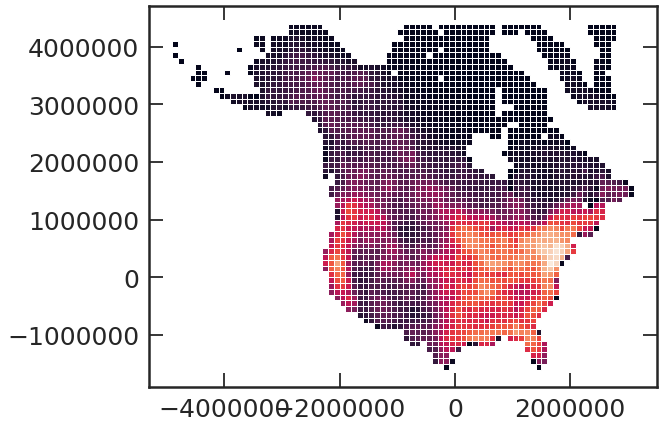

In [80]:
north_america_again_nad83.plot(column='Total', figsize=stdfigsize())

In [84]:
north_america_again_nad83.columns[:-2]

Index(['AlisGram', 'AlisLanc', 'AlisPlana', 'AlisSubc', 'AlisTriv', 'AponDist',
       'AzolCaro_G', 'AzolFili_G', 'AzolMexi', 'BlyxAude',
       ...
       'VallAmer', 'WolfArrh', 'WolfBore', 'WolfBras', 'WolfColu',
       'WolffellaG', 'WolffellaL', 'WolffellaO', 'WolfGlob', 'ZannPalu'],
      dtype='object', length=225)

In [85]:
tmp_l = []
for sp in north_america_again_nad83.columns[:-2]:
    # sp = 'Acorus calamus'
    df = north_america_again_nad83[[sp, 'geometry']] 
    gdf = df[df[sp] != 0].dissolve(sp).reset_index()
    del gdf[sp]
    gdf['specie'] = sp

    tmp_l.append(gdf)

In [86]:
north_america_again_sp_polygon = pd.concat(tmp_l).reset_index(drop=True)
del tmp_l

In [90]:
# north_america_again_sp_polygon.to_file('../results/north_america_again/sp_polygon/north_america_again_sp_polygon.shp')

Now we have to create the fishnet for the North America. To do this we are going to use the function **fishnet**.

Before creating the fishnet, we are going to take a look at the places where the data is found.

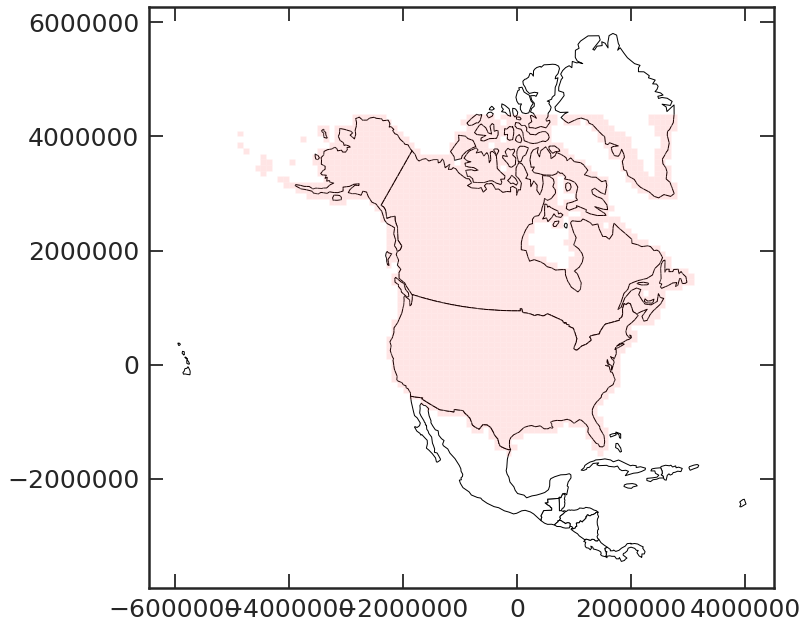

In [99]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=2, ratio=0.8))

world[(world['continent'] == 'North America')].to_crs(nad83_proj_dict).plot(ax=ax, color='white', edgecolor='black')
north_america_again_nad83.plot(ax=ax, color='red', alpha=0.1)

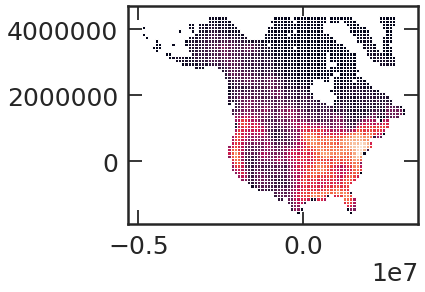

In [102]:
north_america_again_nad83.plot(column='Total')

In [105]:
grids_north_america_again_5050 = fishnet(north_america_again_nad83, width=50000, height=50000)

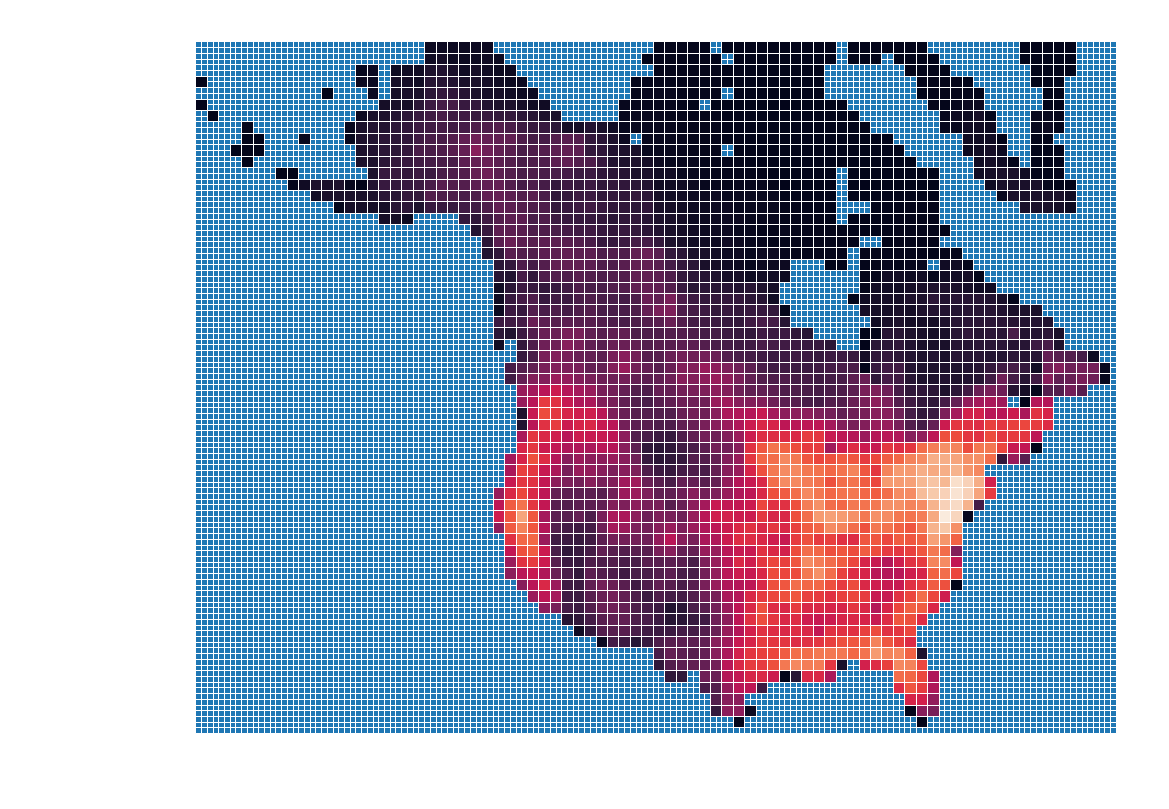

In [110]:
fig, ax = plt.subplots(figsize=stdfigsize(2))

ax.set_axis_off()

grids_north_america_again_5050.plot(ax=ax)
north_america_again_nad83.plot(column='Total', ax=ax)

Now that we have the polygon data and the grids, we can count the number of species within each grid.

We have to count the number of species within each grid.

In [111]:
species_north_america_again = north_america_again_sp_polygon['specie']

We create a code number for each specie.

In [112]:
north_america_again_sp_code_dict = {sp: n for n, sp in enumerate(species_north_america_again)}

In [117]:
north_america_again_sp_polygon['area'] = north_america_again_sp_polygon.area

No polygons with zero area.

In [120]:
(north_america_again_sp_polygon['area'] == 0).any()

False

In [124]:
polys1 = north_america_again_sp_polygon['geometry']
polys2 = grids_north_america_again_5050['geometry']

species = north_america_again_sp_polygon['specie']

df1 = gpd.GeoDataFrame({
    'geometry':
    polys1,
    'df1':
    np.arange(1,
              len(polys1) + 1),
    'species': [sp for sp, n in north_america_again_sp_code_dict.items()],
    'code': [n for sp, n in north_america_again_sp_code_dict.items()]
})
df2 = gpd.GeoDataFrame({
    'geometry': polys2,
    'df2': np.arange(1,
                     len(polys2) + 1)
})

Here we calculate all the intersections.

In [125]:
intersection_grids_species_gpd_north_america_again = gpd.overlay(df1, df2, how='intersection')

Column df1 has all the labels from the **path_details_gdf**:

In [126]:
df1.head(2)

geometry  df1   species  code
0  (POLYGON ((-1400000 -400000, -1400000 -300000,...    1  AlisGram     0
1  (POLYGON ((-1800000 0, -1800000 -100000, -1900...    2  AlisLanc     1

While the df2 has all the labels from the **grid_5050_north_america_cut_sq**:

In [127]:
df2.head(2)

geometry  df2
0  POLYGON ((-4900000 4400000.00012207, -4850000 ...    1
1  POLYGON ((-4900000 4350000.00012207, -4850000 ...    2

The **intersection_grids_species_gpd** contain the polygon of intersection between the labels $i$ and $j$ from df1 and df2, respectively.

In [128]:
intersection_grids_species_gpd_north_america_again

df1     species  code    df2  \
205       1    AlisGram     0  11203   
4226      4    AlisSubc     3  11203   
6972      5    AlisTriv     4  11203   
58327    16    CaltPalu    15  11203   
75245    19  CeraDeme_g    18  11203   
...     ...         ...   ...    ...   
639970  203    SparHype   202  17469   
642387  203    SparHype   202   3535   
642401  203    SparHype   202   3534   
642475  203    SparHype   202   3414   
642483  203    SparHype   202   3413   

                                                 geometry  
205     POLYGON ((-300000 900000.0001220703, -250000 9...  
4226    POLYGON ((-300000 900000.0001220703, -250000 9...  
6972    POLYGON ((-300000 900000.0001220703, -250000 9...  
58327   POLYGON ((-300000 900000.0001220703, -250000 9...  
75245   POLYGON ((-300000 900000.0001220703, -250000 9...  
...                                                   ...  
639970  POLYGON ((2300000 2200000.00012207, 2300000.00...  
642387  POLYGON ((-3450000 3150000.00012207, -3400000 ...  
642401  POLYGON ((-3450000 3200000.00012207, -3400000 ...  
642475  POLYGON ((-3500000 3150000.00012207, -3450000 ...  
642483  POLYGON ((-3500000 3200000.00012207, -3450000 ...  

[236891 rows x 5 columns]

For instance, on the last five rows of the **intersection_grids_species_gpd_north_america_again** displayed above, we have that species on the labels 1, 4, 5, 16, and 19 intersect the grid of label 11203.

What we have to do now, is to group the labels of the grids and count how many species were found within them.

In [130]:
intersection_grids_species_gpd_north_america_again.groupby('df2').count()

df1  species  code  geometry
df2                                
7        1        1     1         1
8        1        1     1         1
11       1        1     1         1
12       1        1     1         1
128      1        1     1         1
...    ...      ...   ...       ...
19299    3        3     3         3
19417    3        3     3         3
19418    3        3     3         3
19419    3        3     3         3
19420    3        3     3         3

[9987 rows x 4 columns]

The pd.DataFrame above shows the number of occurrences within the grid. For instance grid 7 (first one on the pd.DataFrame) has 1 occurrence while the grid 19420 (last one on the pd.DataFrame) has 3 occurrences.

In [131]:
df2['num_species'] = df2['df2'].map(intersection_grids_species_gpd_north_america_again.groupby('df2').count().to_dict('dict')['df1']).fillna(0.0)

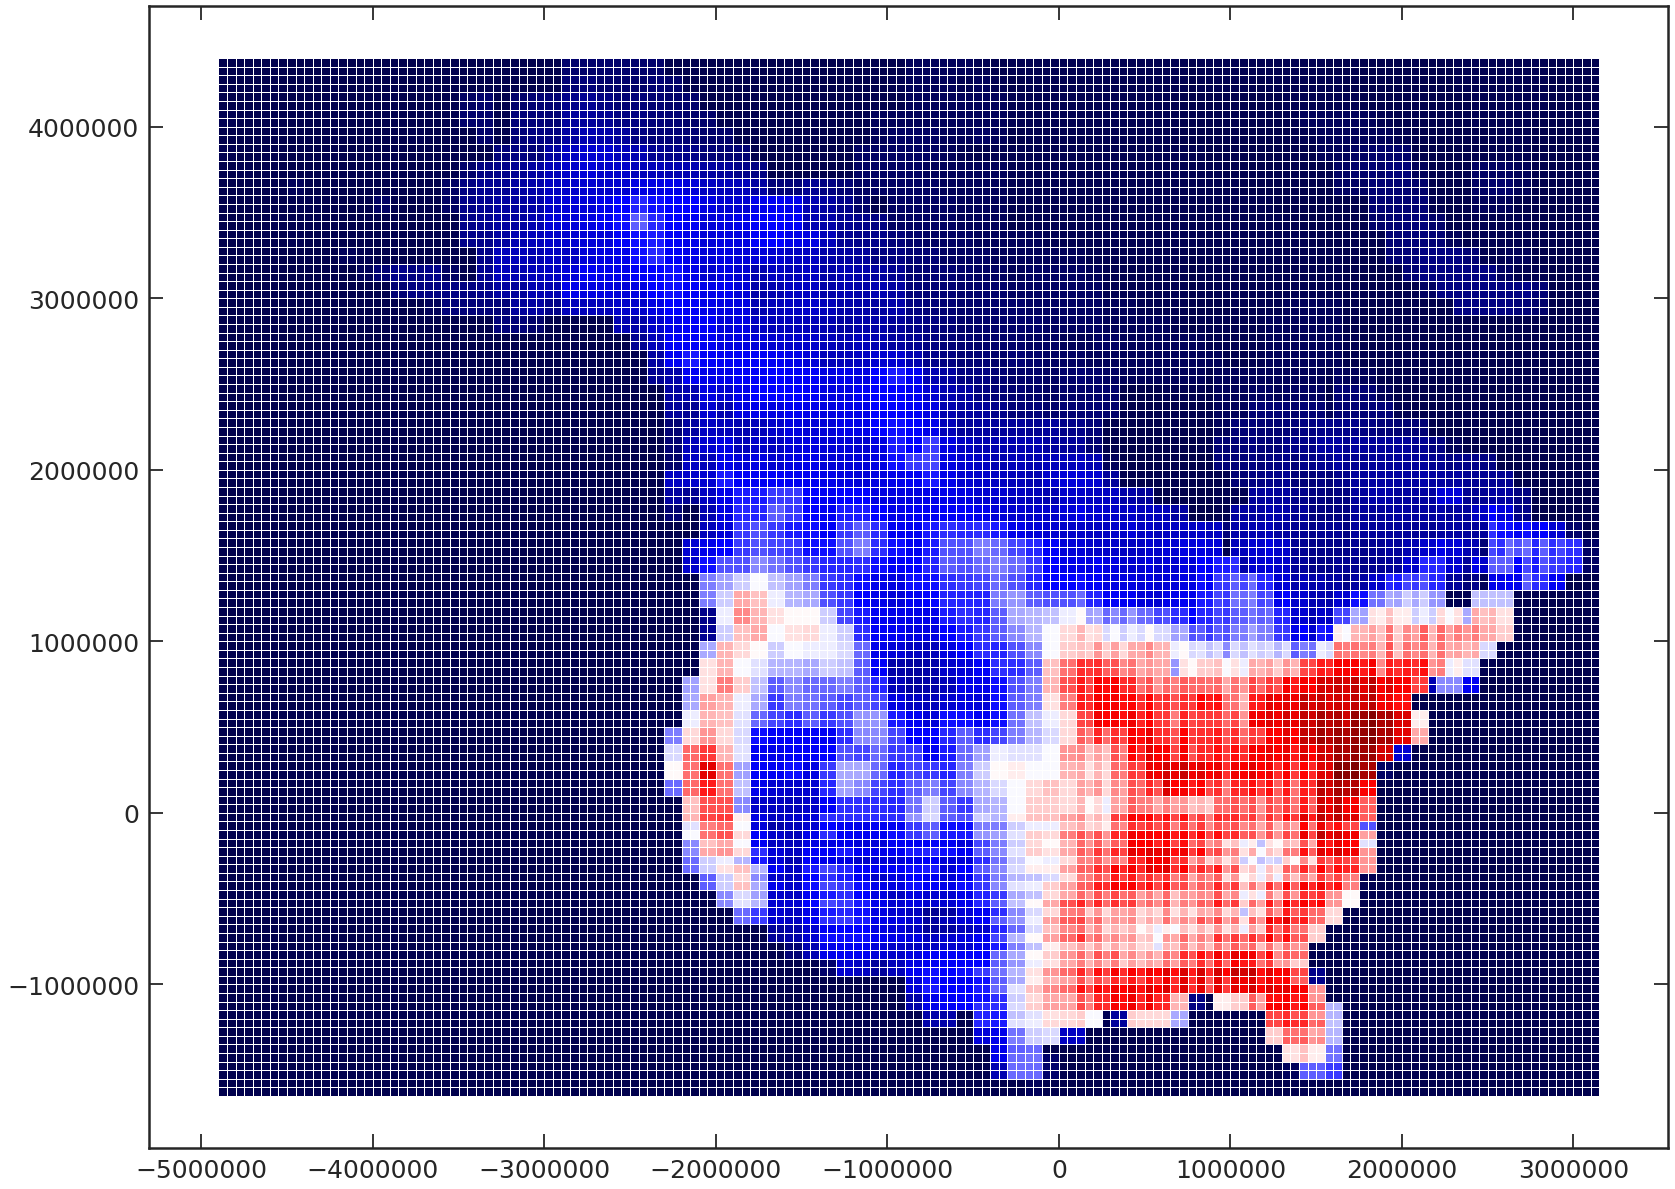

In [132]:
fig, ax = plt.subplots(1, 1, figsize=stdfigsize(scale=3))

df2.plot(column='num_species', cmap='seismic', ax=ax);

Now, what we have to do is group the polygons for each specie.

In [136]:
# create a pd.DataFrame with the geometries of the 50kmx50km grids to put each specie together as a column
df = pd.DataFrame(df2['geometry'])

# loop through the name of the species
for sp in df1['species']:

    # create a dictionary where keys are the number of the grids and values are presence (1) or abscence (0) of the specie in that grid
    sp_dict = intersection_grids_species_gpd_north_america_again[intersection_grids_species_gpd_north_america_again['species'] == sp][['df2', 'species']].groupby('df2').count().to_dict('dict')['species']
    # create a column of the specie in the pd.DataFrame
    df[str(north_america_again_sp_code_dict[sp]) + '_' + sp] = df2['df2'].map(sp_dict).fillna(0)

In [137]:
df.head(3)

geometry  0_AlisGram  1_AlisLanc  \
0  POLYGON ((-4900000 4400000.00012207, -4850000 ...         0.0         0.0   
1  POLYGON ((-4900000 4350000.00012207, -4850000 ...         0.0         0.0   
2  POLYGON ((-4900000 4300000.00012207, -4850000 ...         0.0         0.0   

   2_AlisPlana  3_AlisSubc  4_AlisTriv  5_AponDist  6_AzolCaro_G  \
0          0.0         0.0         0.0         0.0           0.0   
1          0.0         0.0         0.0         0.0           0.0   
2          0.0         0.0         0.0         0.0           0.0   

   7_AzolFili_G  8_AzolMexi      ...       215_VallAmer  216_WolfArrh  \
0           0.0         0.0      ...                0.0           0.0   
1           0.0         0.0      ...                0.0           0.0   
2           0.0         0.0      ...                0.0           0.0   

   217_WolfBore  218_WolfBras  219_WolfColu  220_WolffellaG  221_WolffellaL  \
0           0.0           0.0           0.0             0.0             0.0   
1           0.0           0.0           0.0             0.0             0.0   
2           0.0           0.0           0.0             0.0             0.0   

   222_WolffellaO  223_WolfGlob  224_ZannPalu  
0             0.0           0.0           0.0  
1             0.0           0.0           0.0  
2             0.0           0.0           0.0  

[3 rows x 226 columns]

We add a column with the total species that occurred within that grid.

In [138]:
df['Total'] = df[df.columns[1:]].sum(axis=1)

And transform this pd.DataFrame into a gpd.GeoDataFrame, so the geometry column could be treated such polygons.

In [139]:
occurrences_within_5050_grid_north_america_again = gpd.GeoDataFrame(df, geometry='geometry')

In [140]:
occurrences_within_5050_grid_north_america_again

geometry  0_AlisGram  \
0      POLYGON ((-4900000 4400000.00012207, -4850000 ...         0.0   
1      POLYGON ((-4900000 4350000.00012207, -4850000 ...         0.0   
2      POLYGON ((-4900000 4300000.00012207, -4850000 ...         0.0   
3      POLYGON ((-4900000 4250000.00012207, -4850000 ...         0.0   
4      POLYGON ((-4900000 4200000.00012207, -4850000 ...         0.0   
...                                                  ...         ...   
19476  POLYGON ((3100000 -1399999.99987793, 3150000 -...         0.0   
19477  POLYGON ((3100000 -1449999.99987793, 3150000 -...         0.0   
19478  POLYGON ((3100000 -1499999.99987793, 3150000 -...         0.0   
19479  POLYGON ((3100000 -1549999.99987793, 3150000 -...         0.0   
19480  POLYGON ((3100000 -1599999.99987793, 3150000 -...         0.0   

       1_AlisLanc  2_AlisPlana  3_AlisSubc  4_AlisTriv  5_AponDist  \
0             0.0          0.0         0.0         0.0         0.0   
1             0.0          0.0         0.0         0.0         0.0   
2             0.0          0.0         0.0         0.0         0.0   
3             0.0          0.0         0.0         0.0         0.0   
4             0.0          0.0         0.0         0.0         0.0   
...           ...          ...         ...         ...         ...   
19476         0.0          0.0         0.0         0.0         0.0   
19477         0.0          0.0         0.0         0.0         0.0   
19478         0.0          0.0         0.0         0.0         0.0   
19479         0.0          0.0         0.0         0.0         0.0   
19480         0.0          0.0         0.0         0.0         0.0   

       6_AzolCaro_G  7_AzolFili_G  8_AzolMexi  ...    216_WolfArrh  \
0               0.0           0.0         0.0  ...             0.0   
1               0.0           0.0         0.0  ...             0.0   
2               0.0           0.0         0.0  ...             0.0   
3               0.0           0.0         0.0  ...             0.0   
4               0.0           0.0         0.0  ...             0.0   
...             ...           ...         ...  ...             ...   
19476           0.0           0.0         0.0  ...             0.0   
19477           0.0           0.0         0.0  ...             0.0   
19478           0.0           0.0         0.0  ...             0.0   
19479           0.0           0.0         0.0  ...             0.0   
19480           0.0           0.0         0.0  ...             0.0   

       217_WolfBore  218_WolfBras  219_WolfColu  220_WolffellaG  \
0               0.0           0.0           0.0             0.0   
1               0.0           0.0           0.0             0.0   
2               0.0           0.0           0.0             0.0   
3               0.0           0.0           0.0             0.0   
4               0.0           0.0           0.0             0.0   
...             ...           ...           ...             ...   
19476           0.0           0.0           0.0             0.0   
19477           0.0           0.0           0.0             0.0   
19478           0.0           0.0           0.0             0.0   
19479           0.0           0.0           0.0             0.0   
19480           0.0           0.0           0.0             0.0   

       221_WolffellaL  222_WolffellaO  223_WolfGlob  224_ZannPalu  Total  
0                 0.0             0.0           0.0           0.0    0.0  
1                 0.0             0.0           0.0           0.0    0.0  
2                 0.0             0.0           0.0           0.0    0.0  
3                 0.0             0.0           0.0           0.0    0.0  
4                 0.0             0.0           0.0           0.0    0.0  
...               ...             ...           ...           ...    ...  
19476             0.0             0.0           0.0           0.0    0.0  
19477             0.0             0.0           0.0           0.0    0.0  
19478             0.0

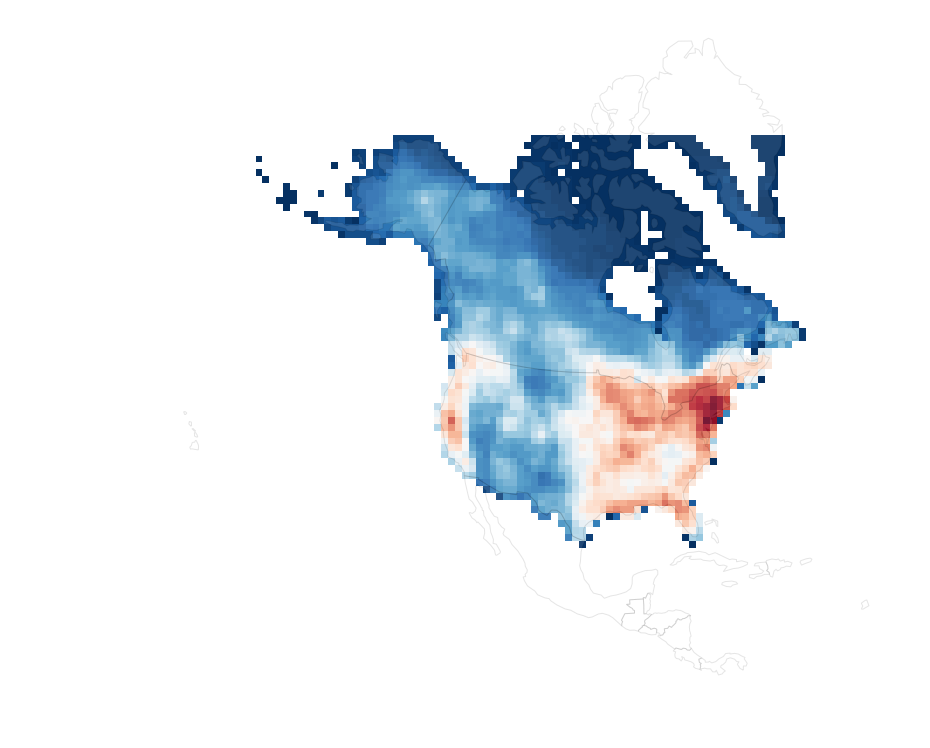

In [274]:
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.5))


north_america_again_nad83[north_america_again_nad83['Total'] != 0][['geometry', 'Total']].plot(column='Total', cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, ax=ax, lw=0);
north_america_nad83.plot(ax=ax, color='white', edgecolor='black', alpha=0.1);

# ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
ax.set_axis_off()

fig.tight_layout()

In [145]:
occurrences_within_5050_grid_north_america_again.crs = nad83_proj_dict

In [148]:
occurrences_within_5050_grid_north_america_again_wgs84 = occurrences_within_5050_grid_north_america_again.to_crs(wgs84_proj_dict)

In [179]:
df_grids = occurrences_within_5050_grid_north_america_again_wgs84[occurrences_within_5050_grid_north_america_again_wgs84['Total'] != 0]
df_na    = world[world['continent'] == 'North America'].dissolve('continent')

df_over = gpd.overlay(df_grids, df_na, how='intersection')

In [192]:
occurrences_within_5050_grid_north_america_again_wgs84 = df_over[df_over.columns[~df_over.columns.isin(['pop_est', 'name', 'iso_a3', 'gdp_md_est'])]]

In [194]:
occurrences_within_5050_grid_north_america_again = occurrences_within_5050_grid_north_america_again_wgs84.to_crs(nad83_proj_dict)

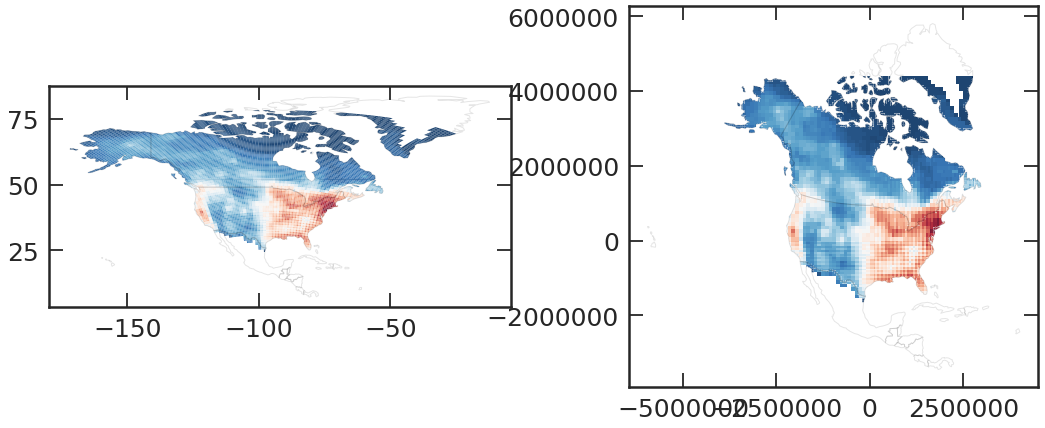

In [195]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(ny=1, nx=2))


occurrences_within_5050_grid_north_america_again_wgs84[['geometry', 'Total']].plot(column='Total', cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, lw=0, ax=ax[0]);
world[world['continent'] == 'North America'].plot(ax=ax[0], color='white', edgecolor='black', alpha=0.1);

occurrences_within_5050_grid_north_america_again[['geometry', 'Total']].plot(column='Total', cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, lw=0, ax=ax[1]);
world[world['continent'] == 'North America'].to_crs(nad83_proj_dict).plot(ax=ax[1], color='white', edgecolor='black', alpha=0.1);


# ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [196]:
# occurrences_within_5050_grid_north_america_again.to_file('../results/north_america_again/nad83/sp_polygon_5050_nad83/occurrences_within_5050_grid_north_america_again_nad83.shp')

In [197]:
# occurrences_within_5050_grid_north_america_again_wgs84.to_file('../results/north_america_again/wgs84/sp_polygon_5050_wgs84/occurrences_within_5050_grid_north_america_again_wgs84.shp')

Now we are going to fix the **north_america_again_nad83**, which is presence absence matrix for species within each grid of $100km^2$.

In [244]:
df = north_america_again_nad83.copy()

In [246]:
df.columns = ["{}_{}".format(i, north_america_again_nad83.columns[:-2][i]) for i in range(len(north_america_again_nad83.columns[:-2]))] + ['geometry', 'Tota']

In [250]:
df_wgs84 = df.to_crs(wgs84_proj_dict)

In [251]:
df_grids = df_wgs84[df_wgs84['Total'] != 0]
df_na    = world[world['continent'] == 'North America'].dissolve('continent')

df_over = gpd.overlay(df_grids, df_na, how='intersection')

In [252]:
occurrences_within_100100_grid_north_america_again_wgs84 = df_over[df_over.columns[~df_over.columns.isin(['pop_est', 'name', 'iso_a3', 'gdp_md_est'])]]

In [253]:
occurrences_within_100100_grid_north_america_again = occurrences_within_100100_grid_north_america_again_wgs84.to_crs(nad83_proj_dict)

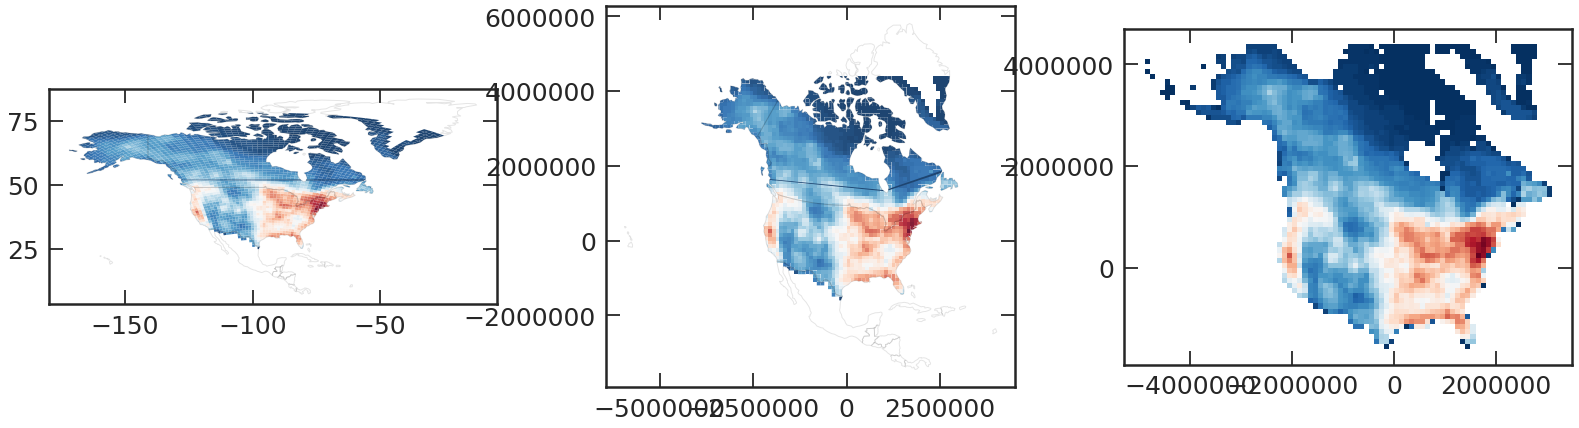

In [258]:
fig, ax = plt.subplots(1, 3, figsize=stdfigsize(ny=1, nx=3))


occurrences_within_100100_grid_north_america_again_wgs84[['geometry', 'Total']].plot(column='Total', cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, lw=0, ax=ax[0]);
world[world['continent'] == 'North America'].plot(ax=ax[0], color='white', edgecolor='black', alpha=0.1);

occurrences_within_100100_grid_north_america_again[['geometry', 'Total']].plot(column='Total', cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, lw=0, ax=ax[1]);
world[world['continent'] == 'North America'].to_crs(nad83_proj_dict).plot(ax=ax[1], color='white', edgecolor='black', alpha=0.1);

north_america_again_nad83.plot(column='Total', ax=ax[2], cmap=palettable.colorbrewer.diverging.RdBu_11_r.mpl_colormap, lw=0)

# ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

In [264]:
# occurrences_within_100100_grid_north_america_again.to_file('../results/north_america_again/nad83/sp_polygon_100100_nad83/occurrences_within_100100_grid_north_america_again_nad83.shp')

In [266]:
# occurrences_within_100100_grid_north_america_again_wgs84.to_file('../results/north_america_again/wgs84/sp_polygon_100100_wgs84/occurrences_within_100100_grid_north_america_again_wgs84.shp')

# Compare the richness distribution for different grids
<a id="compare-the-richness-distribution"></a>
<a href="#summary">Summary</a>

The idea is to compare the distribution for both grids:
* $50km \times 50km$ 
* $100km \times 100km$ 

in order to see if they are similar and we can explain why we are using particularly one of them.
If they are alike, we can say that in this range the data is robust.

To compare the data from these grids, we are going to compare the distributions of the column **Total** in order to check the consistency of the richness of species.

## Europe
<a id="compare-the-richness-distribution-europe"></a>
<a href="#summary">Summary</a>

In [10]:
occurrences_within_5050_grid_europe_wgs84 = gpd.read_file(
    '../results/europe/wgs84/sp_polygon_5050_wgs84/occurrences_within_5050_grid_europe_wgs84.shp')
occurrences_within_100100_grid_europe_wgs84 = gpd.read_file(
    '../results/europe/wgs84/sp_polygon_100100_wgs84/occurrences_within_100100_grid_europe_wgs84.shp')

DriverError: results/europe/wgs84/sp_polygon_5050_wgs84/occurrences_within_5050_grid_europe_wgs84.shp: No such file or directory

In [163]:
# check if we are comparing the grids with the same crs (Coordinate reference system)
occurrences_within_5050_grid_europe_wgs84.crs == occurrences_within_100100_grid_europe_wgs84.crs

True

In [217]:
occurrences_within_5050_grid_europe_wgs84['Total'].max(), occurrences_within_100100_grid_europe_wgs84['Total'].max()

(116.0, 123.0)

'We cannot reject the null hypothesis at a 60% or lower alpha since the p-value at 0.60 is higher than 60%'

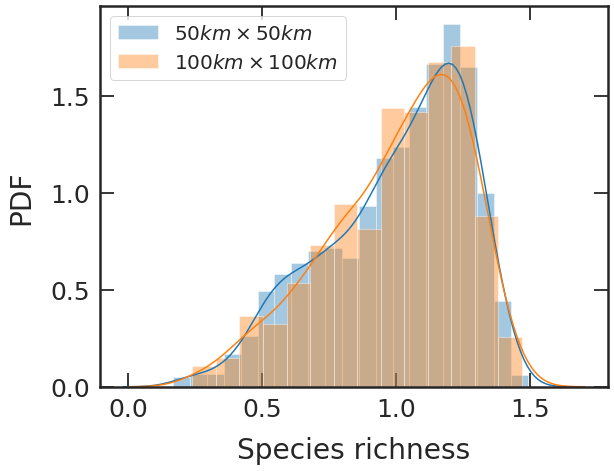

In [261]:
fig, ax = plt.subplots(figsize=stdfigsize())

data_5050 = occurrences_within_5050_grid_europe_wgs84[
    occurrences_within_5050_grid_europe_wgs84['Total'] > 116.0*0.1]['Total']
data_100100 = occurrences_within_100100_grid_europe_wgs84[
    occurrences_within_100100_grid_europe_wgs84['Total'] > 123.0*0.1]['Total']

# data_5050 = (data_5050 - data_5050.mean())/data_5050.std()
# data_100100 = (data_100100 - data_100100.mean())/data_100100.std()

# data_5050 = data_5050/data_5050.std()
# data_100100 = data_100100/data_100100.std()

data_5050 = data_5050/data_5050.mean()
data_100100 = data_100100/data_100100.mean()

sns.distplot(
    data_5050, ax=ax, norm_hist=True)
sns.distplot(
    data_100100, ax=ax, norm_hist=True)

ax.set_xlabel('Species richness')
ax.set_ylabel('PDF')

ax.legend(['$50km \\times 50 km$', '$100km \\times 100 km$'])

# Two sample Kolmogorv-Smirnov test
ks_test = scipy.stats.ks_2samp(data_5050, data_100100)

"We cannot reject the null hypothesis at a 60% or lower alpha since the p-value at {:.2f} is higher than 60%".format(
    ks_test[1])

We conclude then that the richness distribution for both grids are drawn from the same distribution according to the Kolmogorov-Smirnov test (p-value > 0.5).

## North America
<a id="compare-the-richness-distribution-north-america"></a>
<a href="#summary">Summary</a>

In [186]:
occurrences_within_5050_grid_north_america_wgs84 = gpd.read_file(
    '../results/north_america/wgs84/sp_polygon_5050_wgs84/occurrences_within_5050_grid_north_america_wgs84.shp')
occurrences_within_100100_grid_north_america_wgs84 = gpd.read_file(
    '../results/north_america/wgs84/sp_polygon_100100_wgs84/occurrences_within_100100_grid_north_america_wgs84.shp')

In [187]:
# check if we are comparing the grids with the same crs (Coordinate reference system)
occurrences_within_5050_grid_north_america_wgs84.crs == occurrences_within_100100_grid_north_america_wgs84.crs

True

In [215]:
occurrences_within_5050_grid_north_america_wgs84['Total'].max(), occurrences_within_100100_grid_north_america_wgs84['Total'].max()

(112.0, 120.0)

'We cannot reject the null hypothesis at a 10% or lower alpha since the p-value at 0.20 is higher than 10%'

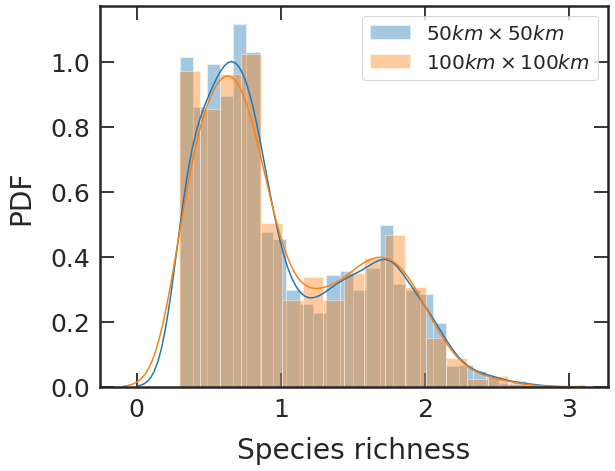

In [260]:
fig, ax = plt.subplots(figsize=stdfigsize())

data_5050 = occurrences_within_5050_grid_north_america_wgs84[
    occurrences_within_5050_grid_north_america_wgs84['Total'] > 112.0*0.10]['Total']
data_100100 = occurrences_within_100100_grid_north_america_wgs84[
    occurrences_within_100100_grid_north_america_wgs84['Total'] > 120.0*0.10]['Total']

# data_5050 = (data_5050 - data_5050.mean())/data_5050.std()
# data_100100 = (data_100100 - data_100100.mean())/data_100100.std()

# data_5050 = data_5050/data_5050.std()
# data_100100 = data_100100/data_100100.std()

data_5050 = data_5050/data_5050.mean()
data_100100 = data_100100/data_100100.mean()

sns.distplot(
    data_5050, ax=ax, norm_hist=True)
sns.distplot(
    data_100100, ax=ax, norm_hist=True)

ax.set_xlabel('Species richness')
ax.set_ylabel('PDF')

ax.legend(['$50km \\times 50 km$', '$100km \\times 100 km$'])

# Two sample Kolmogorv-Smirnov test
ks_test = scipy.stats.ks_2samp(data_5050, data_100100)

"We cannot reject the null hypothesis at a 10% or lower alpha since the p-value at {:.2f} is higher than 10%".format(ks_test[1])